#### Universidad de los Andes - Maestría en Inteligencia Analítica de Datos
### Detección de Anomalías en el consumo de clientes no regulados Electro Dunas
#### Preprocesamiento y entrenamiento de modelos descriptivos y predictivos

**VARIABLES DE LA BASE DE DATOS**

**1. Active_energy:** Energía activa entregada (kWh)
* Representa la cantidad de energía eléctrica real entregada en un periodo de tiempo específico.
* Es la energía que realiza trabajo efectivo, como encender luces, hacer funcionar motores o calentar dispositivos.
* Se mide en kilovatios-hora

**2. Reactive_energy:** Energía reactiva entregada (kVarh)
* Indica la cantidad de energía intercambiada entre la fuente de energía y una carga sin realizar trabajo útil.
* Esta energía se debe principalmente a la capacitancia e inductancia de los equipos eléctricos y no produce trabajo real, pero es esencial para mantener la calidad del voltaje en el sistema eléctrico.
* Se mide en kilovatios-amperios-reativos-hora

**3. Voltaje:**
* Es la diferencia de potencial eléctrico
* Es una medida de la fuerza electromotriz que impulsa el flujo de corriente eléctrica a través de un conuctor.
* Es la energía por unidad de carga eléctrica que proporciona la capacidad de realizar trabajo eléctrico.
* Voltaje_FA y Voltaje_FC son la fase A y C respectivamente.

**4. Energía Aparente:** Raiz(Active_energy^2 + Reactive_energy^2)

##### LIBRERÍAS UTILIZADAS

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
#%pip install faker
from faker import Faker

from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model
from keras.layers import Dense, Input, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras import regularizers
import keras.backend as K

import warnings
warnings.filterwarnings("ignore")

##### CONSOLIDACIÓN DE LOS DATOS DISPONIBLES

In [2]:
import os
import re
import pandas as pd

# Ruta del directorio que contiene los archivos de Excel
directorio = "Datos"

# Obtener la lista de archivos en el directorio
archivos_excel = [archivo for archivo in os.listdir(directorio) if archivo.endswith('.csv')]

# Lista para almacenar los DataFrames de cada archivo
dataframes = []

# Iterar sobre los archivos de Excel en el directorio
for archivo in archivos_excel:
    ruta_archivo = os.path.join(directorio, archivo)
    df = pd.read_csv(ruta_archivo)

    # Agregar la columna Cliente_ID utilizando expresión regular para extraer el número
    match = re.search(r'\d+', archivo)
    if match:
        Cliente_ID = match.group()
        df['Cliente_ID'] = int(Cliente_ID)

        # Validar que las columnas requeridas estén presentes en el DataFrame
        if all(col in df.columns for col in ["Fecha", "Active_energy", "Reactive_energy", "Voltaje_FA", "Voltaje_FC", "Cliente_ID"]):
            dataframes.append(df)
        else:
            print(f"Faltan columnas en el archivo {archivo}")
    else:
        print(f"No se encontró un Cliente_ID en el archivo {archivo}")

# Concatenar todos los DataFrames en uno solo
df_final = pd.concat(dataframes, ignore_index=True)

# Leer el archivo 'sector_economico_clientes.xlsx'
df_sector = pd.read_excel('Datos/sector_economico_clientes.xlsx')
# Renombrar columnas
df_sector = df_sector.rename(columns={'Cliente:':'Cliente_ID', 'Sector Económico:':'Sector_Economico'})

# Actualizar los valores de la columna Cliente_ID
df_sector['Cliente_ID'] = pd.to_numeric(df_sector['Cliente_ID'].str.replace('Cliente ', ''), errors='coerce')

# Fusionar los DataFrames por 'Cliente_ID' y agregar la columna 'Sector_Economico'
df_resultado = pd.merge(df_final, df_sector, on='Cliente_ID', how='left')

# Mostrar el DataFrame resultante
print(df_resultado.head())


                 Fecha  Active_energy  Reactive_energy  Voltaje_FA  \
0  2021-01-01 00:00:00       0.357841         0.282788  455.139171   
1  2021-01-01 01:00:00       0.372264         0.431377  469.978787   
2  2021-01-01 02:00:00       1.044687         0.338626  468.721120   
3  2021-01-01 03:00:00       0.566425         0.495791  452.329255   
4  2021-01-01 04:00:00       1.080556         0.472018  513.477596   

   Voltaje_FC  Cliente_ID                                   Sector_Economico  
0  510.561002           1  Elaboración de cacao y chocolate y de producto...  
1  469.917178           1  Elaboración de cacao y chocolate y de producto...  
2  546.949147           1  Elaboración de cacao y chocolate y de producto...  
3  444.122989           1  Elaboración de cacao y chocolate y de producto...  
4  535.463719           1  Elaboración de cacao y chocolate y de producto...  


In [3]:
# pip install openpyxl

In [4]:
#pip install pandas faker openpyxl

In [5]:
#Estadísticas descriptivas
df_resultado[['Active_energy','Reactive_energy','Voltaje_FA','Voltaje_FC']].describe().T

count         mean         std       min         25%  \
Active_energy    463425.0     1.472050    1.718780 -1.329018    0.242788   
Reactive_energy  463425.0     0.873086    1.158846  0.000000    0.112832   
Voltaje_FA       463425.0  1420.188470  766.299118  0.031000  719.462874   
Voltaje_FC       463425.0  1438.515836  746.447449  0.031000  748.148254   

                         50%          75%          max  
Active_energy       0.810771     1.992488    14.622644  
Reactive_energy     0.380650     1.222834    11.135141  
Voltaje_FA       1625.493463  2037.276385  4266.229746  
Voltaje_FC       1634.696089  2040.554497  4399.038932

#### PREPROCESAMIENTO
##### VALIDACIÓN DE VALORES FALTANTES, VALORES EN CERO Y NEGATIVOS

In [6]:
def generar_resumen_missing_values(dataframe):
    """
    Genera un DataFrame que resume la cantidad y el porcentaje de valores faltantes en cada columna del DataFrame proporcionado.
    Returns:
    pd.DataFrame: Un DataFrame que contiene dos columnas, una con la cantidad de valores faltantes por columna y otra con el porcentaje de esos valores faltantes respecto al total de filas.
    """
    # Calcula la cantidad de valores faltantes por columna
    missing_values = dataframe.isnull().sum()

    # Calcula el porcentaje de valores faltantes por columna
    porcentaje_missing_values = (missing_values / len(dataframe)) * 100

    # Crea un DataFrame con la información recopilada
    resumen_missing_values = pd.DataFrame({
        'Valores Faltantes': missing_values,
        'Porcentaje Missing Values': porcentaje_missing_values
    })

    return resumen_missing_values
missing=generar_resumen_missing_values(df_resultado)
missing

Valores Faltantes  Porcentaje Missing Values
Fecha                             0                        0.0
Active_energy                     0                        0.0
Reactive_energy                   0                        0.0
Voltaje_FA                        0                        0.0
Voltaje_FC                        0                        0.0
Cliente_ID                        0                        0.0
Sector_Economico                  0                        0.0

In [7]:
def generar_resumen_valores_cero(dataframe):
    """
    Genera un DataFrame que resume la cantidad y el porcentaje de valores en cero en cada columna del DataFrame proporcionado.
    Returns:
    pd.DataFrame: Un DataFrame que contiene dos columnas, una con la cantidad de valores en cero por columna y otra con el porcentaje de esos valores fcero respecto al total de filas.
    """
    #Quita la columna de Sector Económico y Fecha
    dataframe = dataframe.drop(columns=['Sector_Economico','Fecha'])
    # Calcula la cantidad de valores en cero por columna
    valores_cero = (dataframe == 0).sum()

    # Calcula el porcentaje de valores en cero por columna
    porcentaje_valores_cero = (valores_cero / len(dataframe)) * 100

    # Crea un DataFrame con la información recopilada
    resumen_valores_cero = pd.DataFrame({
        'Valores en Cero': valores_cero,
        'Porcentaje Valores en Cero': porcentaje_valores_cero
    })

    return resumen_valores_cero

# Llama a la función para encontrar los valores en cero en tu DataFrame
valores_cero = generar_resumen_valores_cero(df_resultado)
print(valores_cero)

                 Valores en Cero  Porcentaje Valores en Cero
Active_energy              15013                    3.239575
Reactive_energy            15013                    3.239575
Voltaje_FA                     0                    0.000000
Voltaje_FC                     0                    0.000000
Cliente_ID                     0                    0.000000


In [8]:
def generar_resumen_valores_negativos(dataframe):
    """
    Genera un DataFrame que resume la cantidad y el porcentaje de valores negativos en cada columna del DataFrame proporcionado.
    Returns:
    pd.DataFrame: Un DataFrame que contiene dos columnas, una con la cantidad de valores negativos por columna y otra con el porcentaje de esos valores negativos respecto al total de filas.
    """
    #Quita la columna de Sector Económico y Fecha
    dataframe = dataframe.drop(columns=['Sector_Economico','Fecha'])
    # Calcula la cantidad de valores negativos por columna
    valores_negativos = (dataframe < 0).sum()

    # Calcula el porcentaje de valores negativos por columna
    porcentaje_valores_negativos = (valores_negativos / len(dataframe)) * 100

    # Crea un DataFrame con la información recopilada
    resumen_valores_negativos = pd.DataFrame({
        'Valores Negativos': valores_negativos,
        'Porcentaje Valores Negativos': porcentaje_valores_negativos
    })

    return resumen_valores_negativos

# Llama a la función para encontrar los valores negativos en tu DataFrame
valores_negativos = generar_resumen_valores_negativos(df_resultado)
print(valores_negativos)

                 Valores Negativos  Porcentaje Valores Negativos
Active_energy                  505                      0.108971
Reactive_energy                  0                      0.000000
Voltaje_FA                       0                      0.000000
Voltaje_FC                       0                      0.000000
Cliente_ID                       0                      0.000000


**Nota:** los datos no muestran valores faltantes dentro de las columnas, pero si muestran datos negativos en la energía activa, lo cual no tiene sentido tener un consumo negativo de energía, por otro lado existen 15013 valores en cero en la energía activa y reactiva, que representa cerca del 3% de todas las observaciones.

##### MATRIZ DE CORRELACIÓN

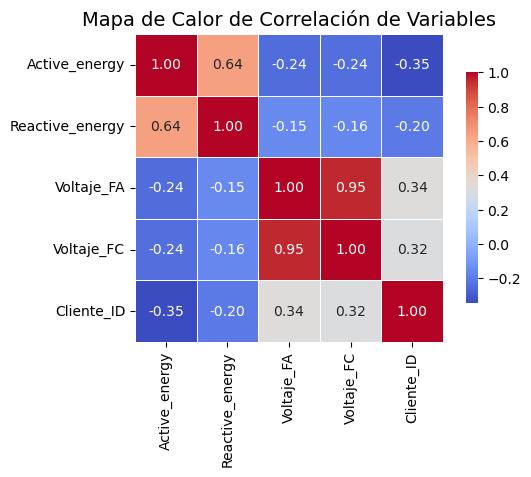

In [9]:
correlation_matrix =  df_resultado.select_dtypes(include='number').corr()

# Configurar el tamaño del gráfico
plt.figure(figsize=(6, 4))

# Crear el heatmap utilizando seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5,square=True, cbar_kws={"shrink": .75})

# Mejoras visuales para el título y los ejes
plt.title('Mapa de Calor de Correlación de Variables', fontsize=14)  # Título más descriptivo y con mayor tamaño de fuente

# Mostrar el gráfico
plt.show()

##### IDENTIFICACIÓN DE VALORES ATÍPICOS

In [10]:
variables_numericas = df_resultado.select_dtypes(include='number')

def detectar_outliers(dataframe):
    """
    Detecta outliers en el conjunto de datos utilizando el rango intercuartílico más 1.5 IQR
    Returns:
    pd.DataFrame: Un DataFrame que contiene tres columnas, El número de outliers y los valores máximos y mínimos de cada una de las variables.
    """
    outliers = pd.DataFrame()

    for columna in dataframe.columns:
        # Calcular el primer y tercer cuartil
        q1 = dataframe[columna].quantile(0.25)
        q3 = dataframe[columna].quantile(0.75)

        # Calcular el rango intercuartil (IQR)
        iqr = q3 - q1

        # Definir los límites para identificar outliers
        limite_inferior = q1 - 1.5 * iqr
        limite_superior = q3 + 1.5 * iqr

        # Filtrar los outliers y almacenarlos en el DataFrame de outliers
        outliers[columna] = dataframe[(dataframe[columna] < limite_inferior) | (dataframe[columna] > limite_superior)][columna]

    # Crear un DataFrame con el número de outliers y el valor máximo por columna
    resumen_outliers = pd.DataFrame({
        'Numero de Outliers': outliers.count(),
        'Valor Maximo': dataframe.max(),
        'Valor Minimo': dataframe.min()
    })

    return resumen_outliers


outliers=detectar_outliers(variables_numericas)
outliers

Numero de Outliers  Valor Maximo  Valor Minimo
Active_energy                 31703     14.622644     -1.329018
Reactive_energy               12969     11.135141      0.000000
Voltaje_FA                        1   4266.229746      0.031000
Voltaje_FC                        0   4399.038932      0.031000
Cliente_ID                        0     30.000000      1.000000

##### AGREGAR NUEVAS VARIABLES
###### VARIABLE ENERGÍA APARENTE
La primera decisión técnica, derivado de este proceso, es utilizar **la energía aparente como variable principal**, ya que se observa una alta correlación (0.64) entre la energía activa y la energía reactiva, además de que esta muestra la capacidad total creada de un sistema eléctrico y es el valor real cobrado a los clientes.

In [11]:
# Crear la nueva variable Apparent_energy
df_resultado['Apparent_energy'] = (df_resultado['Active_energy']**2 + df_resultado['Reactive_energy']**2)**0.5

df_resultado.head()

Fecha  Active_energy  Reactive_energy  Voltaje_FA  \
0  2021-01-01 00:00:00       0.357841         0.282788  455.139171   
1  2021-01-01 01:00:00       0.372264         0.431377  469.978787   
2  2021-01-01 02:00:00       1.044687         0.338626  468.721120   
3  2021-01-01 03:00:00       0.566425         0.495791  452.329255   
4  2021-01-01 04:00:00       1.080556         0.472018  513.477596   

   Voltaje_FC  Cliente_ID                                   Sector_Economico  \
0  510.561002           1  Elaboración de cacao y chocolate y de producto...   
1  469.917178           1  Elaboración de cacao y chocolate y de producto...   
2  546.949147           1  Elaboración de cacao y chocolate y de producto...   
3  444.122989           1  Elaboración de cacao y chocolate y de producto...   
4  535.463719           1  Elaboración de cacao y chocolate y de producto...   

   Apparent_energy  
0         0.456091  
1         0.569796  
2         1.098198  
3         0.752759  
4         1.179154

###### VARIABLES DE TIEMPO
Para facilitar el análisis de la información se desarrollan variables como el día de la semana, dia del año, semana del año, mes,  año y hora de consumo de la energía aparente.

In [12]:
# Convertir la columna 'Fecha' a tipo datetime si aún no lo está
df_resultado['Fecha'] = pd.to_datetime(df_resultado['Fecha'])

# Crear una nueva columna 'Hora' que contiene la hora de la fecha
df_resultado['Hora'] = df_resultado['Fecha'].dt.hour

# Crear una nueva columna 'Dia_Semana_Num' que contiene el día de la semana como número
df_resultado['Dia_Semana_Num'] = df_resultado['Fecha'].dt.dayofweek

# Crear una nueva columna 'Semana' que contiene la semana del año
df_resultado['Semana'] = df_resultado['Fecha'].dt.isocalendar().week

# Crear una nueva columna 'Dia_Semana_Num' que contiene el día de la semana como número
df_resultado['Dia_Anho_Num'] = df_resultado['Fecha'].dt.dayofyear

# Crear una nueva columna 'Mes' que contiene la hora de la fecha
df_resultado['Mes'] = df_resultado['Fecha'].dt.month

# Crear una nueva columna 'Año' que contiene la hora de la fecha
df_resultado['Anho'] = df_resultado['Fecha'].dt.year

# Mostrar las primeras filas del DataFrame con las nuevas columnas
df_resultado.head()

Fecha  Active_energy  Reactive_energy  Voltaje_FA  Voltaje_FC  \
0 2021-01-01 00:00:00       0.357841         0.282788  455.139171  510.561002   
1 2021-01-01 01:00:00       0.372264         0.431377  469.978787  469.917178   
2 2021-01-01 02:00:00       1.044687         0.338626  468.721120  546.949147   
3 2021-01-01 03:00:00       0.566425         0.495791  452.329255  444.122989   
4 2021-01-01 04:00:00       1.080556         0.472018  513.477596  535.463719   

   Cliente_ID                                   Sector_Economico  \
0           1  Elaboración de cacao y chocolate y de producto...   
1           1  Elaboración de cacao y chocolate y de producto...   
2           1  Elaboración de cacao y chocolate y de producto...   
3           1  Elaboración de cacao y chocolate y de producto...   
4           1  Elaboración de cacao y chocolate y de producto...   

   Apparent_energy  Hora  Dia_Semana_Num  Semana  Dia_Anho_Num  Mes  Anho  
0         0.456091     0               4      53             1    1  2021  
1         0.569796     1               4      53             1    1  2021  
2         1.098198     2               4      53             1    1  2021  
3         0.752759     3               4      53             1    1  2021  
4         1.179154     4               4      53             1    1  2021

#### ANÁLISIS DESCRIPTIVO

In [13]:
# Estadísticas descriptivas por cliente
estadisticas_por_cliente = df_resultado.groupby('Cliente_ID')['Apparent_energy'].describe()

print(estadisticas_por_cliente)

              count      mean       std       min       25%       50%  \
Cliente_ID                                                              
1           19681.0  2.168976  1.566990  0.013400  1.383203  1.679139   
2           19681.0  3.338400  1.433817  0.434222  2.700940  3.055263   
3           19681.0  2.746273  1.493911  0.088906  2.051837  2.430944   
4           19681.0  1.348564  1.531311  0.021576  0.605697  0.902650   
5           19681.0  6.560405  2.267930  0.290401  4.931467  6.390614   
6           19681.0  1.550952  1.617309  0.041162  0.541716  0.857134   
7           19681.0  2.499224  1.834484  0.031000  1.504291  1.854518   
8           19681.0  1.742333  1.292741  0.031001  1.033885  1.390845   
9           19681.0  0.780536  0.815701  0.031087  0.312263  0.402623   
10          19681.0  3.654387  1.922526  0.032899  2.214743  2.646491   
11          14000.0  0.769142  0.789989  0.008625  0.300593  0.544953   
12          11415.0  1.465787  1.220400  0.000000  

In [14]:
# Estadísticas descriptivas por sector económico
estadisticas_por_sector = df_resultado.groupby('Sector_Economico')['Apparent_energy'].describe()

print(estadisticas_por_sector)

                                                      count      mean  \
Sector_Economico                                                        
Captación, tratamiento y distribución de agua       97500.0  1.890154   
Cultivo de Hortalizas                               44625.0  0.173209   
Cultivo de hortalizas y melones, raíces y tubér...  14000.0  1.029994   
Cultivo de otros frutos y nueces de árboles y a...  53415.0  0.746175   
Cultivo de Árboles Frutales y Nueces                98405.0  2.045486   
Elaboración de cacao y chocolate y de productos...  98405.0  3.232524   
Venta al por mayor de metales y minerales metal...  57075.0  1.365976   

                                                         std       min  \
Sector_Economico                                                         
Captación, tratamiento y distribución de agua       1.931512  0.001996   
Cultivo de Hortalizas                               0.146075  0.000000   
Cultivo de hortalizas y melones, raíces y tubé

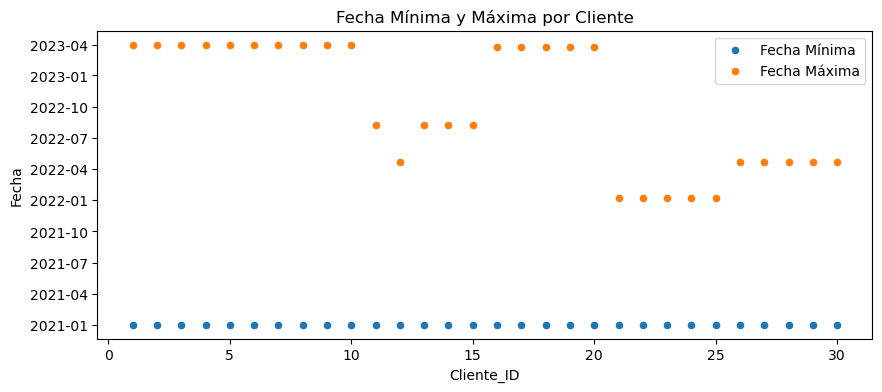

In [15]:
# Encontrar las fechas mínimas y máximas por cliente
min_dates = df_resultado.groupby('Cliente_ID')['Fecha'].min()
max_dates = df_resultado.groupby('Cliente_ID')['Fecha'].max()

# Crear un nuevo DataFrame con las fechas mínimas y máximas
summary_df = pd.DataFrame({'Cliente_ID': min_dates.index, 'Fecha_Min': min_dates.values, 'Fecha_Max': max_dates.values})

# Graficar las fechas mínimas y máximas por cliente
plt.figure(figsize=(10, 4))
sns.scatterplot(data=summary_df, x='Cliente_ID', y='Fecha_Min', label='Fecha Mínima')
sns.scatterplot(data=summary_df, x='Cliente_ID', y='Fecha_Max', label='Fecha Máxima')
plt.title('Fecha Mínima y Máxima por Cliente')
plt.xlabel('Cliente_ID')
plt.ylabel('Fecha')
plt.legend()
plt.show()


#### GRÁFICOS DESCRIPTIVOS

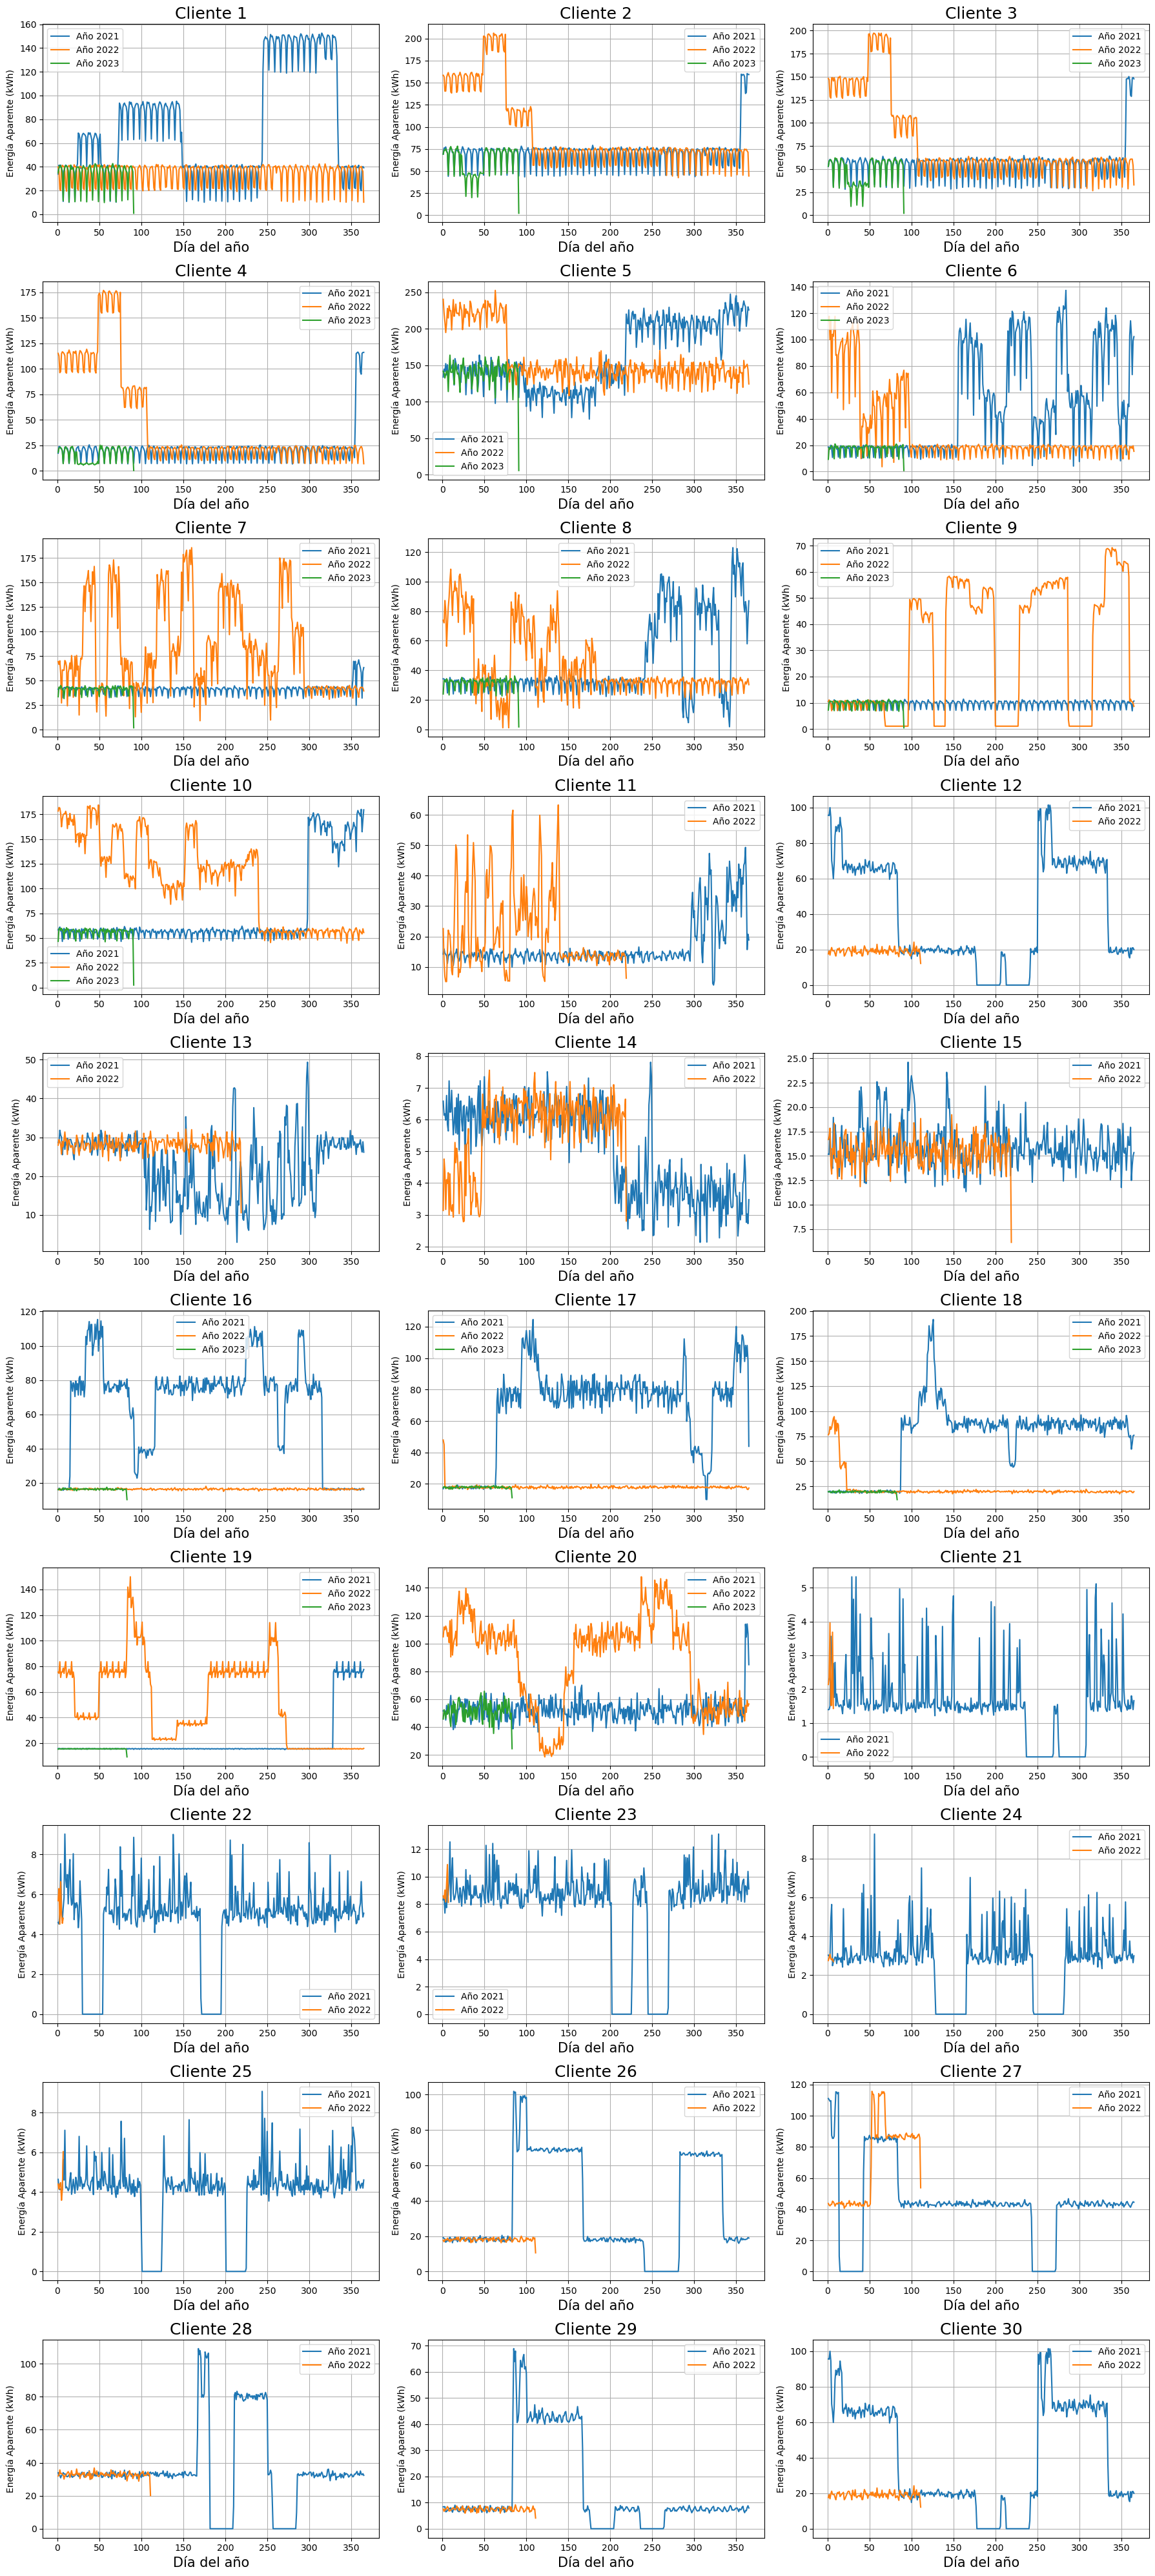

In [16]:
#Realiza un gráfico con cada cliente, mostrando la suma del consumo de energía aparente por año
# Agrupar los datos por Cliente_ID
clientes = df_resultado.groupby('Cliente_ID')

# Preparar los datos en un solo paso
energia_por_año = df_resultado.groupby(['Cliente_ID', 'Anho', 'Dia_Anho_Num']).agg({'Apparent_energy': 'sum'})

# Lista de años a graficar
años = [2021, 2022, 2023]

# Obtener una lista de todos los clientes y ordenarla
clientes = sorted(df_resultado['Cliente_ID'].unique())

# Configurar el layout de los subplots
n_cols = 3
n_rows = (len(clientes) + n_cols - 1) // n_cols  # Calcular el número de filas necesario
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows), squeeze=False)  # Asegurar que axes siempre sea un array 2D

# Iterar sobre cada cliente y año para crear los subplots
for i, cliente in enumerate(clientes):
    for j, año in enumerate(años):
        ax = axes[i // n_cols, i % n_cols]  # Determinar el subplot actual
        if (cliente, año) in energia_por_año.index:
            datos = energia_por_año.loc[(cliente, año)]
            ax.plot(datos.index, datos['Apparent_energy'], label=f'Año {año}')
        ax.set_title(f'Cliente {cliente}',fontsize=18)
        ax.set_xlabel('Día del año',fontsize=15)
        ax.set_ylabel('Energía Aparente (kWh)')
        ax.legend()
        ax.grid(True)

plt.tight_layout()  # Ajustar la disposición para evitar cortes en las etiquetas
plt.show()

Dentro de los principales hallasgos están:
- Los clientes del 2 al 5, que operan en el sector de la confitería, exhibieron los mayores niveles de consumo en el primer trimestre de 2023. Durante los trimestres restantes del año, la demanda de energía se mantuvo notablemente estable.
- Se observó una aparente estacionalidad en el consumo de energía entre los clientes del 6 al 10, con picos recurrentes aproximadamente cada 30 días a lo largo de gran parte del año.
- Los clientes del 21 al 25, pertenecientes al sector de las hortalizas, mostraron caídas abruptas en su consumo energético en dos periodos específicos durante el año 2021. Estas reducciones en el consumo podrían estar relacionadas con temporadas de menor actividad productiva en el sector, lo que coincide con ciclos agrícolas de producción más baja.
ico.


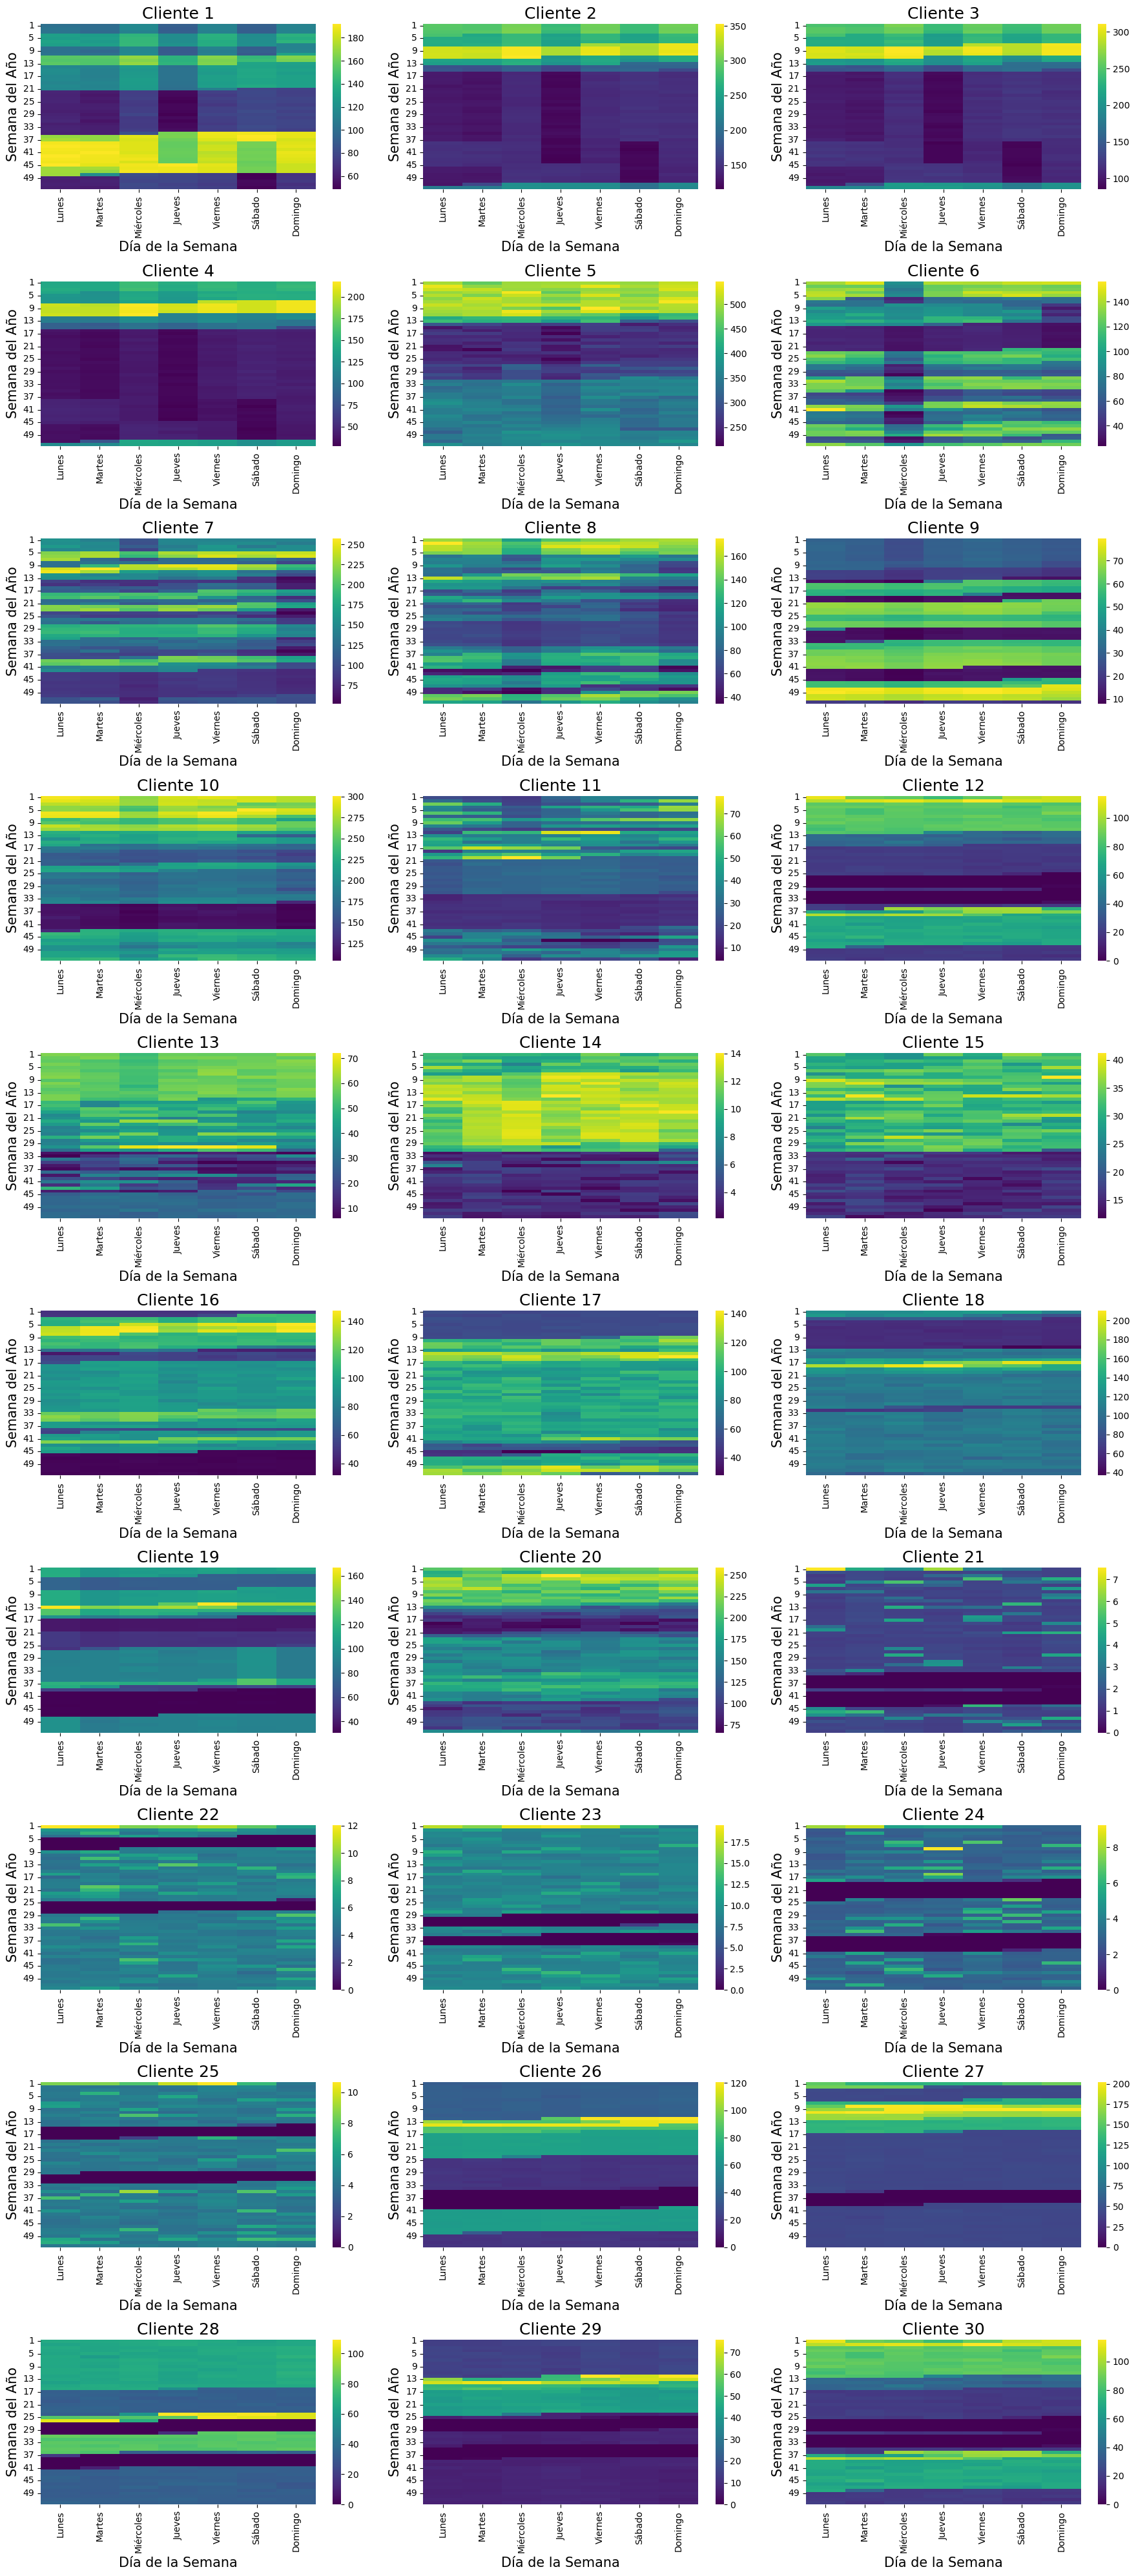

In [17]:
#Realiza un gráfico con cada cliente, mostrando la suma del consumo de energía aparente por año
# Preparar los datos en un solo paso
energia_por_semana = df_resultado.groupby(['Cliente_ID', 'Semana', 'Dia_Semana_Num']).agg({'Apparent_energy': 'sum'}).unstack(level='Dia_Semana_Num')

# Nombres de los días de la semana
dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']

# Lista de semanas a graficar
semanas = range(1, 53)  # Semanas del año

# Obtener una lista de todos los clientes y ordenarla
clientes = sorted(df_resultado['Cliente_ID'].unique())

# Configurar los subplots: 3 gráficos por fila
n_cols = 3
n_rows = (len(clientes) + n_cols - 1) // n_cols  # Calcular cuántas filas se necesitan

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
axes = axes.flatten()  # Aplanar el array para facilitar la iteración

for i, cliente in enumerate(clientes):
    data_cliente = energia_por_semana.loc[cliente]
    data_cliente = data_cliente.reindex(semanas, fill_value=0)  # Asegurar que todas las semanas estén presentes

    ax = sns.heatmap(data_cliente, cmap='viridis', linewidths=0, xticklabels=dias, ax=axes[i])
    ax.set_title(f'Cliente {cliente}', fontsize=18)
    ax.set_xlabel('Día de la Semana',fontsize=15)
    ax.set_ylabel('Semana del Año',fontsize=15)

    # Ajustar los ticks del eje Y para mostrar cada 4 semanas
    ax.set_yticks([x-0.5 for x in range(1, 53, 4)])  # -0.5 para centrar el label entre las celdas
    ax.set_yticklabels(range(1, 53, 4))  # Etiquetas de las semanas

# Desactivar ejes sobrantes si hay menos clientes que subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

Dentro de los principales hallazgos se encuentran:

- Los análisis del consumo energético con los mapas de calor revelan patrones distintivos entre varios grupos de clientes a lo largo del año. Específicamente, los clientes 23, 24 y 25 exhiben un consumo energético elevado durante los primeros siete meses del año, sugiriendo una mayor actividad o demanda operativa en este periodo.
-
En cuanto a la variabilidad semanal del consumo, se observa que para los clientes del 1 al 5, todos pertenecientes al mismo sector, el consumo disminuye significativamente los días jueves. Un patrón similar ocurre con los clientes del 6 al 9, pero en este caso, la reducción se nota los miércoles. Esta tendencia podría reflejar ciclos operativos específicos o políticas de gestión de energía implementadas en estos día
- Contrario a lo que podría esperarse, no se identificaron reducciones en el consumo de electricidad durante los fines de semana en el análisis. Por otro lado, los clientes 16, 17 y 18 mantuvieron niveles de consumo muy consistentes a lo largo del año, con la única excepción de las primeras semanas, donde se observan variaciones menores. Este comportamiento indica una estabilidad en las operaciones y demanda energética de estos clientestes.


### MODELOS DESCRIPTIVOS
##### RANGO INTERCUARTÍLICO

In [18]:
# Agrupar la data por día y sumar la energía aparente
df_resultado_diario = df_resultado.groupby(['Cliente_ID', df_resultado['Fecha'].dt.date]).agg({'Apparent_energy': 'sum'}).reset_index()

# Calcular el IQR y los umbrales de valores atípicos por cliente
Q1 = df_resultado_diario.groupby('Cliente_ID')['Apparent_energy'].quantile(0.25)
Q3 = df_resultado_diario.groupby('Cliente_ID')['Apparent_energy'].quantile(0.75)
IQR = Q3 - Q1

# Diccionario para guardar los clientes con anomalías en cualquier umbral
clientes_anomalias = {}

# Límites de outlier de 1.5, 3, 4.5
outlier_limits = [1.5, 3, 4.5]

# Diccionarios para guardar los clientes con anomalías para cada umbral
clientes_anomalias_1_5 = []
clientes_anomalias_3 = []
clientes_anomalias_4_5 = []

# Función para llenar las listas según el umbral
def fill_outlier_lists(cliente, umbral, lista):
    dias_anomalias = df_resultado_diario[
        (df_resultado_diario['Cliente_ID'] == cliente) &
        (df_resultado_diario['Apparent_energy'] < umbral)
    ]
    if not dias_anomalias.empty and cliente not in lista:
        lista.append(cliente)

# Aplicar los umbrales
for cliente in df_resultado_diario['Cliente_ID'].unique():
    umbral_inferior_1_5 = Q1[cliente] - 1.5 * IQR[cliente]
    umbral_inferior_3 = Q1[cliente] - 3 * IQR[cliente]
    umbral_inferior_4_5 = Q1[cliente] - 4.5 * IQR[cliente]

    fill_outlier_lists(cliente, umbral_inferior_1_5, clientes_anomalias_1_5)
    fill_outlier_lists(cliente, umbral_inferior_3, clientes_anomalias_3)
    fill_outlier_lists(cliente, umbral_inferior_4_5, clientes_anomalias_4_5)

# Resultados
print(f' Utilizando un threshold de 1.5 * IQR los clientes con anomalías son {clientes_anomalias_1_5}')
print(f' Utilizando un threshold de 3 * IQR los clientes con anomalías son {clientes_anomalias_3}')
print(f' Utilizando un threshold de 4.5 * IQR los clientes con anomalías son {clientes_anomalias_4_5}')

 Utilizando un threshold de 1.5 * IQR los clientes con anomalías son [1, 2, 3, 4, 5, 7, 8, 9, 13, 15, 21, 22, 23, 24, 25, 27, 28, 29]
 Utilizando un threshold de 3 * IQR los clientes con anomalías son [1, 2, 3, 4, 9, 15, 21, 22, 23, 24, 25, 27, 28, 29]
 Utilizando un threshold de 4.5 * IQR los clientes con anomalías son [1, 2, 3, 9, 22, 23, 25, 27, 28]


In [19]:
df_resultado_diario

Cliente_ID       Fecha  Apparent_energy
0               1  2021-01-01        33.822878
1               1  2021-01-02        41.322765
2               1  2021-01-03        39.722672
3               1  2021-01-04        41.409175
4               1  2021-01-05        37.709285
...           ...         ...              ...
19322          30  2022-04-17        18.987471
19323          30  2022-04-18        18.907934
19324          30  2022-04-19        20.351448
19325          30  2022-04-20        17.853062
19326          30  2022-04-21        12.176054

[19327 rows x 3 columns]

In [20]:
# Generando un dataframe con los datos anómalos
# Agregar columnas para las anomalías en cada umbral
df_resultado_diario['anomalia_1_5_IQR'] = 0
df_resultado_diario['anomalia_3_IQR'] = 0
df_resultado_diario['anomalia_4_5_IQR'] = 0

for cliente in df_resultado_diario['Cliente_ID'].unique():
    umbral_inferior_1_5 = Q1[cliente] - 1.5 * IQR[cliente]
    umbral_inferior_3 = Q1[cliente] - 3 * IQR[cliente]
    umbral_inferior_4_5 = Q1[cliente] - 4.5 * IQR[cliente]

    # Marcar anomalías
    df_resultado_diario.loc[(df_resultado_diario['Cliente_ID'] == cliente) & (df_resultado_diario['Apparent_energy'] < umbral_inferior_1_5), 'anomalia_1_5_IQR'] = 1
    df_resultado_diario.loc[(df_resultado_diario['Cliente_ID'] == cliente) & (df_resultado_diario['Apparent_energy'] < umbral_inferior_3), 'anomalia_3_IQR'] = 1
    df_resultado_diario.loc[(df_resultado_diario['Cliente_ID'] == cliente) & (df_resultado_diario['Apparent_energy'] < umbral_inferior_4_5), 'anomalia_4_5_IQR'] = 1

df_resultado_diario.head()

Cliente_ID       Fecha  Apparent_energy  anomalia_1_5_IQR  anomalia_3_IQR  \
0           1  2021-01-01        33.822878                 0               0   
1           1  2021-01-02        41.322765                 0               0   
2           1  2021-01-03        39.722672                 0               0   
3           1  2021-01-04        41.409175                 0               0   
4           1  2021-01-05        37.709285                 0               0   

   anomalia_4_5_IQR  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0

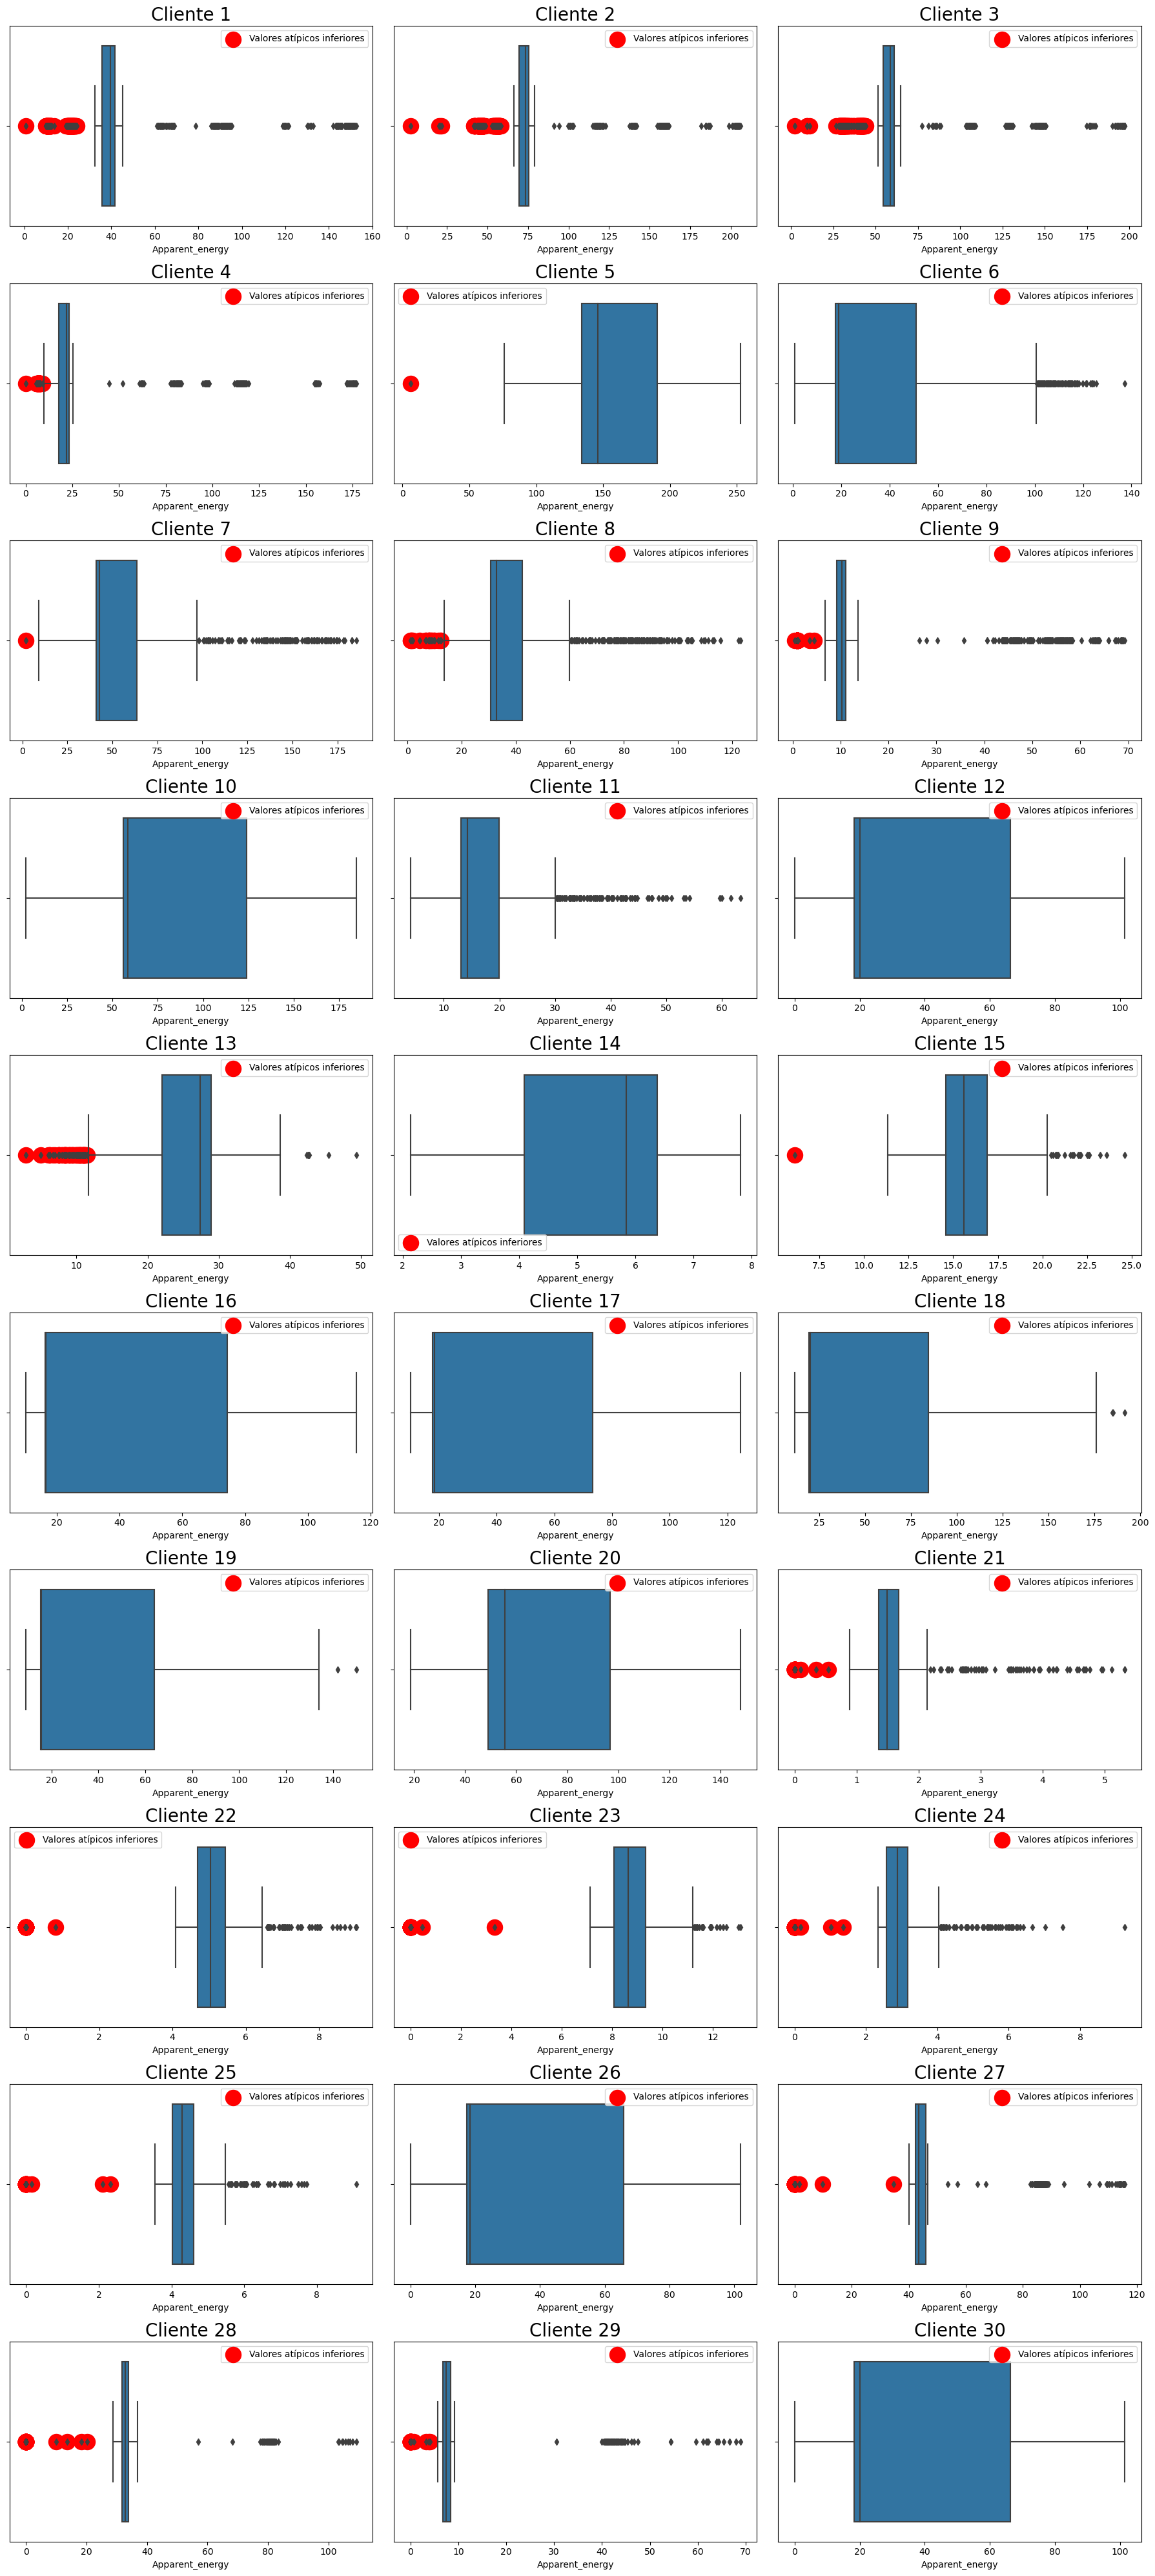

In [21]:
# Agrupar la data por día y sumar la energía aparente
#df_resultado_diario = df_resultado.groupby(['Cliente_ID', df_resultado['Fecha'].dt.date]).agg({'Apparent_energy': 'sum'}).reset_index()

# Calcular el IQR y los umbrales de valores atípicos por cliente
Q1 = df_resultado_diario.groupby('Cliente_ID')['Apparent_energy'].quantile(0.25)
Q3 = df_resultado_diario.groupby('Cliente_ID')['Apparent_energy'].quantile(0.75)
IQR = Q3 - Q1
umbral_inferior = Q1 - 1.5 * IQR

# Número de columnas para los subplots
n_cols = 3
n_rows = (len(df_resultado_diario['Cliente_ID'].unique()) + n_cols - 1) // n_cols  # Calcula el número necesario de filas

# Preparar una figura para los plots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6 * n_cols, 4 * n_rows), squeeze=False)  # Ajustar el tamaño

# Generar un boxplot por cliente y resaltar valores atípicos inferiores
for idx, cliente_id in enumerate(sorted(df_resultado_diario['Cliente_ID'].unique())):
    ax = axes[idx // n_cols, idx % n_cols]  # Determinar el subplot actual
    cliente_data = df_resultado_diario[df_resultado_diario['Cliente_ID'] == cliente_id]
    sns.boxplot(x='Apparent_energy', data=cliente_data, ax=ax)
    ax.set_title(f'Cliente {cliente_id}',fontsize=20)

    # Resaltar valores atípicos por debajo del umbral
    valores_atipicos = cliente_data[cliente_data['Apparent_energy'] < umbral_inferior[cliente_id]]
    ax.scatter(valores_atipicos['Apparent_energy'], np.zeros_like(valores_atipicos['Apparent_energy']), color='red', s=300, label='Valores atípicos inferiores')  # Aumentar tamaño y añadir borde
    ax.legend()

# Ajustar la disposición y mostrar la gráfica
plt.tight_layout()
plt.show()

##### MODELO Z-SCORE

In [22]:
# Conociendo los clientes que presentan anomalías segun los thresholds 1.5, 3 y 4.5
# Función para calcular la desviación absoluta media (MAD)
def mad(arr):
    return np.abs(arr - np.median(arr)).mean()

def detectar_anomalias(dataframe, outlier_limits):
    resultados = {limit: [] for limit in outlier_limits}  # Diccionario para almacenar los resultados por umbral
    clientes = dataframe['Cliente_ID'].unique()  # Obtener los clientes únicos

    for cliente_id in clientes:
        # Filtrar los datos por cliente y calcular la suma diaria de energía
        data_cliente = dataframe[dataframe['Cliente_ID'] == cliente_id]
        data_diaria = data_cliente.resample('D', on='Fecha').sum()

        # Calcular la mediana y MAD
        median_val = np.median(data_diaria['Apparent_energy'])
        mad_val = mad(data_diaria['Apparent_energy'])

        # Chequear cada umbral
        for threshold in outlier_limits:
            # Calcular el límite inferior
            limite_inferior = median_val - threshold * mad_val

            # Identificar días donde el consumo está por debajo del límite inferior
            anomalias = data_diaria[data_diaria['Apparent_energy'] < limite_inferior]

            if not anomalias.empty:
                resultados[threshold].append(cliente_id)

    return resultados

# Límites de umbral para calcular
outlier_limits = [1.5, 3, 4.5]
resultados_anomalias = detectar_anomalias(df_resultado, outlier_limits)
resultados_anomalias

{1.5: [1, 10, 11, 13, 14, 15, 2, 20, 21, 22, 23, 24, 25, 27, 28, 3, 5, 7, 8],
 3: [13, 14, 15, 2, 22, 23, 25, 28, 3, 5],
 4.5: [13, 15, 23, 5]}

In [23]:
df_resultado_diario.head()

Cliente_ID       Fecha  Apparent_energy  anomalia_1_5_IQR  anomalia_3_IQR  \
0           1  2021-01-01        33.822878                 0               0   
1           1  2021-01-02        41.322765                 0               0   
2           1  2021-01-03        39.722672                 0               0   
3           1  2021-01-04        41.409175                 0               0   
4           1  2021-01-05        37.709285                 0               0   

   anomalia_4_5_IQR  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0

In [24]:
# Generando un dataframe con los datos anómalos de z-score
# Calcular el Z-score para la energía aparente diaria para cada cliente
df_resultado_diario['z_score'] = df_resultado_diario.groupby('Cliente_ID')['Apparent_energy'].transform(lambda x: zscore(x, ddof=1))

# Establecer umbrales de Z-score para detectar anomalías inferiores
thresholds = [1.5, 3, 4.5]

# Crear columnas para cada umbral, marcando con 1 las anomalías y 0 lo contrario
for threshold in thresholds:
    column_name = f'anomalia_{threshold}_ZS'
    df_resultado_diario[column_name] = (df_resultado_diario['z_score'] < -threshold).astype(int)
df_resultado_diario.head()

Cliente_ID       Fecha  Apparent_energy  anomalia_1_5_IQR  anomalia_3_IQR  \
0           1  2021-01-01        33.822878                 0               0   
1           1  2021-01-02        41.322765                 0               0   
2           1  2021-01-03        39.722672                 0               0   
3           1  2021-01-04        41.409175                 0               0   
4           1  2021-01-05        37.709285                 0               0   

   anomalia_4_5_IQR   z_score  anomalia_1.5_ZS  anomalia_3_ZS  anomalia_4.5_ZS  
0                 0 -0.493137                0              0                0  
1                 0 -0.289609                0              0                0  
2                 0 -0.333032                0              0                0  
3                 0 -0.287264                0              0                0  
4                 0 -0.387670                0              0                0

In [25]:
df_resultado_diario[df_resultado_diario['anomalia_1.5_ZS'] != 0]['Cliente_ID'].unique()

array([ 2,  3,  5,  7,  8, 10, 13, 14, 15, 20, 22, 23, 24, 25, 27, 28],
      dtype=int64)

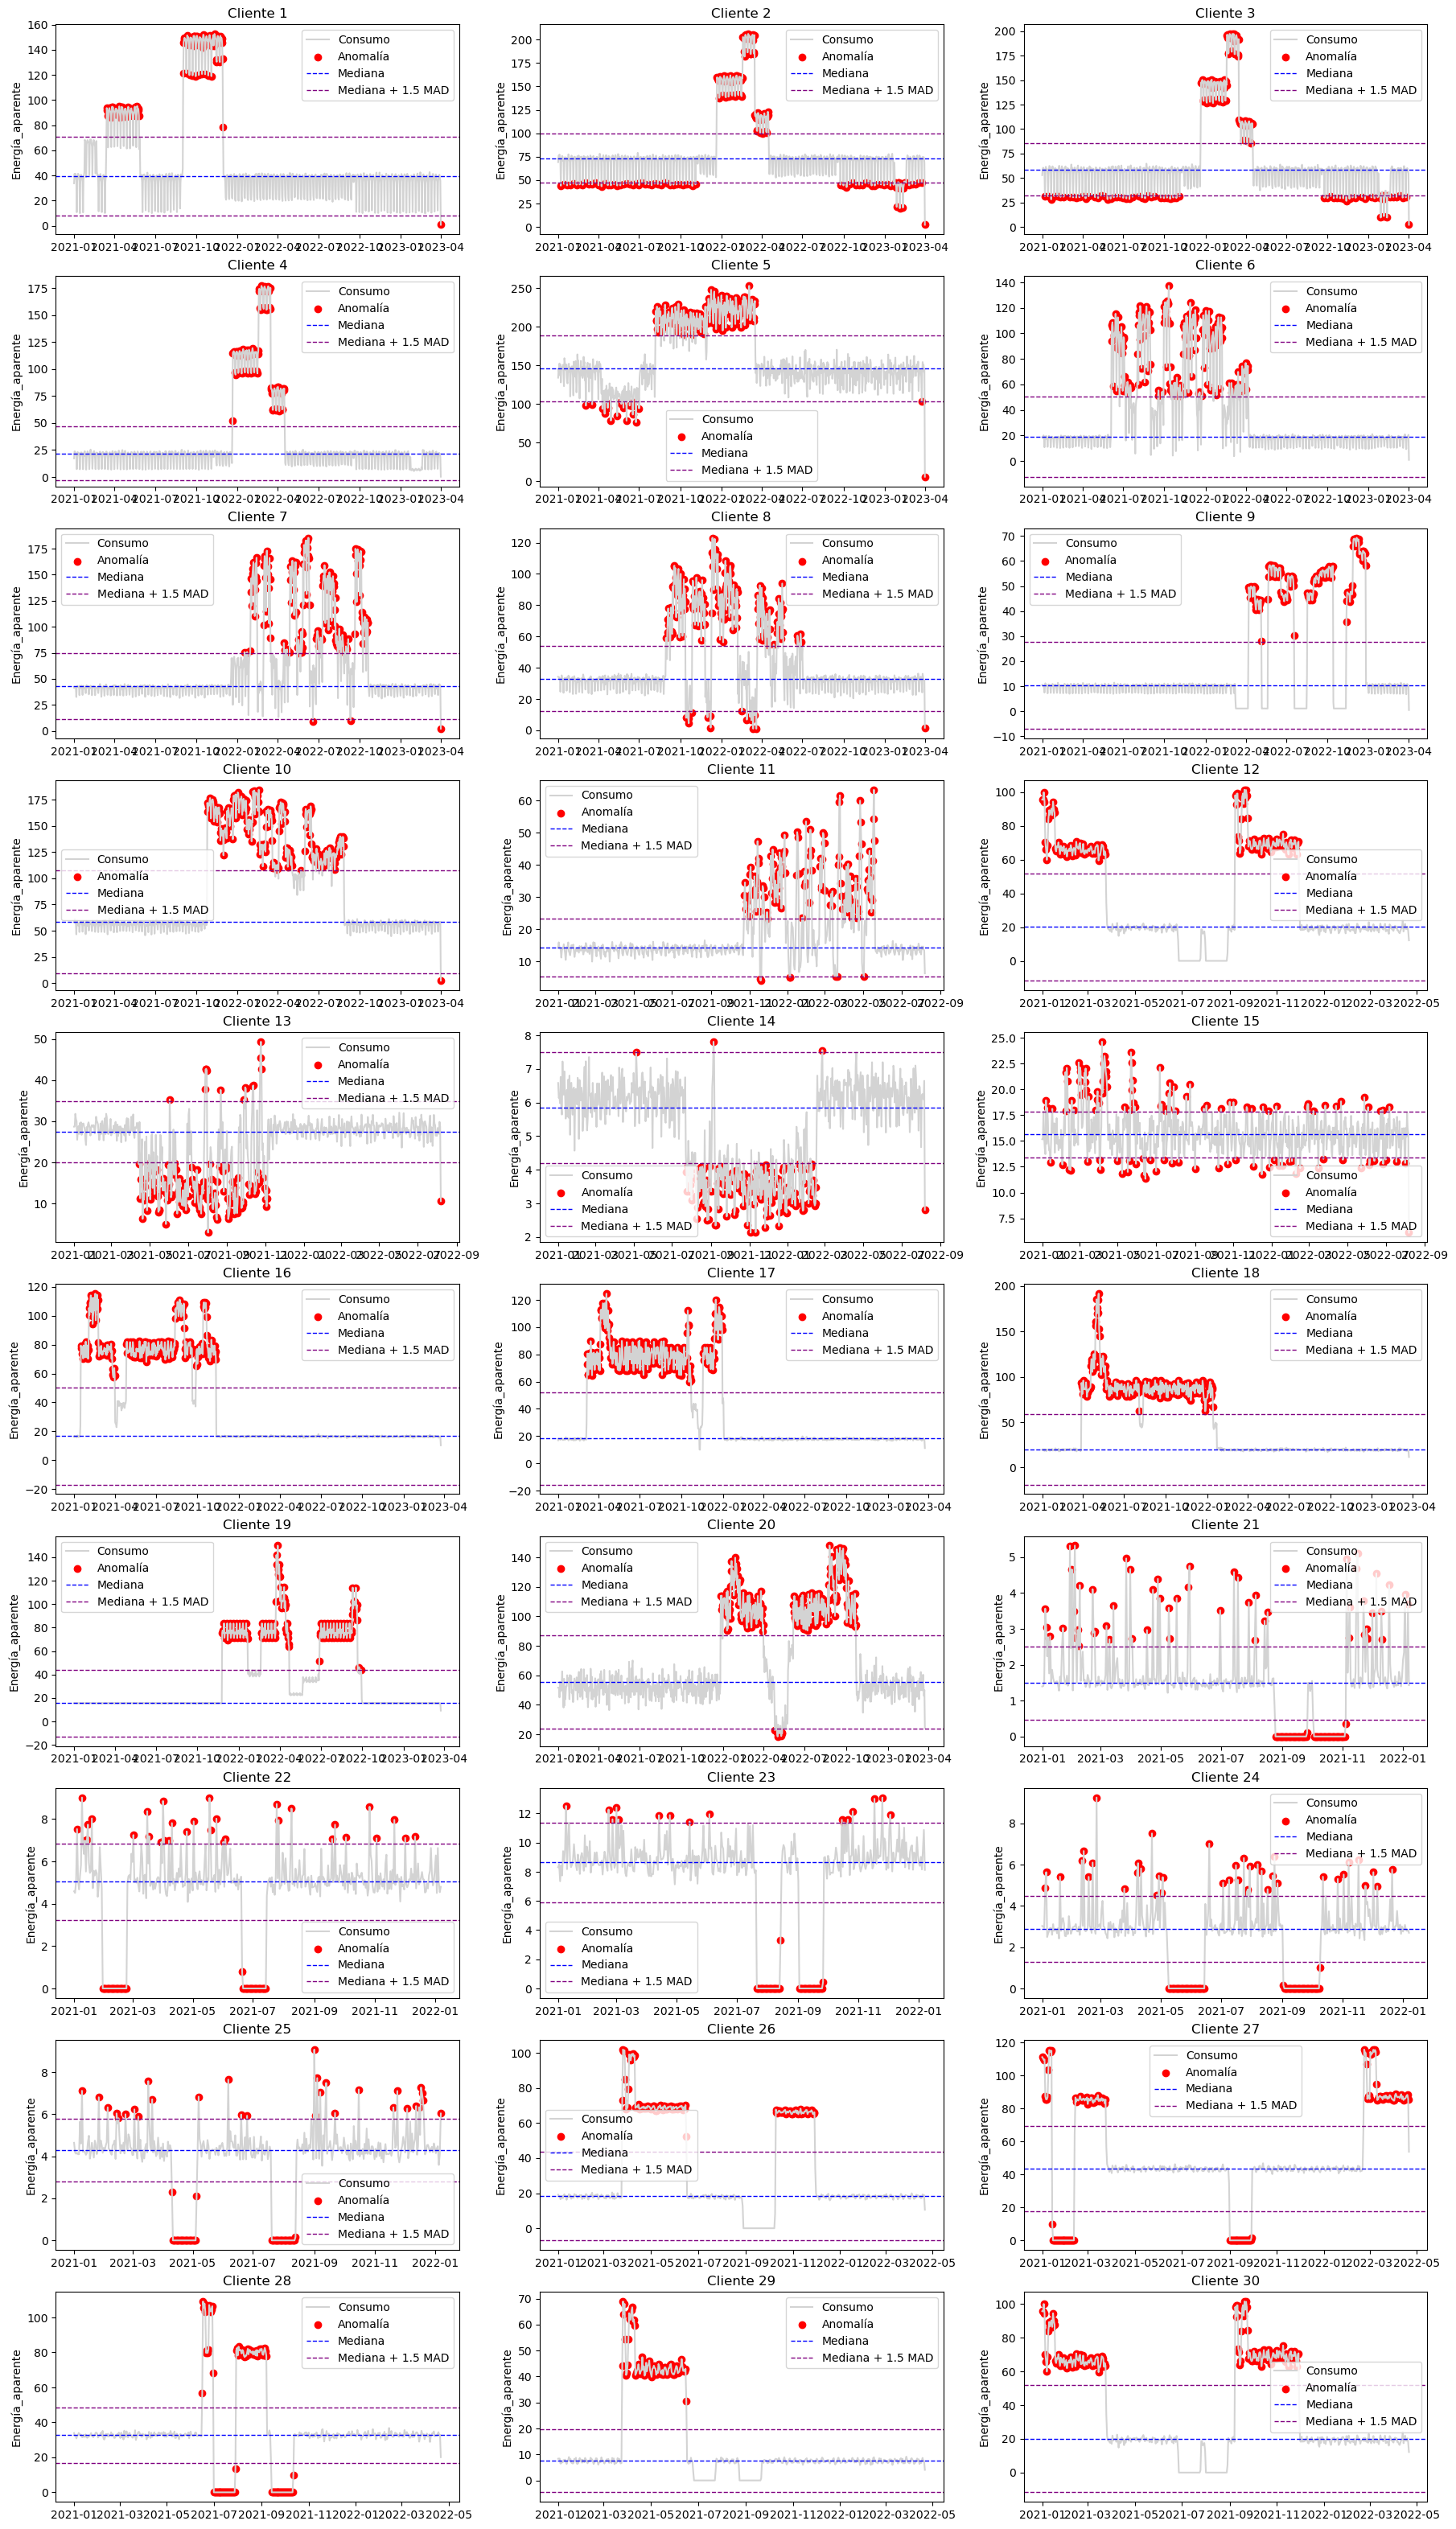

In [26]:
#Graficando los z-score con un threshold de 1.5
threshold = 1.5  # Umbral de Z-score para considerar una anomalía

# Preparar la figura para los subplots
n_cols = 3  # Número de columnas por fila
clientes = sorted(df_resultado['Cliente_ID'].unique())
n_rows = (len(clientes) + n_cols - 1) // n_cols  # Calcular el número de filas necesario
fig, axes = plt.subplots(n_rows, n_cols, figsize=(22, 4 * n_rows), squeeze=False)  # Ajustar tamaño de cada subplot

# Iterar sobre cada cliente y crear los subplots correspondientes
for idx, cliente_id in enumerate(clientes):
    ax = axes[idx // n_cols, idx % n_cols]  # Determinar el subplot actual

    # Filtrar el DataFrame por el Cliente_ID actual
    data = df_resultado[df_resultado['Cliente_ID'] == cliente_id][['Fecha', 'Apparent_energy']].set_index('Fecha')
    data = data.resample('D').sum()  # Agrupar los datos por día y sumar

    # Calcular Z-score para la columna 'Apparent_energy'
    data['z_score'] = zscore(data['Apparent_energy'])

    # Calcular la mediana y MAD
    median_val = np.median(data['Apparent_energy'])
    mad_val = mad(data['Apparent_energy'])

    # Identificar anomalías
    data['anom'] = data['Apparent_energy'].apply(lambda x: x < median_val - (threshold * mad_val) or x > median_val + (threshold * mad_val))

    # Filtrar los datos anómalos para la gráfica
    anomalous_data = data[data['anom']]

    # Graficar resultados
    ax.plot(data.index, data['Apparent_energy'], label='Consumo', color='lightgray')
    ax.scatter(anomalous_data.index, anomalous_data['Apparent_energy'], c='red', label='Anomalía', marker='o')

    # Graficar líneas de mediana y MAD con umbral
    ax.axhline(median_val, color='blue', linestyle='--', linewidth=1, label='Mediana')
    ax.axhline(median_val + mad_val * threshold, color='purple', linestyle='--', linewidth=1, label=f'Mediana + {threshold} MAD')
    ax.axhline(median_val - mad_val * threshold, color='purple', linestyle='--', linewidth=1)

    # Configurar el subplot
    ax.set_title(f'Cliente {cliente_id}')
    ax.set_ylabel('Energía_aparente')
    ax.legend()




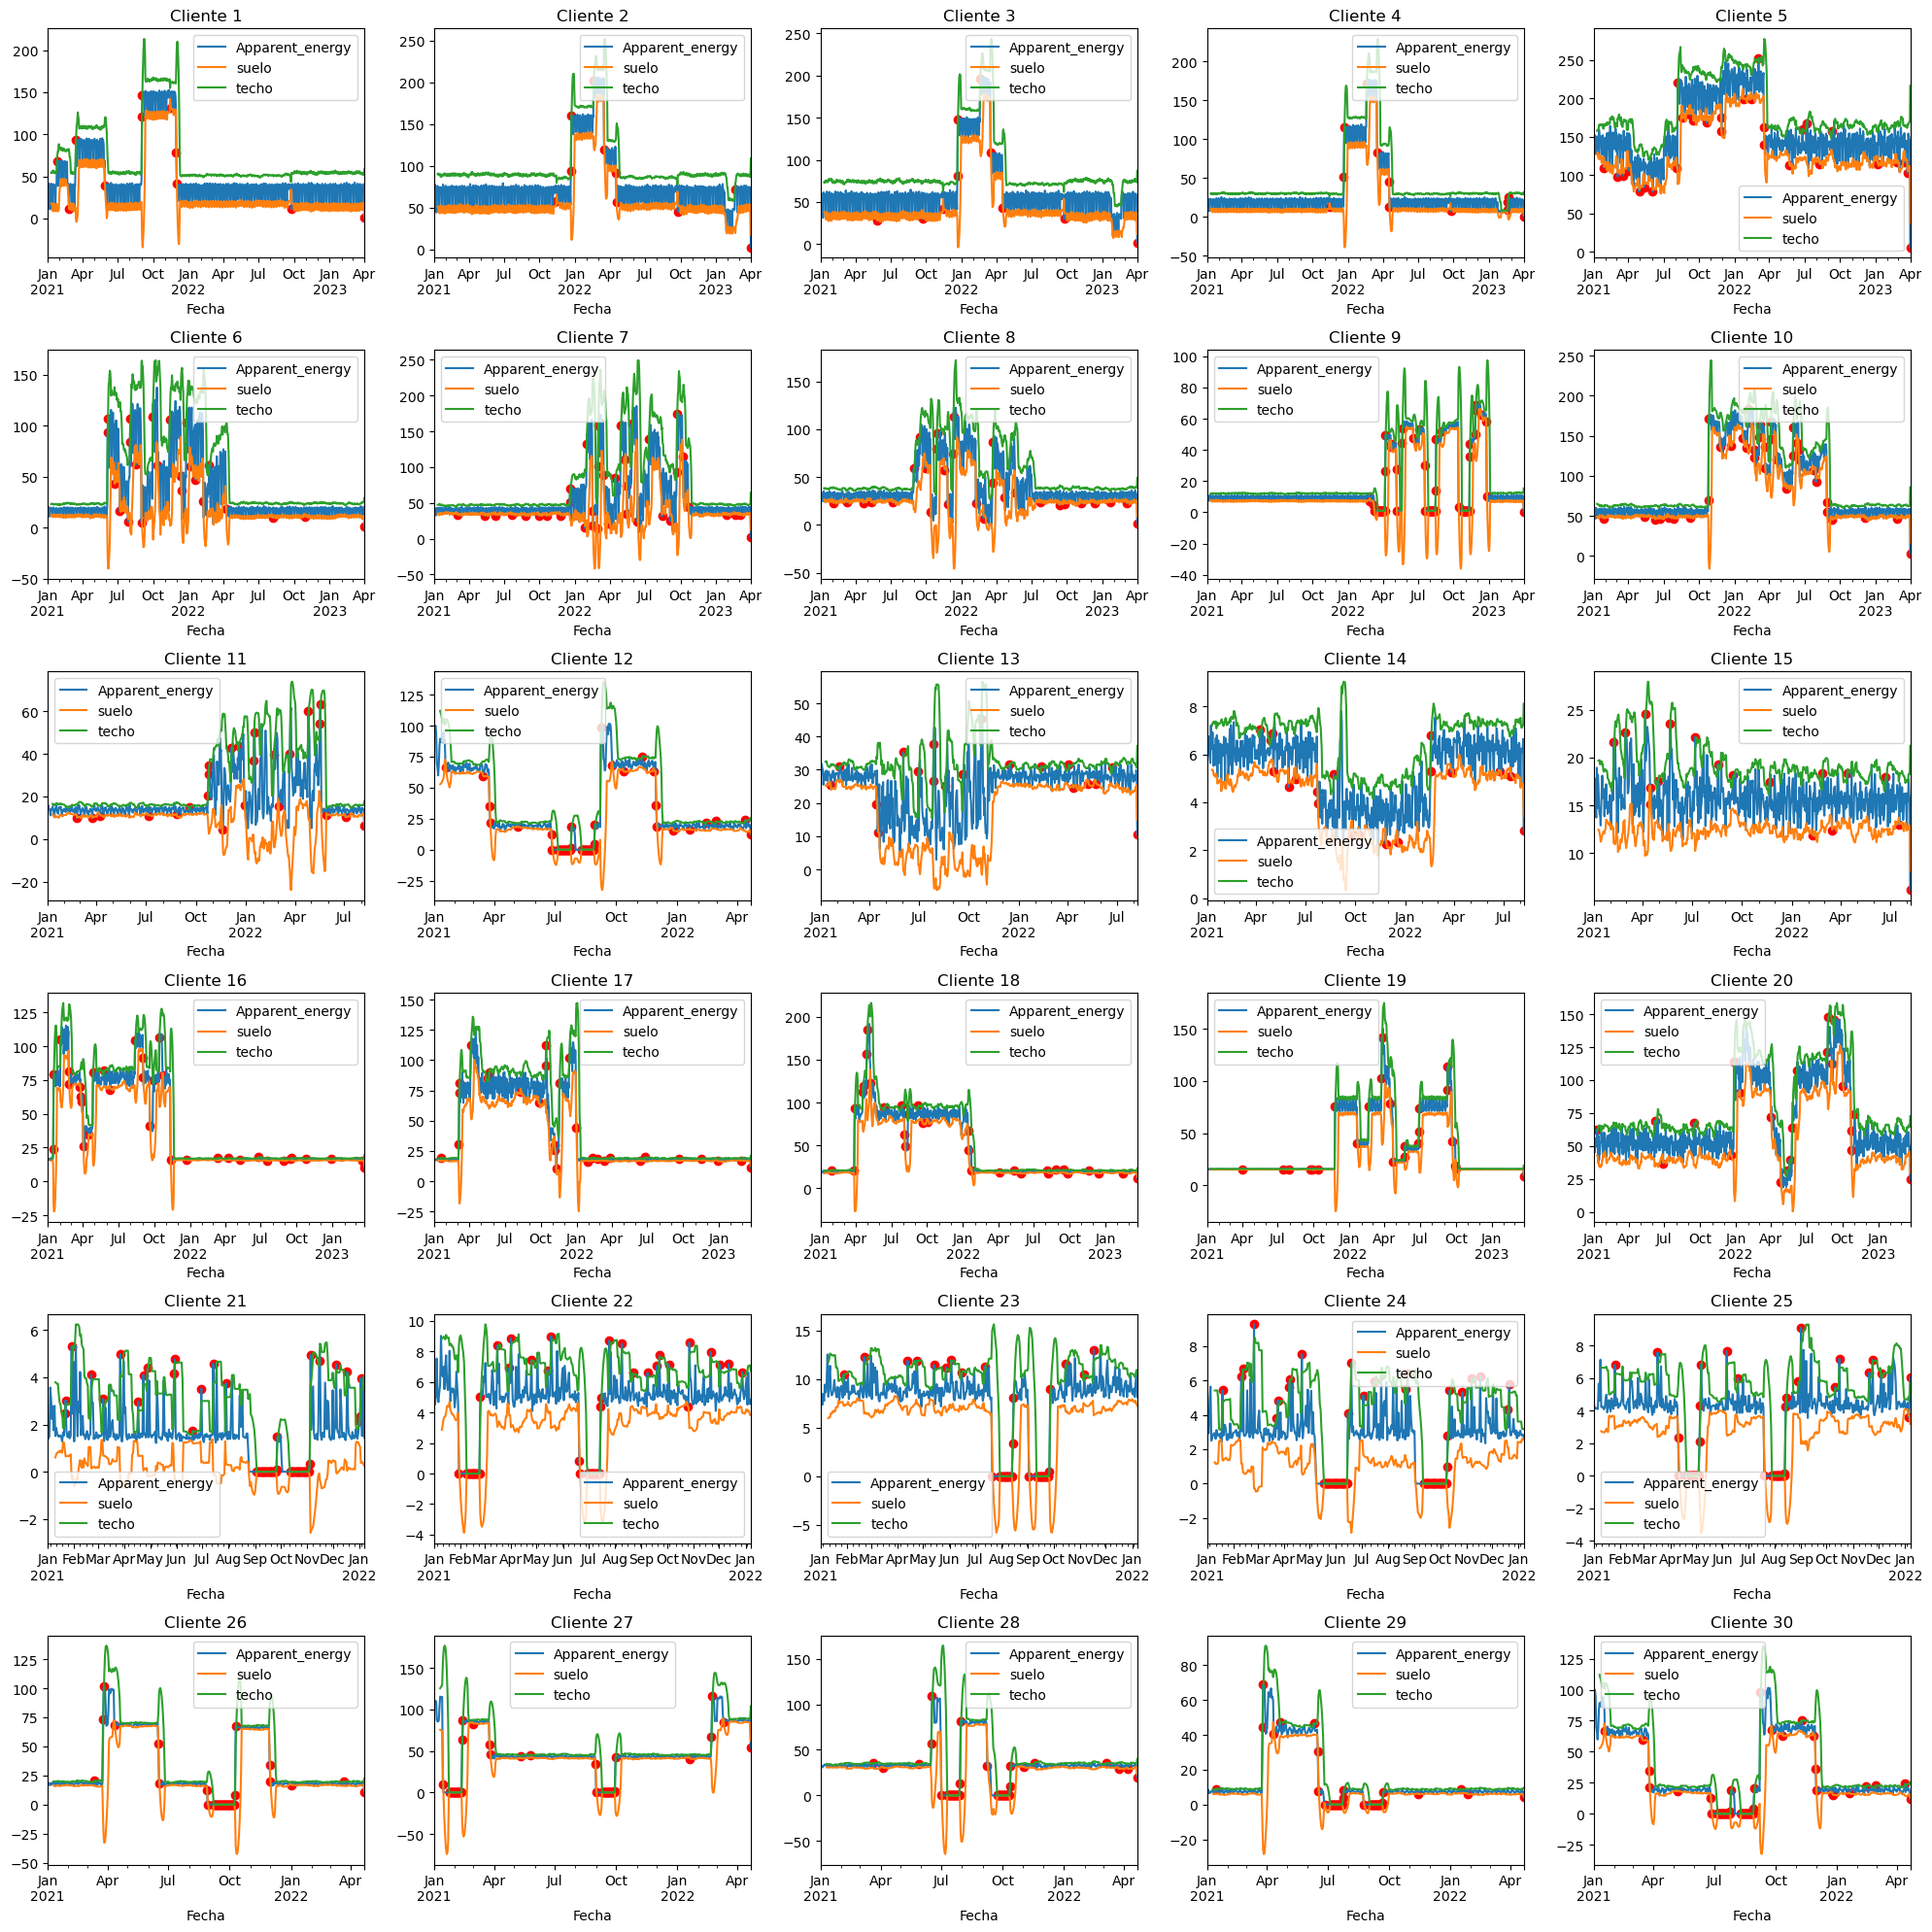

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20, 20)  # Ajusta el tamaño de la figura para acomodar múltiples gráficos
wind = 10
sigma = 2

# Número de gráficos por fila
num_graphs_per_row = 5
num_clients = len(df_resultado['Cliente_ID'].unique())
num_rows = (num_clients + num_graphs_per_row - 1) // num_graphs_per_row

fig, axes = plt.subplots(num_rows, num_graphs_per_row, squeeze=False)

# Para cada Cliente_ID, crea un conjunto de gráficas
for i, cliente_id in enumerate(sorted(df_resultado['Cliente_ID'].unique())):
    ax = axes[i // num_graphs_per_row, i % num_graphs_per_row]

    # Filtra el DataFrame por el Cliente_ID actual
    data = df_resultado[df_resultado['Cliente_ID'] == cliente_id][['Fecha', 'Apparent_energy']].set_index('Fecha')

    # Agrupa los datos por día y suma la energía aparente por día
    data = data.resample('D').sum()

    data["suelo"] = data['Apparent_energy'].rolling(window=wind).mean() - (sigma * data['Apparent_energy'].rolling(window=wind).std())
    data["techo"] = data['Apparent_energy'].rolling(window=wind).mean() + (sigma * data['Apparent_energy'].rolling(window=wind).std())

    data.plot(ax=ax)

    data["anom"] = data.apply(
        lambda row: row["Apparent_energy"] if (row["Apparent_energy"] <= row["suelo"] or row["Apparent_energy"] >= row["techo"]) else None,
        axis=1
    )

    ax.set_title(f'Cliente {cliente_id}')
    ax.scatter(data.index, data["anom"], c='red', marker='o')

# Eliminar los ejes vacíos
for j in range(i + 1, num_rows * num_graphs_per_row):
    fig.delaxes(axes[j // num_graphs_per_row, j % num_graphs_per_row])

plt.tight_layout()
plt.show()


In [28]:
# Clasificando a los clientes en consumo alto, medio o bajo según su promedio del último año

# Calculando el promedio de consumo por cliente
consumo_promedio = df_resultado_diario.groupby('Cliente_ID')['Apparent_energy'].mean()

#Definición de los umbrales usando percentiles
percentiles = df_resultado_diario['Apparent_energy'].quantile([0.333, 0.667]).to_list()

# Función para clasificar el consumo
def clasificar_consumo(x):
    if x <= percentiles[0]:
        return 'Bajo'
    elif x <= percentiles[1]:
        return 'Medio'
    else:
        return 'Alto'

clasificacion = consumo_promedio.apply(clasificar_consumo)
print(f'Se clasifica como consumo bajo a aquellos clientes con una energía aparente promedio menor a {round(percentiles [0],3)}')
print(f'Se clasifica como consumo medio a aquellos clientes con una energía aparente entre {round(percentiles [0],3)} y {round(percentiles [1],3)}')
print(f'Se clasifica como consumo alto a aquellos clientes con una energía aparente promedio mayor a {round(percentiles [1],3)}')

Se clasifica como consumo bajo a aquellos clientes con una energía aparente promedio menor a 17.336
Se clasifica como consumo medio a aquellos clientes con una energía aparente entre 17.336 y 48.406
Se clasifica como consumo alto a aquellos clientes con una energía aparente promedio mayor a 48.406


#### UNIÓN DE DATASETS PARA GRÁFICOS DESCRIPTIVOS

In [29]:
#Subir el archivo de excel con las características de los clientes
df_clientes = df_resultado
df_clientes.head()

Fecha  Active_energy  Reactive_energy  Voltaje_FA  Voltaje_FC  \
0 2021-01-01 00:00:00       0.357841         0.282788  455.139171  510.561002   
1 2021-01-01 01:00:00       0.372264         0.431377  469.978787  469.917178   
2 2021-01-01 02:00:00       1.044687         0.338626  468.721120  546.949147   
3 2021-01-01 03:00:00       0.566425         0.495791  452.329255  444.122989   
4 2021-01-01 04:00:00       1.080556         0.472018  513.477596  535.463719   

   Cliente_ID                                   Sector_Economico  \
0           1  Elaboración de cacao y chocolate y de producto...   
1           1  Elaboración de cacao y chocolate y de producto...   
2           1  Elaboración de cacao y chocolate y de producto...   
3           1  Elaboración de cacao y chocolate y de producto...   
4           1  Elaboración de cacao y chocolate y de producto...   

   Apparent_energy  Hora  Dia_Semana_Num  Semana  Dia_Anho_Num  Mes  Anho  
0         0.456091     0               4      53             1    1  2021  
1         0.569796     1               4      53             1    1  2021  
2         1.098198     2               4      53             1    1  2021  
3         0.752759     3               4      53             1    1  2021  
4         1.179154     4               4      53             1    1  2021

In [30]:
# Realizando un merge (unión) de los DataFrames en la columna 'Cliente_ID'
descriptivas = pd.merge(pd.merge(df_clientes, clasificacion, on='Cliente_ID', how='outer'),
                     df_sector, on='Cliente_ID', how='outer')
descriptivas.head()

Fecha  Active_energy  Reactive_energy  Voltaje_FA  Voltaje_FC  \
0 2021-01-01 00:00:00       0.357841         0.282788  455.139171  510.561002   
1 2021-01-01 01:00:00       0.372264         0.431377  469.978787  469.917178   
2 2021-01-01 02:00:00       1.044687         0.338626  468.721120  546.949147   
3 2021-01-01 03:00:00       0.566425         0.495791  452.329255  444.122989   
4 2021-01-01 04:00:00       1.080556         0.472018  513.477596  535.463719   

   Cliente_ID                                 Sector_Economico_x  \
0           1  Elaboración de cacao y chocolate y de producto...   
1           1  Elaboración de cacao y chocolate y de producto...   
2           1  Elaboración de cacao y chocolate y de producto...   
3           1  Elaboración de cacao y chocolate y de producto...   
4           1  Elaboración de cacao y chocolate y de producto...   

   Apparent_energy_x  Hora  Dia_Semana_Num  Semana  Dia_Anho_Num  Mes  Anho  \
0           0.456091     0               4      53             1    1  2021   
1           0.569796     1               4      53             1    1  2021   
2           1.098198     2               4      53             1    1  2021   
3           0.752759     3               4      53             1    1  2021   
4           1.179154     4               4      53             1    1  2021   

  Apparent_energy_y                                 Sector_Economico_y  
0              Alto  Elaboración de cacao y chocolate y de producto...  
1              Alto  Elaboración de cacao y chocolate y de producto...  
2              Alto  Elaboración de cacao y chocolate y de producto...  
3              Alto  Elaboración de cacao y chocolate y de producto...  
4              Alto  Elaboración de cacao y chocolate y de producto...

#### EXPORTACIÓN LOS EXCELES

In [31]:
#Exportando excel con características descriptivas

# Nombre del archivo
filename = 'descriptivas.csv'

# Carpeta donde quieres guardar tus archivos
folder_name = 'Datos'

# Verificar si la carpeta existe, si no, crearla
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# Ruta completa para guardar el archivo
file_path = os.path.join(folder_name, filename)

# Guardar el DataFrame en un archivo CSV en la carpeta especificada
descriptivas.to_csv(file_path, index=False)

# Imprimir el path para confirmación
print(f'Archivo guardado en: {file_path}')


# Exporta a un formato CSV los datos del consumo aparente por día

# Nombre del archivo
filename = 'consumo_diario.csv'

# Ruta completa para guardar el archivo
file_path = os.path.join(folder_name, filename)

# Guardar el DataFrame en un archivo CSV en la carpeta especificada
df_resultado_diario.to_csv(file_path, index=False)

# Imprimir el path para confirmación
print(f'Archivo guardado en: {file_path}')



Archivo guardado en: Datos\descriptivas.csv
Archivo guardado en: Datos\consumo_diario.csv


In [32]:
# Creación de las características ficticias descriptivas

# Configuración inicial de Faker para simular datos en español de España.
fake_es = Faker('es_ES')

# Ciudades del sur de Perú
ciudades_sur_peru = [
    "Arequipa", "Cusco", "Puno", "Tacna", "Moquegua", "Ilo",
    "Juliaca", "Mollendo", "Sicuani", "Ilave", "Yunguyo", "Desaguadero"
]

def generate_peruvian_phone_number():
    """
    Genera un número de teléfono ficticio de Perú.

    Retorna un string que representa un número de teléfono en formato peruano,
    empezando con el código de país +51 y seguido de un número de celular que
    comienza con 9 y tiene 8 dígitos en total.
    """
    # Concatena el código de país con un número generado aleatoriamente.
    return "+51 " + fake_es.random_element(elements=("9",)) + str(fake_es.random_number(digits=8))

def generate_peruvian_address(city):
    """
    Genera una dirección ficticia dentro de una ciudad especificada en Perú.

    Parámetros:
    city (str): Nombre de la ciudad para incluir en la dirección.

    Retorna un string que representa una dirección ficticia en la ciudad dada,
    completando con el nombre de la ciudad y el país.
    """
    # Combina una dirección de calle aleatoria con el nombre de la ciudad y el país.
    return fake_es.street_address() + ", " + city + ", Perú"

# Generación de listas de datos ficticios para varias columnas.
nombres = [fake_es.name() for _ in range(30)]  # Nombres completos de personas.
numeros_cliente = [fake_es.unique.random_int(min=1000, max=9999) for _ in range(30)]  # Números únicos de cliente.
ciudades = [fake_es.random.choice(ciudades_sur_peru) for _ in range(30)]  # Ciudades aleatorias del sur de Perú.
correos = [fake_es.email() for _ in range(30)]  # Direcciones de correo electrónico.
telefonos = [generate_peruvian_phone_number() for _ in range(30)]  # Números de teléfono en formato peruano.
direcciones = [generate_peruvian_address(city) for city in ciudades]  # Direcciones completas en ciudades específicas.

# Creación de un diccionario para agrupar todos los datos generados.
data_peru = {
    "Nombre": nombres,
    "Número_Cliente": numeros_cliente,
    "Ciudad": ciudades,
    "Dirección": direcciones,
    "Correo": correos,
    "Teléfono": telefonos
}

# Creación de un DataFrame de pandas para estructurar los datos en formato tabular.
df_ficticios = pd.DataFrame(data_peru)

# Visualización de las primeras cinco filas del DataFrame para verificar los datos.
df_ficticios.head()

Nombre  Número_Cliente   Ciudad  \
0        Martin Mateu Cabello            7620    Tacna   
1           Guiomar del Plana            7703  Yunguyo   
2  Hernán Daniel Mata Bastida            8743  Sicuani   
3     Silvestre Arévalo Farré            7748    Cusco   
4          Maximiano de Checa            3774    Cusco   

                                        Dirección                      Correo  \
0  Alameda Clara Almagro 82 Apt. 70 , Tacna, Perú    pratgraciano@example.com   
1           Calle Maricruz Piña 96, Yunguyo, Perú  donaireeufemia@example.net   
2            Via Xavier Peralta 90, Sicuani, Perú     heliodoro56@example.org   
3            Via Domitila Fajardo 22, Cusco, Perú          pirafa@example.com   
4   Pasaje Juan Pablo Moll 9 Piso 9 , Cusco, Perú       gchamorro@example.net   

        Teléfono  
0   +51 99220577  
1  +51 955869780  
2  +51 932751346  
3  +51 961675268  
4  +51 956864316

#### Modelo Red Neuronal Autoencoder

###### https://www.redalyc.org/journal/3783/378370462015/html/

In [33]:
consumo_clientes = df_resultado[['Cliente_ID', 'Apparent_energy','Fecha']]
consumo_clientes.head()

Cliente_ID  Apparent_energy               Fecha
0           1         0.456091 2021-01-01 00:00:00
1           1         0.569796 2021-01-01 01:00:00
2           1         1.098198 2021-01-01 02:00:00
3           1         0.752759 2021-01-01 03:00:00
4           1         1.179154 2021-01-01 04:00:00

In [34]:
df = consumo_clientes
df['Fecha'] = pd.to_datetime(df['Fecha'])

# Agrupar los datos por día y calcular el consumo total diario
df['Fecha'] = df['Fecha'].dt.date
daily_data = df.groupby(['Cliente_ID', 'Fecha']).agg({'Apparent_energy': 'sum'}).reset_index()

# Normalización
scaler = MinMaxScaler()
daily_data['Apparent_energy_scaled'] = scaler.fit_transform(daily_data[['Apparent_energy']])

# Prepara datos para el autoencoder
data = daily_data[['Apparent_energy_scaled']].values

# Definir y entrenar el autoencoder con capas adicionales
input_dim = data.shape[1]
encoding_dim = 10  # Dimensión del espacio latente (puedes ajustar este valor)
input_layer = Input(shape=(input_dim, ))

# Capas del autoencoder
encoder = Dense(encoding_dim, activation="tanh",
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = BatchNormalization()(encoder)
encoder = Dropout(0.2)(encoder)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
encoder = BatchNormalization()(encoder)
encoder = Dropout(0.2)(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = BatchNormalization()(decoder)
decoder = Dropout(0.2)(decoder)
decoder = Dense(input_dim, activation='relu')(decoder)

# Modelo
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mse')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenamiento del autoencoder
history = autoencoder.fit(data, data,
                          epochs=100,
                          batch_size=32,
                          shuffle=True,
                          validation_split=0.3,
                          verbose=1,
                          callbacks=[early_stopping])



Epoch 1/100
423/423 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.2440 - val_loss: 0.0291
Epoch 2/100
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0781 - val_loss: 0.0291
Epoch 3/100
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0676 - val_loss: 0.0180
Epoch 4/100
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0526 - val_loss: 0.0177
Epoch 5/100
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0451 - val_loss: 0.0059
Epoch 6/100
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0324 - val_loss: 0.0049
Epoch 7/100
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0211 - val_loss: 0.0027
Epoch 8/100
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0138 - val_loss: 0.0020
Epoch 9/100
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0109 - val_loss: 0.0017
Epoch 10/100
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0103 - val_loss: 0.0016
Epoch 11/100
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0094 - val_loss: 0.0012
Epoch 12/100
423/423 ━━━━━━━━━━━━━━━━━━━━

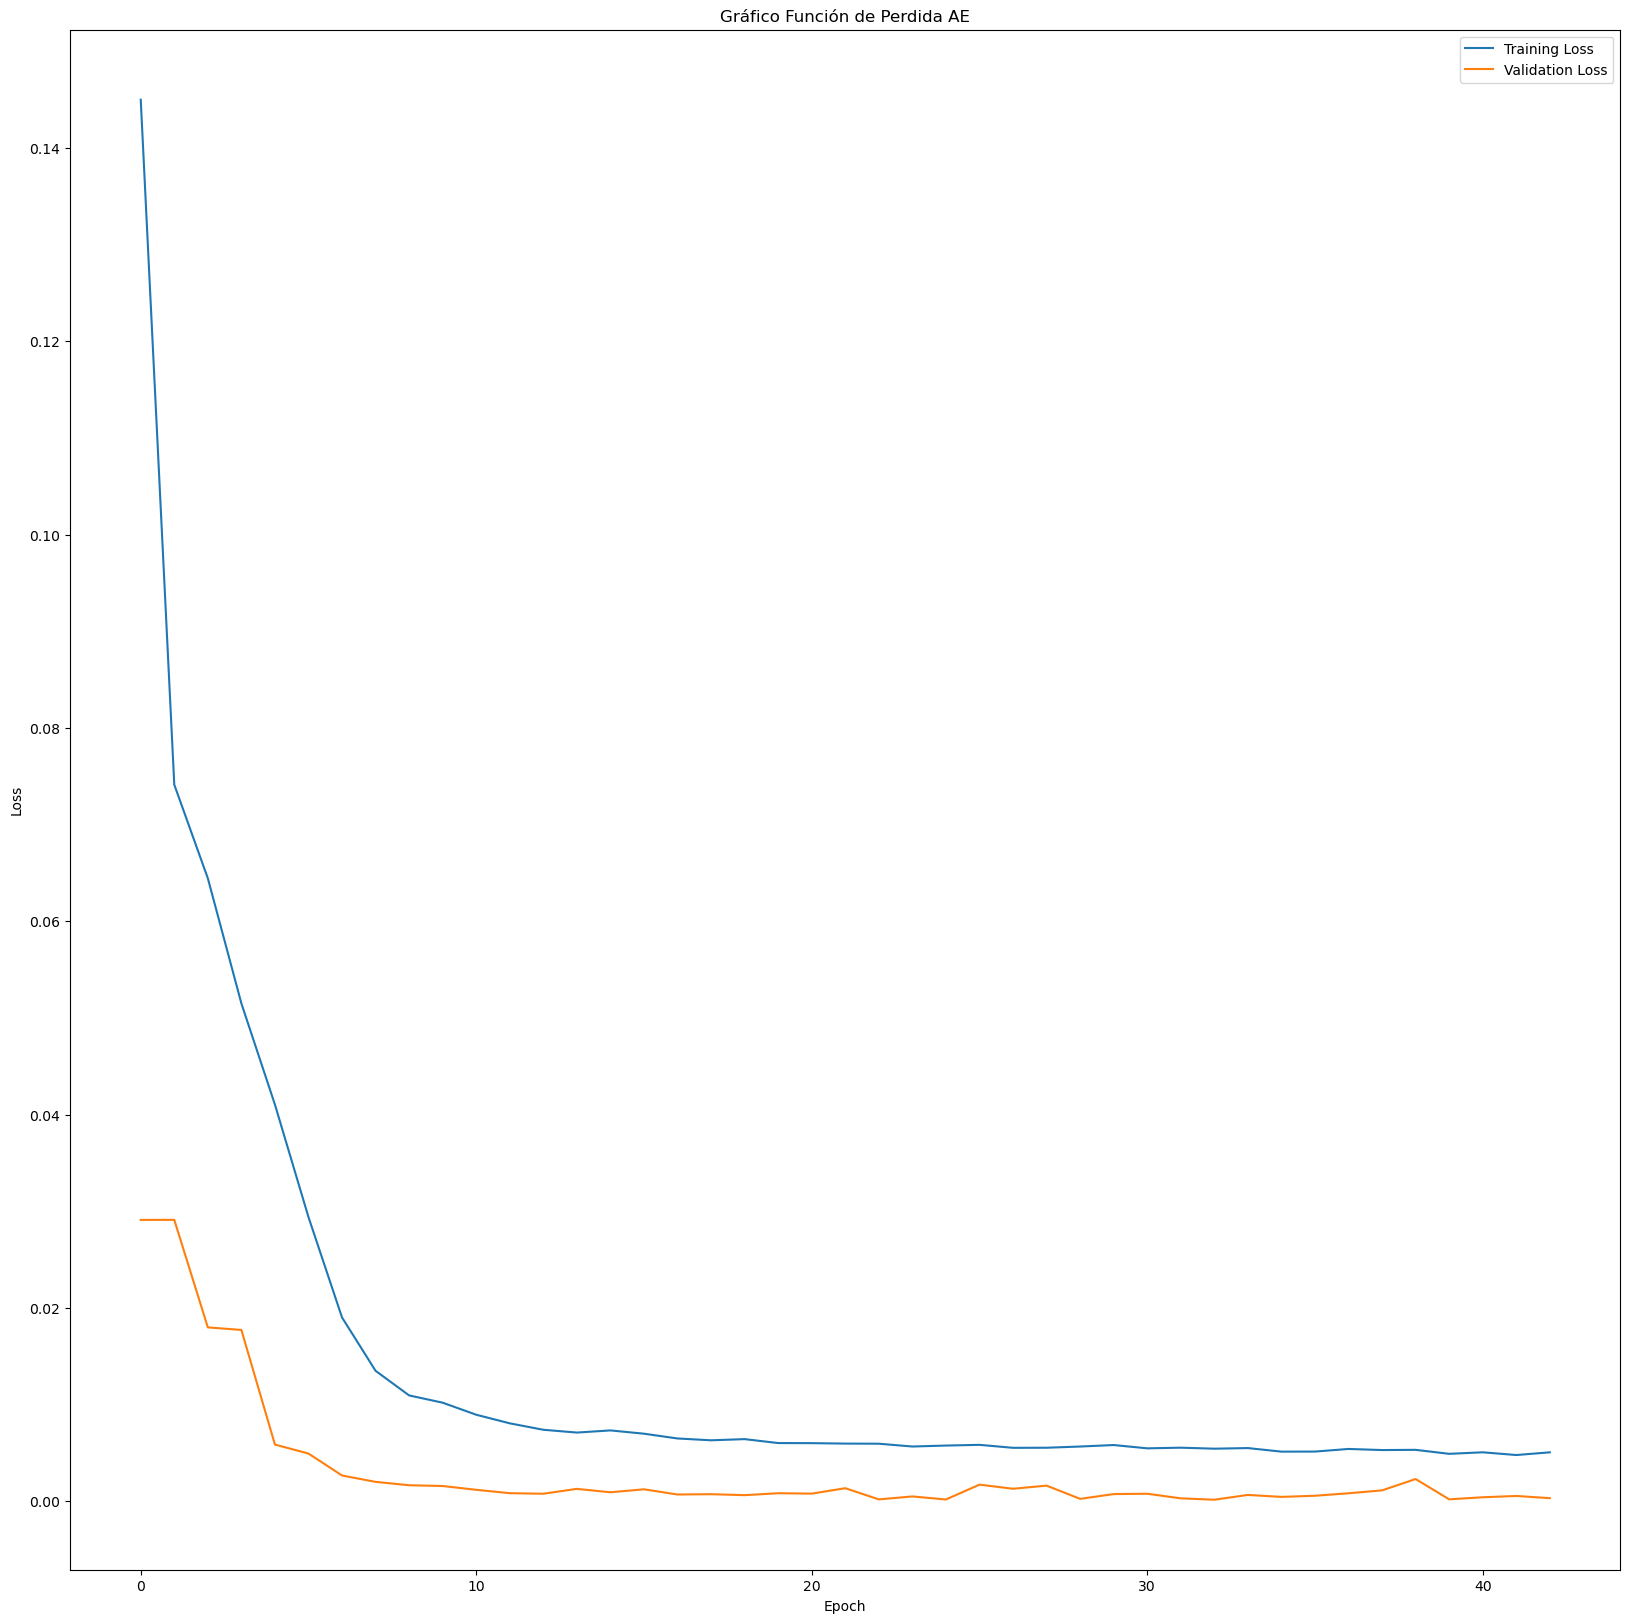

In [35]:
# Graficar la función de pérdida durante el entrenamiento
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Gráfico Función de Perdida AE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

##### Detección de anomalías con threshold 1.5

604/604 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


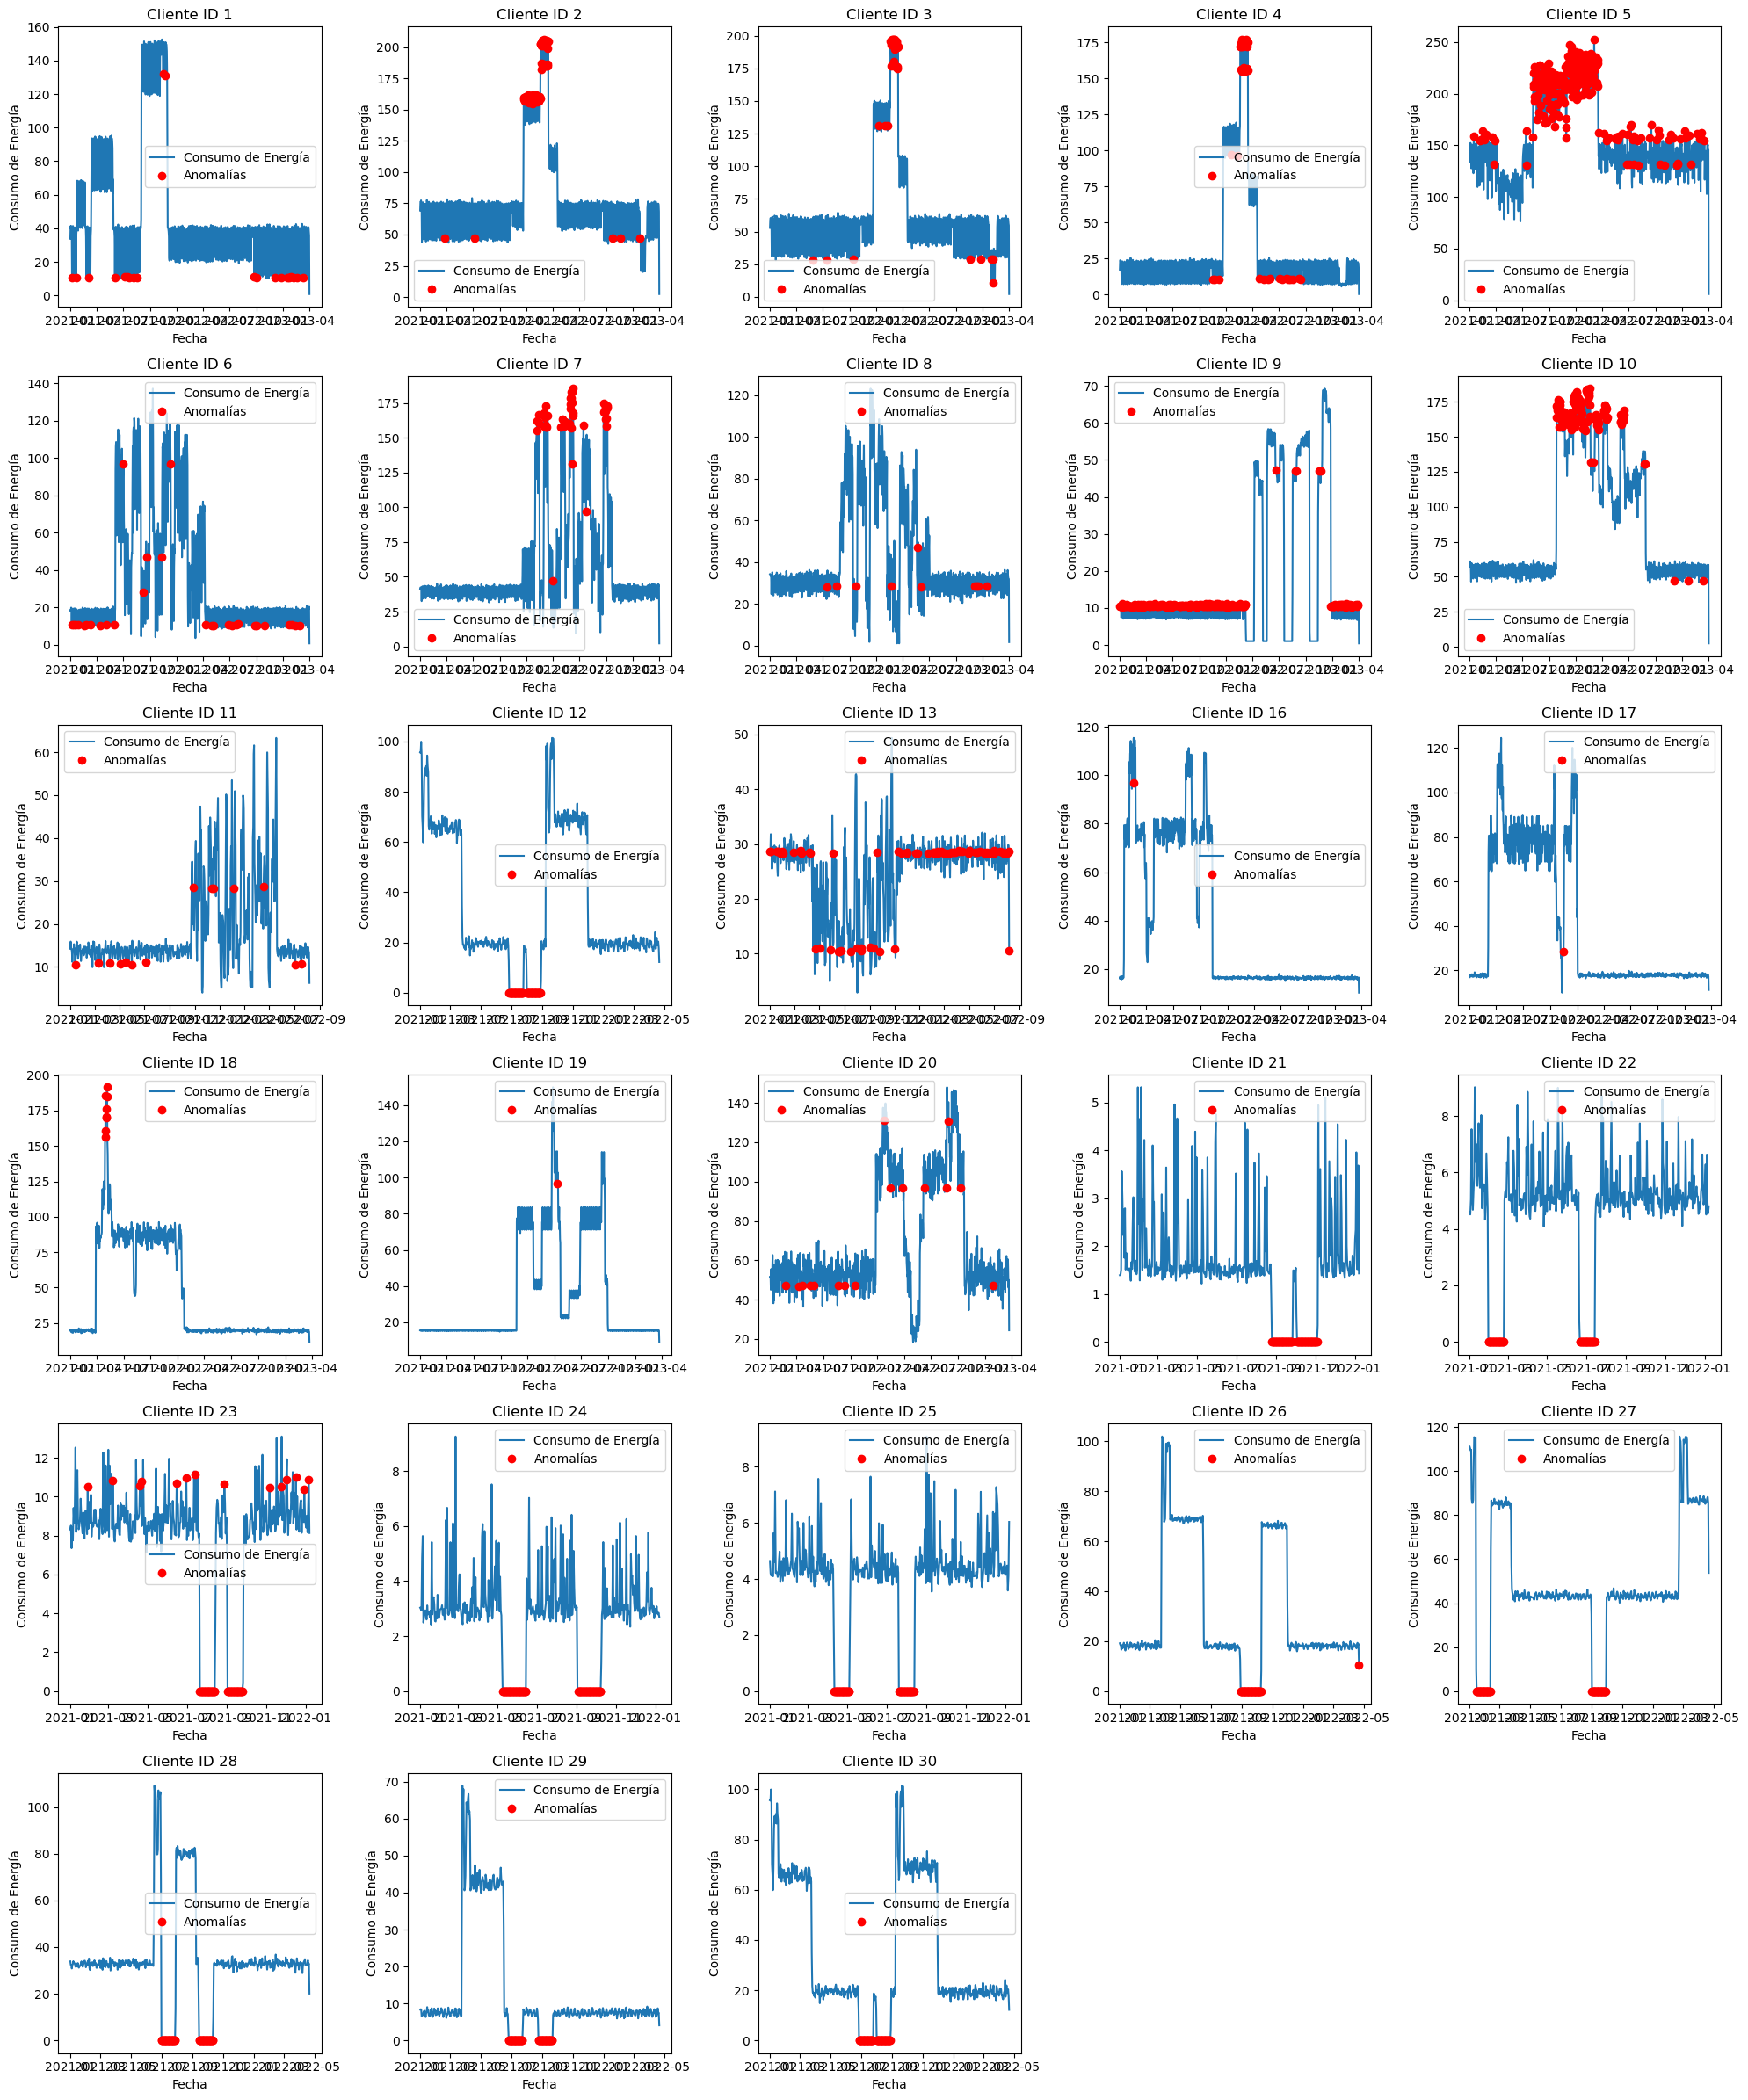

In [36]:
# Calcular el error de reconstrucción
reconstructions = autoencoder.predict(data)
reconstruction_error = np.abs(data - reconstructions)

# Calcular la media absoluta de las diferencias absolutas (MAD)
mad_error = np.mean(np.abs(reconstruction_error - np.mean(reconstruction_error)))

# Definir umbrales para anomalías
threshold_upper = np.mean(reconstruction_error) + 1.5 * mad_error
threshold_lower = np.mean(reconstruction_error) - 1.5 * mad_error

# Identificar los puntos de datos con error de reconstrucción fuera de los umbrales
anomalies_reconstruction = (reconstruction_error > threshold_upper) | (reconstruction_error < threshold_lower)

# Identificar los periodos con consumo nulo
null_consumption = (data == 0)

# Inicializar un DataFrame para almacenar las anomalías de cada cliente
anomalies = pd.DataFrame(index=daily_data.index, columns=['anomaly'], dtype=bool)

# Iterar sobre cada cliente para identificar anomalías
for cliente_id in daily_data['Cliente_ID'].unique():
    client_indices = daily_data['Cliente_ID'] == cliente_id
    # Identificar anomalías basadas en el consumo nulo y el error de reconstrucción
    anomalies_client = anomalies_reconstruction[client_indices].flatten() | null_consumption[client_indices].flatten()
    # Actualizar el DataFrame de anomalías con las anomalías del cliente actual
    anomalies.loc[client_indices, 'anomaly'] = anomalies_client

# Agregar la información de anomalía al DataFrame original
daily_data['anomaly'] = anomalies['anomaly']

# Filtrar clientes con anomalías
clients_with_anomalies = daily_data[daily_data['anomaly'] == True]['Cliente_ID'].unique()

# Crear gráficos para cada cliente con anomalías
num_clients = len(clients_with_anomalies)
cols = 5
rows = num_clients // cols + int(num_clients % cols != 0)

fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 4))

for i, cliente_id in enumerate(clients_with_anomalies):
    row = i // cols
    col = i % cols
    ax = axes[row, col] if rows > 1 else axes[col]

    cliente_data = daily_data[daily_data['Cliente_ID'] == cliente_id]
    ax.plot(cliente_data['Fecha'], cliente_data['Apparent_energy'], label='Consumo de Energía')
    ax.plot(cliente_data[cliente_data['anomaly']]['Fecha'],
            cliente_data[cliente_data['anomaly']]['Apparent_energy'], 'ro', label='Anomalías')
    ax.set_xlabel('Fecha')
    ax.set_ylabel('Consumo de Energía')
    ax.set_title(f'Cliente ID {cliente_id}')
    ax.legend()

# Eliminar subplots vacíos
for j in range(i + 1, rows * cols):
    row = j // cols
    col = j % cols
    fig.delaxes(axes[row, col] if rows > 1 else axes[col])

plt.tight_layout()
plt.show()


In [37]:
clientes_anomalias = clients_with_anomalies.tolist()
print("media(reconstruction_error) + 1.5 * mad_error:", clientes_anomalias)

media(reconstruction_error) + 1.5 * mad_error: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


##### Detección de anomalías con threshold 3

604/604 ━━━━━━━━━━━━━━━━━━━━ 1s 946us/step


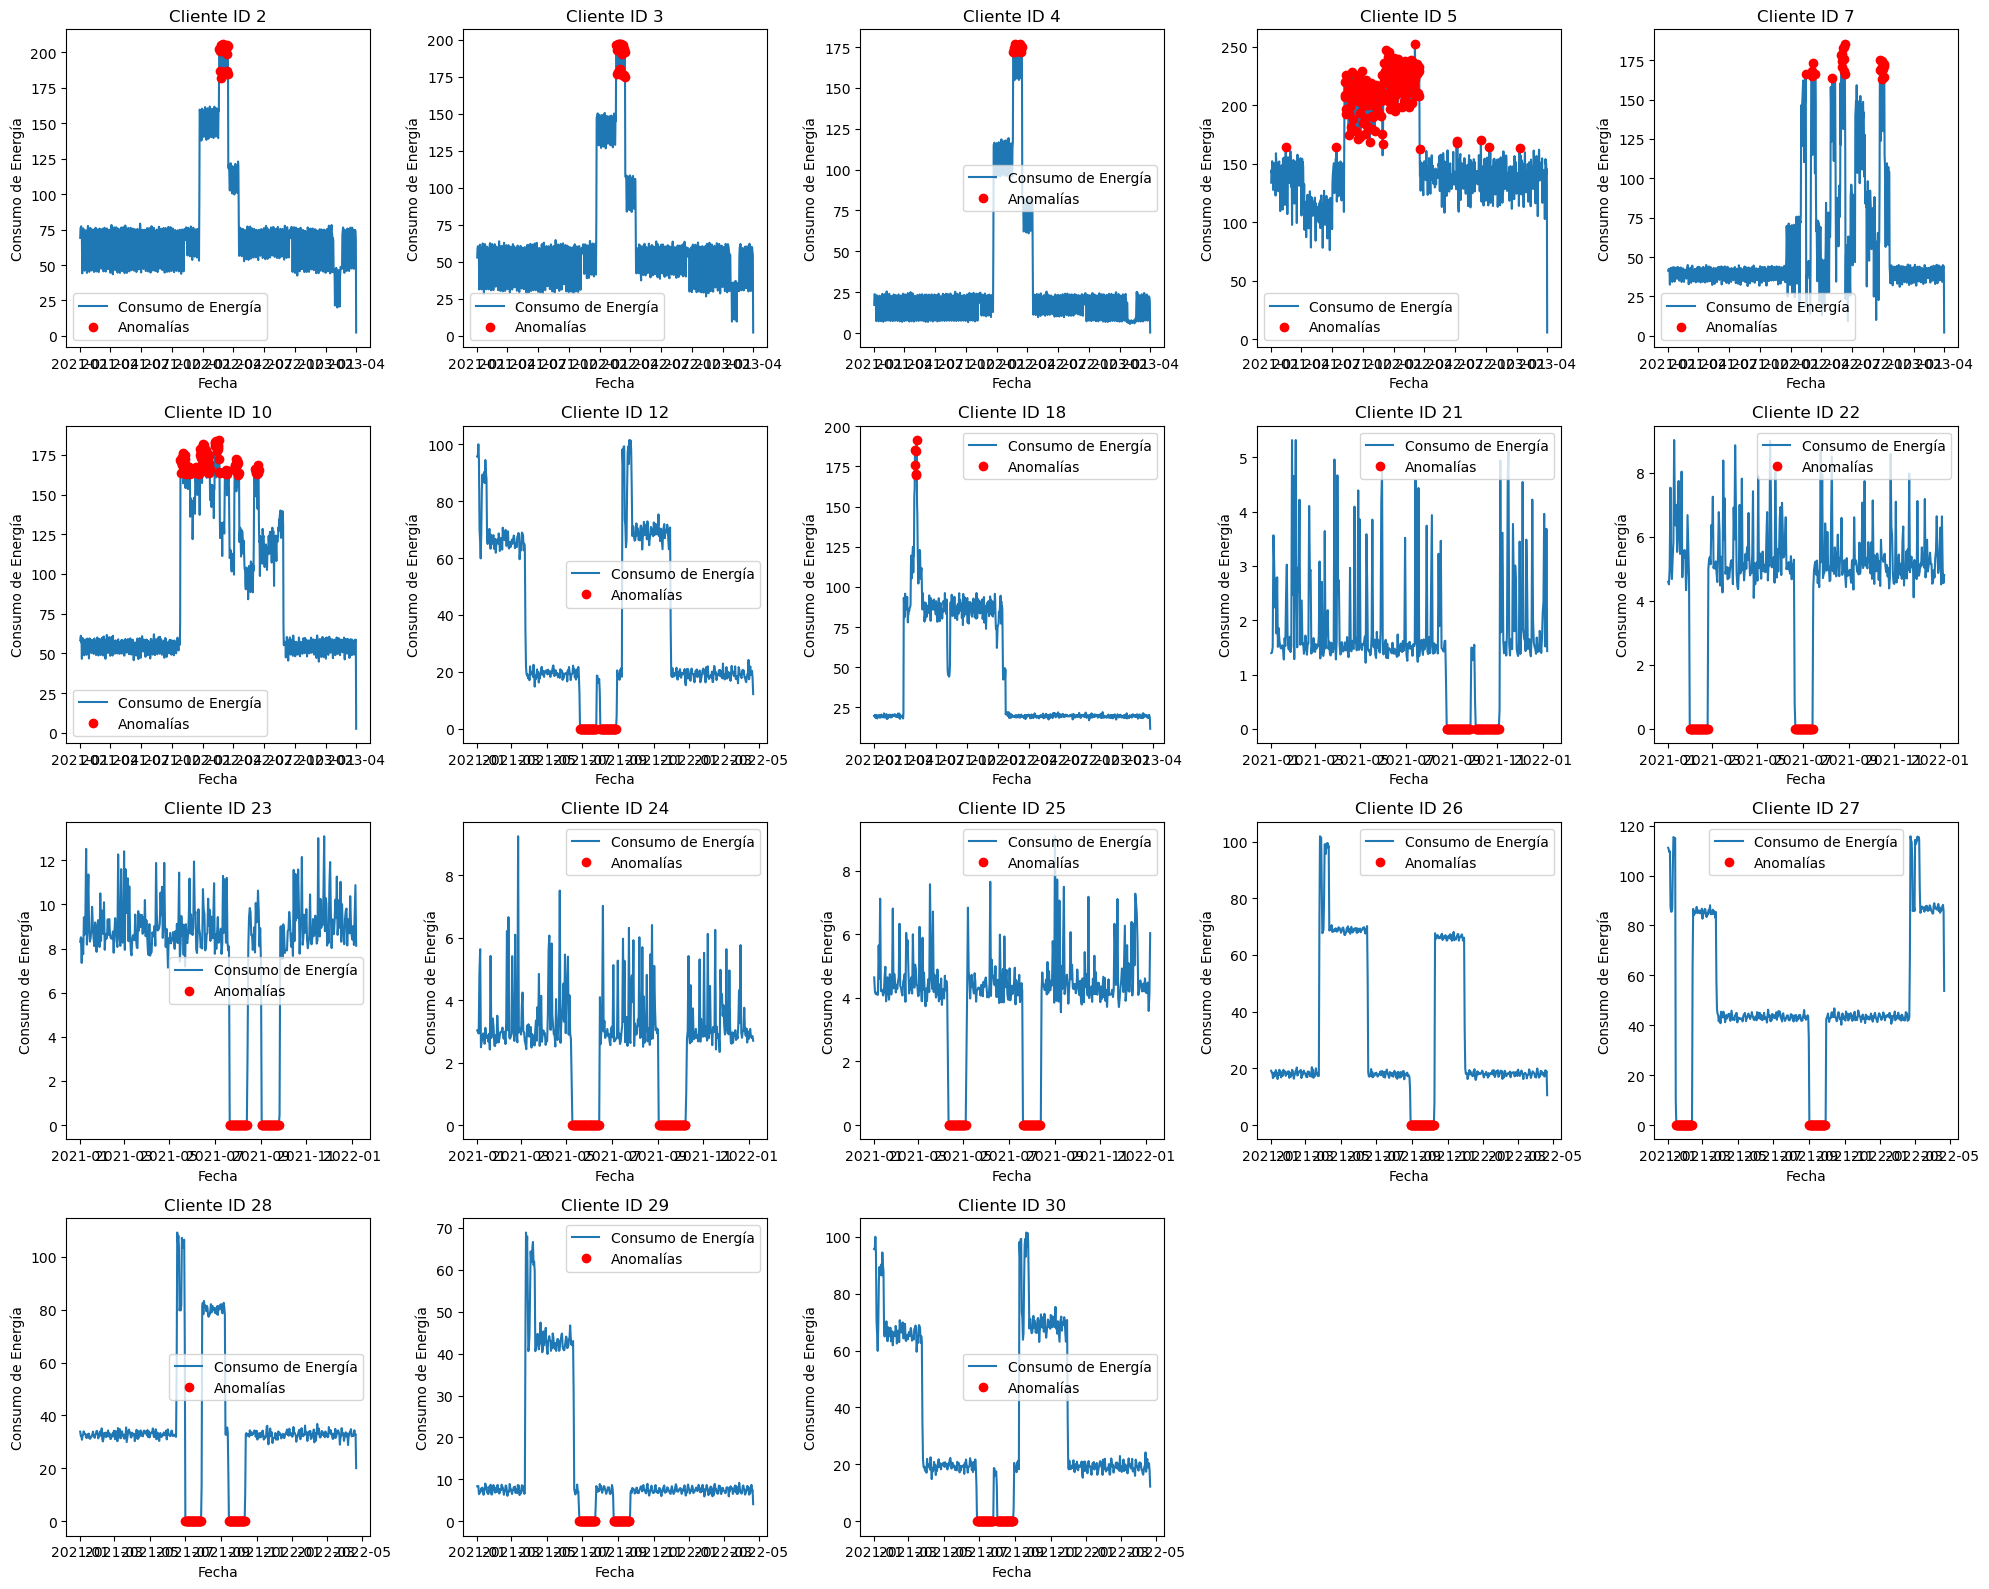

In [38]:

# Calcular el error de reconstrucción
reconstructions = autoencoder.predict(data)
reconstruction_error = np.abs(data - reconstructions)

# Calcular la media absoluta de las diferencias absolutas (MAD)
mad_error = np.mean(np.abs(reconstruction_error - np.mean(reconstruction_error)))

# Definir umbrales para anomalías
threshold_upper = np.mean(reconstruction_error) + 3 * mad_error
threshold_lower = np.mean(reconstruction_error) - 3 * mad_error

# Identificar los puntos de datos con error de reconstrucción fuera de los umbrales
anomalies_reconstruction = (reconstruction_error > threshold_upper) | (reconstruction_error < threshold_lower)

# Identificar los periodos con consumo nulo
null_consumption = (data == 0)

# Inicializar un DataFrame para almacenar las anomalías de cada cliente
anomalies = pd.DataFrame(index=daily_data.index, columns=['anomaly'], dtype=bool)

# Iterar sobre cada cliente para identificar anomalías
for cliente_id in daily_data['Cliente_ID'].unique():
    client_indices = daily_data['Cliente_ID'] == cliente_id
    # Identificar anomalías basadas en el consumo nulo y el error de reconstrucción
    anomalies_client = anomalies_reconstruction[client_indices].flatten() | null_consumption[client_indices].flatten()
    # Actualizar el DataFrame de anomalías con las anomalías del cliente actual
    anomalies.loc[client_indices, 'anomaly'] = anomalies_client

# Agregar la información de anomalía al DataFrame original
daily_data['anomaly'] = anomalies['anomaly']

# Filtrar clientes con anomalías
clients_with_anomalies = daily_data[daily_data['anomaly'] == True]['Cliente_ID'].unique()

# Crear gráficos para cada cliente con anomalías
num_clients = len(clients_with_anomalies)
cols = 5
rows = num_clients // cols + int(num_clients % cols != 0)

fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 4))

for i, cliente_id in enumerate(clients_with_anomalies):
    row = i // cols
    col = i % cols
    ax = axes[row, col] if rows > 1 else axes[col]

    cliente_data = daily_data[daily_data['Cliente_ID'] == cliente_id]
    ax.plot(cliente_data['Fecha'], cliente_data['Apparent_energy'], label='Consumo de Energía')
    ax.plot(cliente_data[cliente_data['anomaly']]['Fecha'],
            cliente_data[cliente_data['anomaly']]['Apparent_energy'], 'ro', label='Anomalías')
    ax.set_xlabel('Fecha')
    ax.set_ylabel('Consumo de Energía')
    ax.set_title(f'Cliente ID {cliente_id}')
    ax.legend()

# Eliminar subplots vacíos
for j in range(i + 1, rows * cols):
    row = j // cols
    col = j % cols
    fig.delaxes(axes[row, col] if rows > 1 else axes[col])

plt.tight_layout()
plt.show()


In [39]:

clientes_anomalias = clients_with_anomalies.tolist()
print("media(reconstruction_error) + 3 * mad_error:", clientes_anomalias)

media(reconstruction_error) + 3 * mad_error: [2, 3, 4, 5, 7, 10, 12, 18, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


##### Detección de anomalías con threshold 4.5

604/604 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  


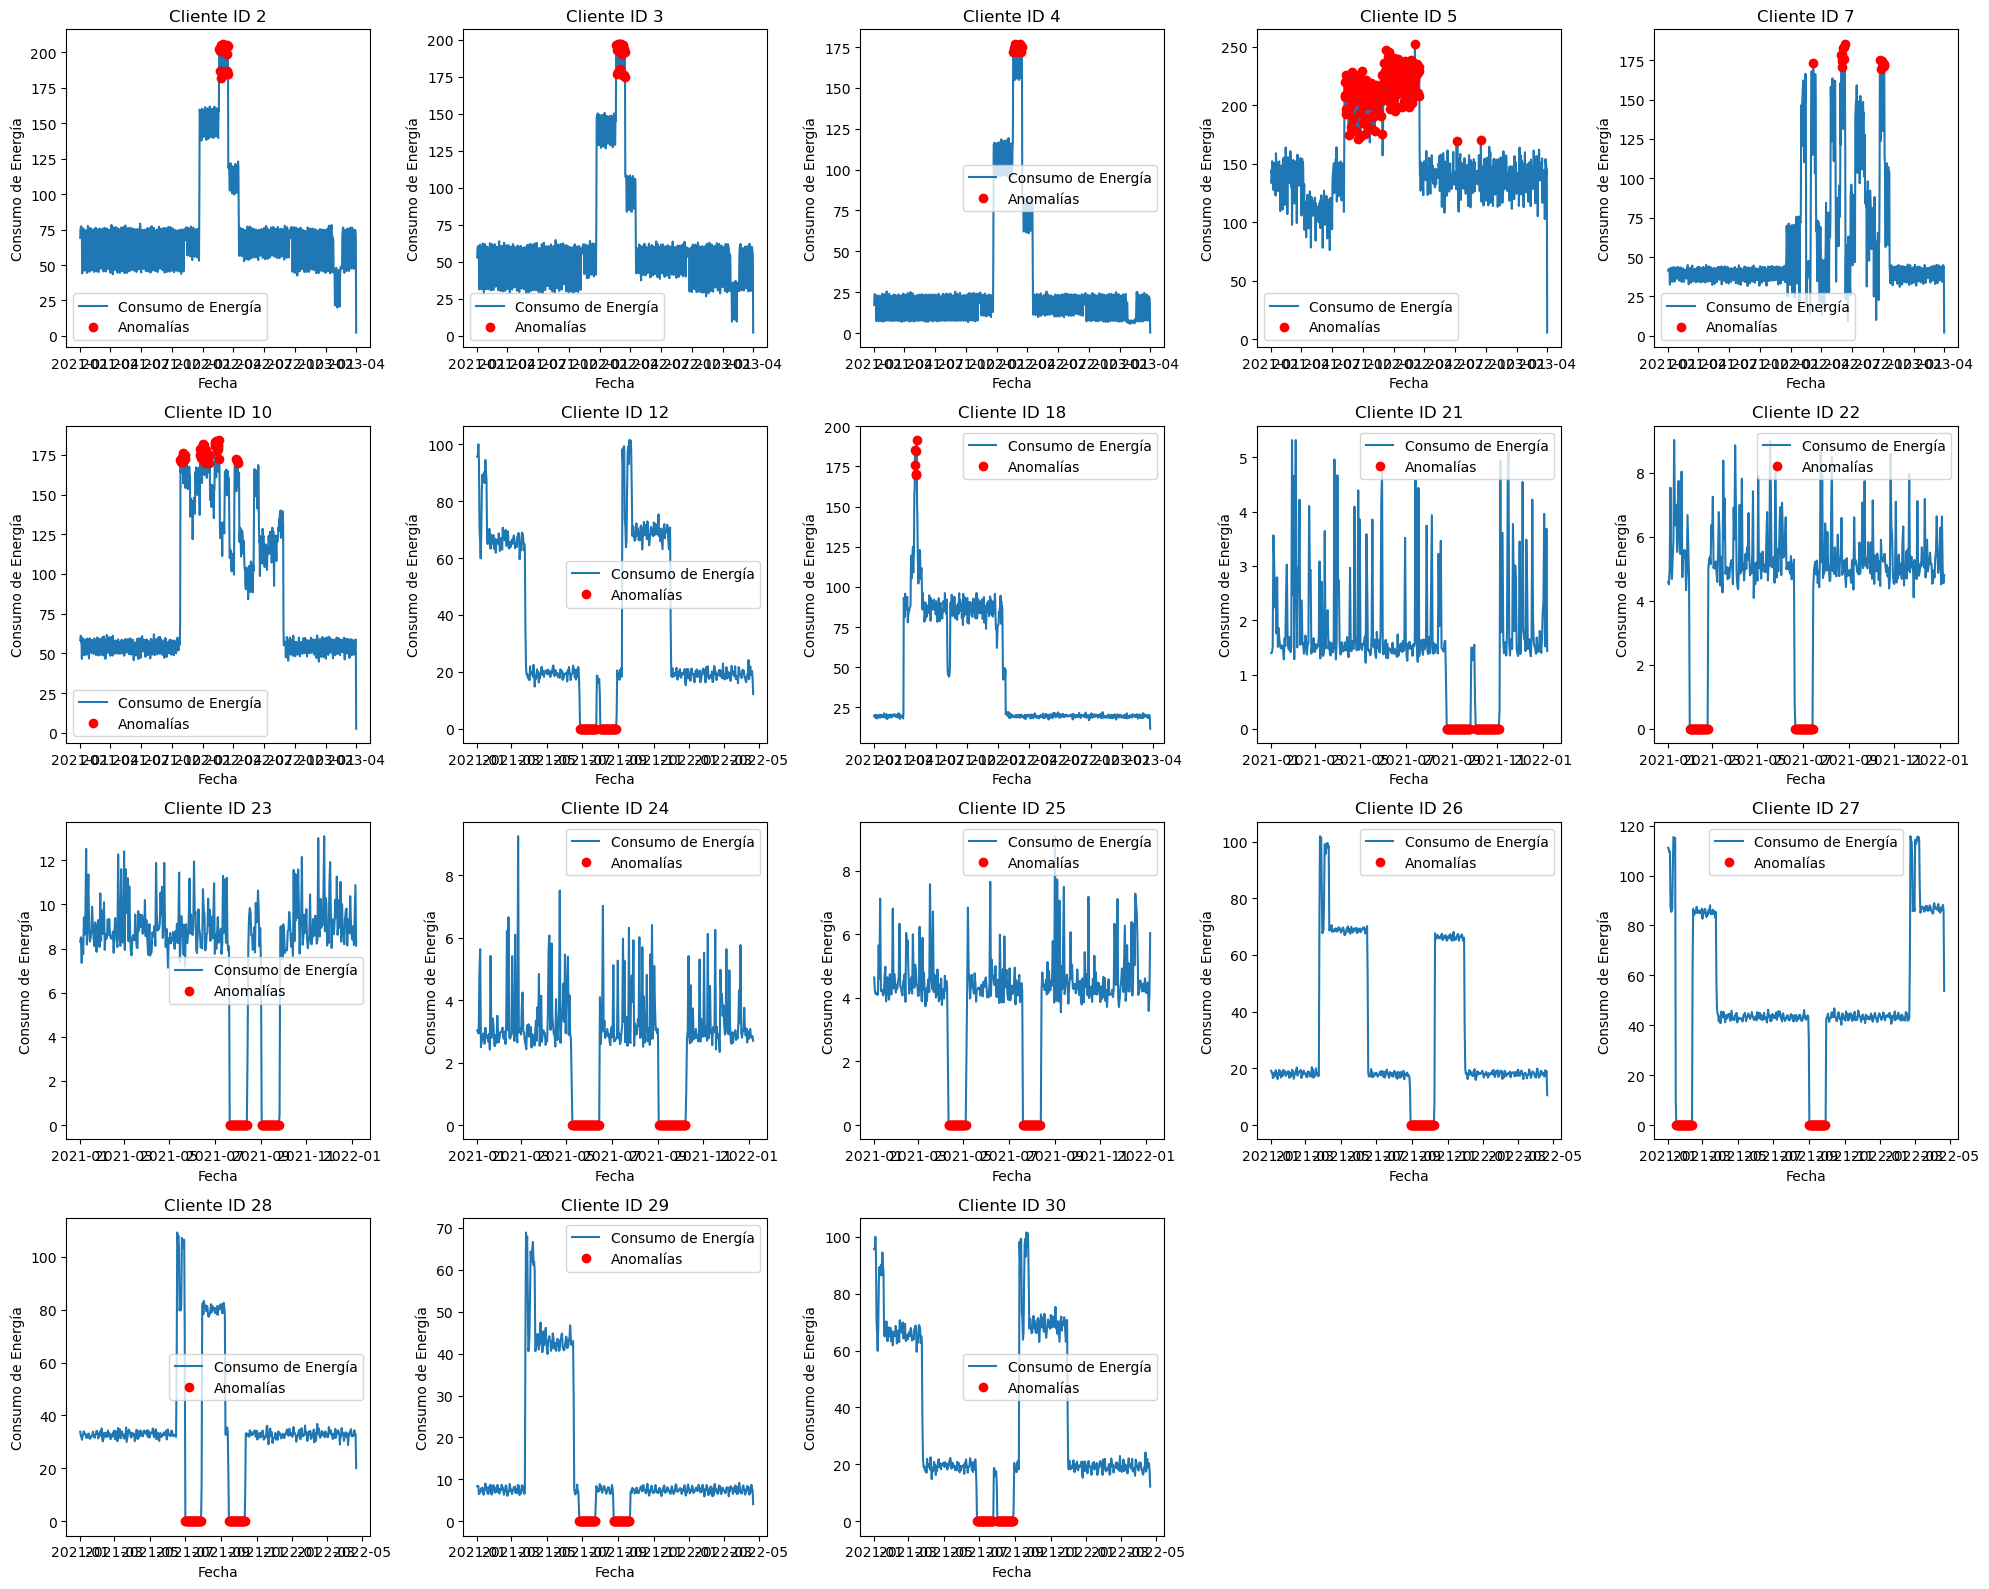

In [40]:

# Calcular el error de reconstrucción
reconstructions = autoencoder.predict(data)
reconstruction_error = np.abs(data - reconstructions)

# Calcular la media absoluta de las diferencias absolutas (MAD)
mad_error = np.mean(np.abs(reconstruction_error - np.mean(reconstruction_error)))

# Definir umbrales para anomalías
threshold_upper = np.mean(reconstruction_error) + 4.5 * mad_error
threshold_lower = np.mean(reconstruction_error) - 4.5 * mad_error

# Identificar los puntos de datos con error de reconstrucción fuera de los umbrales
anomalies_reconstruction = (reconstruction_error > threshold_upper) | (reconstruction_error < threshold_lower)

# Identificar los periodos con consumo nulo
null_consumption = (data == 0)

# Inicializar un DataFrame para almacenar las anomalías de cada cliente
anomalies = pd.DataFrame(index=daily_data.index, columns=['anomaly'], dtype=bool)

# Iterar sobre cada cliente para identificar anomalías
for cliente_id in daily_data['Cliente_ID'].unique():
    client_indices = daily_data['Cliente_ID'] == cliente_id
    # Identificar anomalías basadas en el consumo nulo y el error de reconstrucción
    anomalies_client = anomalies_reconstruction[client_indices].flatten() | null_consumption[client_indices].flatten()
    # Actualizar el DataFrame de anomalías con las anomalías del cliente actual
    anomalies.loc[client_indices, 'anomaly'] = anomalies_client

# Agregar la información de anomalía al DataFrame original
daily_data['anomaly'] = anomalies['anomaly']

# Filtrar clientes con anomalías
clients_with_anomalies = daily_data[daily_data['anomaly'] == True]['Cliente_ID'].unique()

# Crear gráficos para cada cliente con anomalías
num_clients = len(clients_with_anomalies)
cols = 5
rows = num_clients // cols + int(num_clients % cols != 0)

fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 4))

for i, cliente_id in enumerate(clients_with_anomalies):
    row = i // cols
    col = i % cols
    ax = axes[row, col] if rows > 1 else axes[col]

    cliente_data = daily_data[daily_data['Cliente_ID'] == cliente_id]
    ax.plot(cliente_data['Fecha'], cliente_data['Apparent_energy'], label='Consumo de Energía')
    ax.plot(cliente_data[cliente_data['anomaly']]['Fecha'],
            cliente_data[cliente_data['anomaly']]['Apparent_energy'], 'ro', label='Anomalías')
    ax.set_xlabel('Fecha')
    ax.set_ylabel('Consumo de Energía')
    ax.set_title(f'Cliente ID {cliente_id}')
    ax.legend()

# Eliminar subplots vacíos
for j in range(i + 1, rows * cols):
    row = j // cols
    col = j % cols
    fig.delaxes(axes[row, col] if rows > 1 else axes[col])

plt.tight_layout()
plt.show()


In [41]:

clientes_anomalias = clients_with_anomalies.tolist()
print("media(reconstruction_error) + 4.5 * mad_error:", clientes_anomalias)

media(reconstruction_error) + 4.5 * mad_error: [2, 3, 4, 5, 7, 10, 12, 18, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


### Calibración parámetros

In [42]:
'''
df = consumo_clientes
df['Fecha'] = pd.to_datetime(df['Fecha'])

# Agrupar los datos por día y calcular el consumo total diario
df['Fecha'] = df['Fecha'].dt.date
daily_data = df.groupby(['Cliente_ID', 'Fecha']).agg({'Apparent_energy': 'sum'}).reset_index()

# Normaliza los datos de consumo de energía
scaler = MinMaxScaler()
daily_data['Apparent_energy_scaled'] = scaler.fit_transform(daily_data[['Apparent_energy']])

# Prepara datos para el autoencoder
data = daily_data[['Apparent_energy_scaled']].values

# Definir una función para crear y entrenar el autoencoder con los parámetros dados
def train_autoencoder(encoding_dim, dropout_rate, activity_regularizer):
    input_dim = data.shape[1]
    input_layer = Input(shape=(input_dim, ))

    encoder = Dense(encoding_dim, activation="tanh",
                    activity_regularizer=regularizers.l1(activity_regularizer))(input_layer)
    encoder = BatchNormalization()(encoder)
    encoder = Dropout(dropout_rate)(encoder)
    encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
    encoder = BatchNormalization()(encoder)
    encoder = Dropout(dropout_rate)(encoder)

    decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
    decoder = BatchNormalization()(decoder)
    decoder = Dropout(dropout_rate)(decoder)
    decoder = Dense(input_dim, activation='relu')(decoder)

    autoencoder = Model(inputs=input_layer, outputs=decoder)
    autoencoder.compile(optimizer='adam', loss='mse')

    history = autoencoder.fit(data, data,
                              epochs=100,
                              batch_size=32,
                              shuffle=True,
                              validation_split=0.2,
                              verbose=0)

    return autoencoder, history

# Parámetros para la búsqueda
encoding_dims = [8, 10, 12]
dropout_rates = [0.2, 0.3]
activity_regularizers = [10e-5, 10e-4]

best_loss = float('inf')
best_params = {}

# Bucle para buscar los mejores parámetros
for encoding_dim in encoding_dims:
    for dropout_rate in dropout_rates:
        for activity_regularizer in activity_regularizers:
            autoencoder, history = train_autoencoder(encoding_dim, dropout_rate, activity_regularizer)
            val_loss = history.history['val_loss'][-1]

            if val_loss < best_loss:
                best_loss = val_loss
                best_params = {
                    'encoding_dim': encoding_dim,
                    'dropout_rate': dropout_rate,
                    'activity_regularizer': activity_regularizer
                }

print("Mejores parámetros encontrados:")
print(best_params)
'''

'\ndf = consumo_clientes\ndf[\'Fecha\'] = pd.to_datetime(df[\'Fecha\'])\n\n# Agrupar los datos por día y calcular el consumo total diario\ndf[\'Fecha\'] = df[\'Fecha\'].dt.date\ndaily_data = df.groupby([\'Cliente_ID\', \'Fecha\']).agg({\'Apparent_energy\': \'sum\'}).reset_index()\n\n# Normaliza los datos de consumo de energía\nscaler = MinMaxScaler()\ndaily_data[\'Apparent_energy_scaled\'] = scaler.fit_transform(daily_data[[\'Apparent_energy\']])\n\n# Prepara datos para el autoencoder\ndata = daily_data[[\'Apparent_energy_scaled\']].values\n\n# Definir una función para crear y entrenar el autoencoder con los parámetros dados\ndef train_autoencoder(encoding_dim, dropout_rate, activity_regularizer):\n    input_dim = data.shape[1]\n    input_layer = Input(shape=(input_dim, ))\n\n    encoder = Dense(encoding_dim, activation="tanh",\n                    activity_regularizer=regularizers.l1(activity_regularizer))(input_layer)\n    encoder = BatchNormalization()(encoder)\n    encoder = Dropou

##### Resultado de red AE con mejores parámetros

In [43]:
# Normaliza los datos de consumo de energía
scaler = MinMaxScaler()
daily_data['Apparent_energy_scaled'] = scaler.fit_transform(daily_data[['Apparent_energy']])

# Prepara datos para el autoencoder
data = daily_data[['Apparent_energy_scaled']].values

# Definir y entrenar el autoencoder con capas adicionales
input_dim = data.shape[1]
encoding_dim = 8  # Mejores parámetros encontrados
dropout_rate = 0.2  # Mejores parámetros encontrados
activity_regularizer = regularizers.l1(0.0001)  # Mejores parámetros encontrados

input_layer = Input(shape=(input_dim, ))

# Capas del autoencoder
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=activity_regularizer)(input_layer)
encoder = BatchNormalization()(encoder)
encoder = Dropout(dropout_rate)(encoder)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
encoder = BatchNormalization()(encoder)
encoder = Dropout(dropout_rate)(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = BatchNormalization()(decoder)
decoder = Dropout(dropout_rate)(decoder)
decoder = Dense(input_dim, activation='relu')(decoder)

# Modelo
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mse')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenamiento del autoencoder
history = autoencoder.fit(data, data,
                          epochs=100,
                          batch_size=32,
                          shuffle=True,
                          validation_split=0.2,
                          verbose=1,
                          callbacks=[early_stopping])

reconstructions = autoencoder.predict(data)
reconstruction_error = np.abs(data - reconstructions)

# Calcular la media absoluta de las diferencias absolutas (MAD)
mad_error = np.mean(np.abs(reconstruction_error - np.mean(reconstruction_error)))

# Definir umbrales para anomalías
threshold_upper = np.mean(reconstruction_error) + 3 * mad_error
threshold_lower = np.mean(reconstruction_error) - 3 * mad_error

# Identificar los puntos de datos con error de reconstrucción fuera de los umbrales
anomalies_reconstruction = (reconstruction_error > threshold_upper) | (reconstruction_error < threshold_lower)

# Identificar los periodos con consumo nulo
null_consumption = (data == 0)

# Inicializar un DataFrame para almacenar las anomalías de cada cliente
anomalies = pd.DataFrame(index=daily_data.index, columns=['anomaly'], dtype=bool)

# Iterar sobre cada cliente para identificar anomalías
for cliente_id in daily_data['Cliente_ID'].unique():
    client_indices = daily_data['Cliente_ID'] == cliente_id
    # Identificar anomalías basadas en el consumo nulo y el error de reconstrucción
    anomalies_client = anomalies_reconstruction[client_indices].flatten() | null_consumption[client_indices].flatten()
    # Actualizar el DataFrame de anomalías con las anomalías del cliente actual
    anomalies.loc[client_indices, 'anomaly'] = anomalies_client

# Agregar la información de anomalía al DataFrame original
daily_data['anomaly'] = anomalies['anomaly']

# Filtrar clientes con anomalías
clients_with_anomalies = daily_data[daily_data['anomaly'] == True]['Cliente_ID'].unique()


clientes_anomalias = clients_with_anomalies.tolist()
print("media(reconstruction_error) + 3BP * mad_error:", clientes_anomalias)


Epoch 1/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0783 - val_loss: 0.0078
Epoch 2/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0310 - val_loss: 0.0050
Epoch 3/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0244 - val_loss: 0.0026
Epoch 4/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0201 - val_loss: 9.8319e-04
Epoch 5/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0102 - val_loss: 8.2760e-04
Epoch 6/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0085 - val_loss: 6.5171e-04
Epoch 7/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0072 - val_loss: 5.2549e-04
Epoch 8/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0066 - val_loss: 6.4024e-04
Epoch 9/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0066 - val_loss: 9.8191e-04
Epoch 10/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0064 - val_loss: 0.0013
Epoch 11/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0059 - val_loss: 0.0011
Epoch 12/100
484/

#### Modelos Predictivos

Preprocesamiento de datos

In [44]:
df_resultado['Fecha_2'] = df_resultado['Fecha'].apply(lambda x: x.strftime("%Y%m"))
df_tratamiento=df_resultado[['Cliente_ID','Apparent_energy','Fecha_2'] ]
df_tratamiento=df_tratamiento.groupby(['Cliente_ID', 'Fecha_2'])['Apparent_energy'].sum().reset_index()
df_pivot = df_tratamiento.pivot_table(index='Cliente_ID', columns='Fecha_2', values='Apparent_energy').reset_index()
df_pivot=df_pivot.set_index('Cliente_ID')
#df_pivot['cols_null'] = df_pivot.isnull().sum(axis=1)
df_pivot.head()

Fecha_2          202101       202102       202103       202104       202105  \
Cliente_ID                                                                    
1           1277.377248  1527.367746  1990.268513  2584.478694  2535.100615   
2           2145.355784  1931.548377  2154.640623  2041.867380  2162.946200   
3           1692.406908  1517.097895  1686.539969  1592.340473  1693.298944   
4            598.761012   539.963259   593.996147   568.041878   599.159418   
5           4397.439266  3949.501081  4358.751678  3521.939933  3421.580587   

Fecha_2          202106       202107       202108       202109       202110  \
Cliente_ID                                                                    
1           1034.067108  1043.244448  1081.096309  4193.418661  4478.571412   
2           2072.411576  2115.948853  2155.932445  2048.763422  2140.640256   
3           1620.373114  1660.446195  1696.041193  1612.095598  1671.190458   
4            569.295029   579.801820   610.615418   558.580862   598.701069   
5           3280.520809  4282.697818  6069.302796  6201.520244  6309.558393   

Fecha_2     ...       202207       202208       202209       202210  \
Cliente_ID  ...                                                       
1           ...  1079.920226  1038.553778  1074.344250  1046.763410   
2           ...  2162.018678  2114.811241  2116.591862  2114.101010   
3           ...  1688.785038  1655.785529  1652.167885  1666.199977   
4           ...   597.372628   580.676638   594.836391   592.825706   
5           ...  4374.153579  4341.243607  4196.208782  4334.123832   

Fecha_2          202211       202212       202301       202302       202303  \
Cliente_ID                                                                    
1           1035.825793  1038.023874  1071.940356   952.903473  1071.227539   
2           2078.574678  2109.928911  1923.747750  1469.846840  2152.827936   
3           1632.865572  1666.613583  1484.322705  1099.001964  1689.709747   
4            580.373939   581.810391   489.500991   324.055778   596.449949   
5           4260.579813  4285.636773  4333.399865  3962.996359  4374.804960   

Fecha_2       202304  
Cliente_ID            
1           0.852596  
2           2.355162  
3           2.148546  
4           0.289003  
5           5.895011  

[5 rows x 28 columns]

In [45]:
df_pivot.isnull().sum()

Fecha_2
202101     0
202102     0
202103     0
202104     0
202105     0
202106     0
202107     0
202108     0
202109     0
202110     0
202111     0
202112     0
202201     0
202202     5
202203     5
202204     5
202205    11
202206    11
202207    11
202208    11
202209    15
202210    15
202211    15
202212    15
202301    15
202302    15
202303    15
202304    20
dtype: int64

In [46]:
#valida missing values del último periodo y elimina si la variación porcentual promedio es mayor a 150
while True:
    drop_per = df_pivot[df_pivot.iloc[:, -1].notnull()]
    drop_per['variacion_porcentual'] = ((drop_per.iloc[:, -2] - drop_per.iloc[:, -1]) / drop_per.iloc[:, -1]) * 100
    variacion_prom = drop_per['variacion_porcentual'].mean()
    #print(drop_per.iloc[:, -3:])
    print("Variacion mes " + df_pivot.columns[-1] +": " +str(variacion_prom))

    if abs(variacion_prom) < 150:
        break

    df_pivot = df_pivot.drop(columns=[df_pivot.columns[-1]])

    if len(df_pivot.columns) == 1:
        break

Variacion mes 202304: 90268.03798430157
Variacion mes 202303: -5.756140668838705


In [47]:
df = df_pivot.copy()

for index, row in df_pivot.iterrows():
    non_null_values = row.dropna().values  # Valores no nulos de la fila
    null_indexes = row.isnull()  # índices de los valores nulos

    # Reemplaza los valores nulos con los valores no nulos consecutivos
    for i, is_null in enumerate(null_indexes):
        if is_null:
            df.at[index, df_pivot.columns[i]] = non_null_values[i % len(non_null_values)]

# Inserta la columna 'Cliente_ID'
df['Cliente_ID'] = df_pivot.index

# Reemplaza nulos con los valores actualizados en el DataFrame original
df.update(df)

master_table=df.set_index('Cliente_ID')
master_table.head()

Fecha_2          202101       202102       202103       202104       202105  \
Cliente_ID                                                                    
1           1277.377248  1527.367746  1990.268513  2584.478694  2535.100615   
2           2145.355784  1931.548377  2154.640623  2041.867380  2162.946200   
3           1692.406908  1517.097895  1686.539969  1592.340473  1693.298944   
4            598.761012   539.963259   593.996147   568.041878   599.159418   
5           4397.439266  3949.501081  4358.751678  3521.939933  3421.580587   

Fecha_2          202106       202107       202108       202109       202110  \
Cliente_ID                                                                    
1           1034.067108  1043.244448  1081.096309  4193.418661  4478.571412   
2           2072.411576  2115.948853  2155.932445  2048.763422  2140.640256   
3           1620.373114  1660.446195  1696.041193  1612.095598  1671.190458   
4            569.295029   579.801820   610.615418   558.580862   598.701069   
5           3280.520809  4282.697818  6069.302796  6201.520244  6309.558393   

Fecha_2     ...       202206       202207       202208       202209  \
Cliente_ID  ...                                                       
1           ...  1035.092614  1079.920226  1038.553778  1074.344250   
2           ...  2063.093904  2162.018678  2114.811241  2116.591862   
3           ...  1631.947321  1688.785038  1655.785529  1652.167885   
4           ...   577.654190   597.372628   580.676638   594.836391   
5           ...  4222.342788  4374.153579  4341.243607  4196.208782   

Fecha_2          202210       202211       202212       202301       202302  \
Cliente_ID                                                                    
1           1046.763410  1035.825793  1038.023874  1071.940356   952.903473   
2           2114.101010  2078.574678  2109.928911  1923.747750  1469.846840   
3           1666.199977  1632.865572  1666.613583  1484.322705  1099.001964   
4            592.825706   580.373939   581.810391   489.500991   324.055778   
5           4334.123832  4260.579813  4285.636773  4333.399865  3962.996359   

Fecha_2          202303  
Cliente_ID               
1           1071.227539  
2           2152.827936  
3           1689.709747  
4            596.449949  
5           4374.804960  

[5 rows x 27 columns]

# Separación Train y test

> 2 meses para testear el modelo



In [48]:
#Conversión de formato fecha completa
dates = pd.date_range(start="2021-01-01", periods=len(master_table.columns), freq="M")
master_table.columns = dates
#División Train y test y conversión de formato fecha completa
df_train=master_table.iloc[:, :-1]
df_test=master_table.iloc[:, -1:]
df_train.head()

2021-01-31   2021-02-28   2021-03-31   2021-04-30   2021-05-31  \
Cliente_ID                                                                    
1           1277.377248  1527.367746  1990.268513  2584.478694  2535.100615   
2           2145.355784  1931.548377  2154.640623  2041.867380  2162.946200   
3           1692.406908  1517.097895  1686.539969  1592.340473  1693.298944   
4            598.761012   539.963259   593.996147   568.041878   599.159418   
5           4397.439266  3949.501081  4358.751678  3521.939933  3421.580587   

             2021-06-30   2021-07-31   2021-08-31   2021-09-30   2021-10-31  \
Cliente_ID                                                                    
1           1034.067108  1043.244448  1081.096309  4193.418661  4478.571412   
2           2072.411576  2115.948853  2155.932445  2048.763422  2140.640256   
3           1620.373114  1660.446195  1696.041193  1612.095598  1671.190458   
4            569.295029   579.801820   610.615418   558.580862   598.701069   
5           3280.520809  4282.697818  6069.302796  6201.520244  6309.558393   

            ...   2022-05-31   2022-06-30   2022-07-31   2022-08-31  \
Cliente_ID  ...                                                       
1           ...  1039.624127  1035.092614  1079.920226  1038.553778   
2           ...  2099.821801  2063.093904  2162.018678  2114.811241   
3           ...  1653.903009  1631.947321  1688.785038  1655.785529   
4           ...   581.299284   577.654190   597.372628   580.676638   
5           ...  4366.850127  4222.342788  4374.153579  4341.243607   

             2022-09-30   2022-10-31   2022-11-30   2022-12-31   2023-01-31  \
Cliente_ID                                                                    
1           1074.344250  1046.763410  1035.825793  1038.023874  1071.940356   
2           2116.591862  2114.101010  2078.574678  2109.928911  1923.747750   
3           1652.167885  1666.199977  1632.865572  1666.613583  1484.322705   
4            594.836391   592.825706   580.373939   581.810391   489.500991   
5           4196.208782  4334.123832  4260.579813  4285.636773  4333.399865   

             2023-02-28  
Cliente_ID               
1            952.903473  
2           1469.846840  
3           1099.001964  
4            324.055778  
5           3962.996359  

[5 rows x 26 columns]

In [49]:
#Dimensión Train y test
print( " dim train")
print(df_train.shape)
print(" dim test")
print(df_test.shape)

 dim train
(30, 26)
 dim test
(30, 1)


## Entrenamiento y validación de modelos

In [50]:
#Holt Winters
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
predictions = {}
train_rmse = {}

for cliente_id, row in df_train.iterrows():
    model = ExponentialSmoothing(row, seasonal_periods=12, trend='add', seasonal='add',initialization_method="estimated").fit(optimized=True,smoothing_level=0.95, smoothing_trend=0.9,
                                     damping_trend=0.98)
    pred = model.forecast(1)
    predictions[cliente_id] = pred
    train_rmse[cliente_id] = rmse(row, model.fittedvalues)

# Construir DataFrame de predicciones
pred_df = pd.DataFrame(predictions).T
pred_df['Train_RMSE'] = pd.Series(train_rmse)
#pred_df.columns = ['pred_'+str(df_train.columns[-2]), 'pred_'+str(df_train.columns[-1]), 'Train_RMSE']
pred_df.columns = ['pred_1', 'Train_RMSE']
pred_df.index.name = 'Cliente_ID'
print(pred_df.head())
merged_df = df_train.merge(df_test, on='Cliente_ID', how='left')
merged_df=merged_df.merge(pred_df, on='Cliente_ID', how='left')
print("RMSE test:"+str(np.sqrt(mean_squared_error(merged_df.iloc[:, -3], merged_df["pred_1"])))+"-RMSE test prom cliente :"+str(np.sqrt(mean_squared_error(merged_df.iloc[:, -3], merged_df["pred_1"]))/30))

                 pred_1  Train_RMSE
Cliente_ID                         
1           1114.175294  863.549371
2           1056.906692  431.341396
3            636.308432  447.840599
4           -134.847114  491.039525
5           4111.933770  379.352445
RMSE test:641.653146806985-RMSE test prom cliente :21.3884382268995


In [51]:
merged_df['variacion_porcentual'] = ((merged_df.iloc[:, -2] - merged_df.iloc[:, -3]) /merged_df.iloc[:, -3]) * 100
merged_df.head()

2021-01-31 00:00:00  2021-02-28 00:00:00  2021-03-31 00:00:00  \
Cliente_ID                                                                  
1                   1277.377248          1527.367746          1990.268513   
2                   2145.355784          1931.548377          2154.640623   
3                   1692.406908          1517.097895          1686.539969   
4                    598.761012           539.963259           593.996147   
5                   4397.439266          3949.501081          4358.751678   

            2021-04-30 00:00:00  2021-05-31 00:00:00  2021-06-30 00:00:00  \
Cliente_ID                                                                  
1                   2584.478694          2535.100615          1034.067108   
2                   2041.867380          2162.946200          2072.411576   
3                   1592.340473          1693.298944          1620.373114   
4                    568.041878           599.159418           569.295029   
5                   3521.939933          3421.580587          3280.520809   

            2021-07-31 00:00:00  2021-08-31 00:00:00  2021-09-30 00:00:00  \
Cliente_ID                                                                  
1                   1043.244448          1081.096309          4193.418661   
2                   2115.948853          2155.932445          2048.763422   
3                   1660.446195          1696.041193          1612.095598   
4                    579.801820           610.615418           558.580862   
5                   4282.697818          6069.302796          6201.520244   

            2021-10-31 00:00:00  ...  2022-09-30 00:00:00  \
Cliente_ID                       ...                        
1                   4478.571412  ...          1074.344250   
2                   2140.640256  ...          2116.591862   
3                   1671.190458  ...          1652.167885   
4                    598.701069  ...           594.836391   
5                   6309.558393  ...          4196.208782   

            2022-10-31 00:00:00  2022-11-30 00:00:00  2022-12-31 00:00:00  \
Cliente_ID                                                                  
1                   1046.763410          1035.825793          1038.023874   
2                   2114.101010          2078.574678          2109.928911   
3                   1666.199977          1632.865572          1666.613583   
4                    592.825706           580.373939           581.810391   
5                   4334.123832          4260.579813          4285.636773   

            2023-01-31 00:00:00  2023-02-28 00:00:00  2023-03-31 00:00:00  \
Cliente_ID                                                                  
1                   1071.940356           952.903473          1071.227539   
2                   1923.747750          1469.846840          2152.827936   
3                   1484.322705          1099.001964          1689.709747   
4                    489.500991           324.055778           596.449949   
5                   4333.399865          3962.996359          4374.804960   

                 pred_1  Train_RMSE  variacion_porcentual  
Cliente_ID                                                 
1           1114.175294  863.549371              4.009209  
2           1056.906692  431.341396            -50.906123  
3            636.308432  447.840599            -62.342146  
4           -134.847114  491.039525           -122.608287  
5           4111.933770  379.352445             -6.008752  

[5 rows x 30 columns]

In [52]:
#Calibración Holt winters

import numpy as np
import pandas as pd
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

# Crear una lista de valores para los hiperparámetros de suavizado
smoothing_level_values = np.arange(0.1, 1.0, 0.05)
smoothing_trend_values = np.arange(0.1, 1.0, 0.05)

best_rmse = np.inf
best_params = {}

for smoothing_level in smoothing_level_values:
    for smoothing_trend in smoothing_trend_values:
        predictions = {}
        train_rmse = {}

        for cliente_id, row in df_train.iterrows():
            model = ExponentialSmoothing(row, seasonal_periods=12, trend='add', seasonal='add', initialization_method="estimated").fit(optimized=True, smoothing_level=smoothing_level, smoothing_trend=smoothing_trend, damping_trend=0.98)
            pred = model.forecast(1)
            predictions[cliente_id] = pred
            train_rmse[cliente_id] = rmse(row, model.fittedvalues)

        # Construir DataFrame de predicciones
        pred_df = pd.DataFrame(predictions).T
        pred_df['Train_RMSE'] = pd.Series(train_rmse)
        pred_df.columns = ['pred_'+str(df_train.columns[-1]), 'Train_RMSE']
        pred_df.index.name = 'Cliente_ID'
        merged_df = df_train.merge(df_test, on='Cliente_ID', how='left')
        merged_df = merged_df.merge(pred_df, on='Cliente_ID', how='left')

        # Calcular RMSE promedio para esta combinación de hiperparámetros
        avg_rmse = np.sqrt(mean_squared_error(merged_df.iloc[:, -3], merged_df.iloc[:, -2]))

        # Actualizar los mejores hiperparámetros si se encuentra un nuevo mínimo de RMSE
        if avg_rmse < best_rmse:
            best_rmse = avg_rmse
            best_params = {'smoothing_level': smoothing_level, 'smoothing_trend': smoothing_trend}

print("Mejores hiperparámetros encontrados:")
print(best_params)
print("RMSE mínimo encontrado:", best_rmse)


Mejores hiperparámetros encontrados:
{'smoothing_level': 0.8000000000000002, 'smoothing_trend': 0.1}
RMSE mínimo encontrado: 357.0582763180941


In [53]:
#Mejor modelo HW
# Evaluación mejores hiperparametros
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
predictions = {}
train_rmse = {}

for cliente_id, row in df_train.iterrows():
    model = ExponentialSmoothing(row, seasonal_periods=12, trend='add', seasonal='add',initialization_method="estimated").fit(optimized=True,smoothing_level=0.65, smoothing_trend=0.0001,
                                     damping_trend=0.98)
    pred = model.forecast(1)
    predictions[cliente_id] = pred
    train_rmse[cliente_id] = rmse(row, model.fittedvalues)

# Construir DataFrame de predicciones
pred_df = pd.DataFrame(predictions).T
pred_df['Train_RMSE'] = pd.Series(train_rmse)
#pred_df.columns = ['pred_'+str(df_train.columns[-2]), 'pred_'+str(df_train.columns[-1]), 'Train_RMSE']
pred_df.columns = ['pred_1', 'Train_RMSE']
pred_df.index.name = 'Cliente_ID'
print(pred_df.head())
merged_df = df_train.merge(df_test, on='Cliente_ID', how='left')
merged_df=merged_df.merge(pred_df, on='Cliente_ID', how='left')
print("RMSE test:"+str(np.sqrt(mean_squared_error(merged_df.iloc[:, -3], merged_df["pred_1"])))+"-RMSE test prom cliente :"+str(np.sqrt(mean_squared_error(merged_df.iloc[:, -3], merged_df["pred_1"]))/30))
print("MAPE test:"+str(np.mean(np.abs((merged_df.iloc[:, -3] - merged_df["pred_1"]) / merged_df.iloc[:, -3])) * 100))
rmse_hw=np.sqrt(mean_squared_error(merged_df.iloc[:, -3], merged_df["pred_1"]))
mape_hw=np.mean(np.abs((merged_df.iloc[:, -3] - merged_df["pred_1"]) / merged_df.iloc[:, -3])) * 100

                 pred_1  Train_RMSE
Cliente_ID                         
1           1209.602637  778.444821
2           1855.403951  528.114265
3           1344.976963  570.018899
4            496.555663  607.110058
5           3886.934796  431.439509
RMSE test:336.6080634520031-RMSE test prom cliente :11.220268781733436
MAPE test:35.48385950624425


In [54]:
#Arima
from statsmodels.tsa.arima.model import ARIMA

predictions = {}
train_rmse = {}

for cliente_id, row in df_train.iterrows():
    model = ARIMA(row, order=(5,1,0)).fit()
    pred = model.forecast(steps=1)[0]
    predictions[cliente_id] = pred
    train_rmse[cliente_id] = rmse(row, model.fittedvalues)

# Construir DataFrame de predicciones
pred_df = pd.DataFrame(predictions.values(), index=predictions.keys(), columns=['pred_1'])
pred_df['Train_RMSE'] = pd.Series(train_rmse)
pred_df.index.name = 'Cliente_ID'
print(pred_df.head())

merged_df = df_train.merge(df_test, on='Cliente_ID', how='left').merge(pred_df, on='Cliente_ID', how='left')
print("RMSE test:"+str(np.sqrt(mean_squared_error(merged_df.iloc[:, -3], merged_df["pred_1"])))+"-RMSE test prom cliente :"+str(np.sqrt(mean_squared_error(merged_df.iloc[:, -3], merged_df["pred_1"]))/30))

                 pred_1   Train_RMSE
Cliente_ID                          
1            942.157191   745.841523
2           1325.676648   652.308826
3            960.623544   603.583567
4            263.200342   539.678800
5           3958.132123  1018.061546
RMSE test:398.6463193321085-RMSE test prom cliente :13.288210644403616


In [55]:
#Calibración Arima
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

# Define los hiperparámetros a probar
p_values = [0, 1, 2, 3, 4, 5]
d_values = [0, 1]

best_rmse = np.inf
best_model = None
best_params = None

for p in p_values:
    for d in d_values:
        predictions = {}
        train_rmse = {}

        for cliente_id, row in df_train.iterrows():
            try:
                model = ARIMA(row, order=(p, d, 0)).fit()
                pred = model.forecast(steps=1)[0]
                predictions[cliente_id] = pred
                train_rmse[cliente_id] = rmse(row, model.fittedvalues)
            except:
                continue

        # Construir DataFrame de predicciones
        pred_df = pd.DataFrame(predictions.values(), index=predictions.keys(), columns=['pred_1'])
        pred_df['Train_RMSE'] = pd.Series(train_rmse)
        pred_df.index.name = 'Cliente_ID'

        merged_df = df_train.merge(df_test, on='Cliente_ID', how='left').merge(pred_df, on='Cliente_ID', how='left')

        # Calcular RMSE solo si no contiene missing values la predicción
        if merged_df["pred_1"].notna().all():
            rmse_test = np.sqrt(mean_squared_error(merged_df.iloc[:, -3], merged_df["pred_1"]))

            # Actualizar el mejor modelo
            if rmse_test < best_rmse:
                best_rmse = rmse_test
                best_model = pred_df
                best_params = (p, d, 0)

print("Mejores hiperparámetros:", best_params)
print("RMSE test del mejor modelo:", best_rmse)


C:\ProgramData\Anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mejores hiperparámetros: (0, 1, 0)
RMSE test del mejor modelo: 237.84192650512637


In [56]:
# Evaluación mejores hiperparametros
from statsmodels.tsa.arima.model import ARIMA

predictions = {}
train_rmse = {}

for cliente_id, row in df_train.iterrows():
    model = ARIMA(row, order=(0,1,0)).fit()
    pred = model.forecast(steps=1)[0]
    predictions[cliente_id] = pred
    train_rmse[cliente_id] = rmse(row, model.fittedvalues)

# Construir DataFrame de predicciones
pred_df = pd.DataFrame(predictions.values(), index=predictions.keys(), columns=['pred_1'])
pred_df['Train_RMSE'] = pd.Series(train_rmse)
pred_df.index.name = 'Cliente_ID'
print(pred_df.head())

merged_df = df_train.merge(df_test, on='Cliente_ID', how='left').merge(pred_df, on='Cliente_ID', how='left')
print("RMSE test:"+str(np.sqrt(mean_squared_error(merged_df.iloc[:, -3], merged_df["pred_1"])))+"-RMSE test prom cliente :"+str(np.sqrt(mean_squared_error(merged_df.iloc[:, -3], merged_df["pred_1"]))/30))
print("MAPE test:"+str(np.mean(np.abs((merged_df.iloc[:, -3] - merged_df["pred_1"]) / merged_df.iloc[:, -3])) * 100))
rmse_ar=np.sqrt(mean_squared_error(merged_df.iloc[:, -3], merged_df["pred_1"]))
mape_ar=np.mean(np.abs((merged_df.iloc[:, -3] - merged_df["pred_1"]) / merged_df.iloc[:, -3])) * 100
df_arima=merged_df
df_arima['variacion_porcentual'] = ((df_arima.iloc[:, -2] - df_arima.iloc[:, -3]) /df_arima.iloc[:, -3]) * 100

                 pred_1   Train_RMSE
Cliente_ID                          
1            952.903473   972.117773
2           1469.846840   725.920750
3           1099.001964   691.783085
4            324.055778   656.130220
5           3962.996359  1049.958042
RMSE test:237.84192650512637-RMSE test prom cliente :7.928064216837545
MAPE test:26.149038905920623


In [57]:
# Evaluación mejores hiperparametros
from statsmodels.tsa.arima.model import ARIMA

predictions = {}
train_rmse = {}

for cliente_id, row in df_train.iterrows():
    model = ARIMA(row, order=(4,1,0)).fit()
    pred = model.forecast(steps=1)[0]
    predictions[cliente_id] = pred
    train_rmse[cliente_id] = rmse(row, model.fittedvalues)

# Construir DataFrame de predicciones
pred_df = pd.DataFrame(predictions.values(), index=predictions.keys(), columns=['pred_1'])
pred_df['Train_RMSE'] = pd.Series(train_rmse)
pred_df.index.name = 'Cliente_ID'
print(pred_df.head())

merged_df = df_train.merge(df_test, on='Cliente_ID', how='left').merge(pred_df, on='Cliente_ID', how='left')
print("RMSE test:"+str(np.sqrt(mean_squared_error(merged_df.iloc[:, -3], merged_df["pred_1"])))+"-RMSE test prom cliente :"+str(np.sqrt(mean_squared_error(merged_df.iloc[:, -3], merged_df["pred_1"]))/30))
print("MAPE test:"+str(np.mean(np.abs((merged_df.iloc[:, -3] - merged_df["pred_1"]) / merged_df.iloc[:, -3])) * 100))
rmse_ar=np.sqrt(mean_squared_error(merged_df.iloc[:, -3], merged_df["pred_1"]))
mape_ar=np.mean(np.abs((merged_df.iloc[:, -3] - merged_df["pred_1"]) / merged_df.iloc[:, -3])) * 100
df_arima=merged_df
df_arima['variacion_porcentual'] = ((df_arima.iloc[:, -2] - df_arima.iloc[:, -3]) /df_arima.iloc[:, -3]) * 100

                 pred_1   Train_RMSE
Cliente_ID                          
1            942.256476   745.615749
2           1344.903108   656.668618
3            972.340582   607.538203
4            266.923672   541.889460
5           3926.368945  1027.647019
RMSE test:351.87436039253674-RMSE test prom cliente :11.72914534641789
MAPE test:28.41521545429465


## Ajuste y comparación mejor modelo elegido

LSTM

In [58]:
df_final=df_resultado[['Fecha','Apparent_energy','Cliente_ID']]
df_grouped = df_final.groupby(['Cliente_ID', pd.Grouper(key='Fecha', freq='D')])['Apparent_energy'].sum().reset_index()
df_grouped
import datetime

def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)

# Suponiendo que 'Fecha' es una cadena de fecha en el formato 'YYYY-MM-DD'
# Si 'Fecha' ya es un objeto Timestamp, no necesitas esta conversión
df_grouped['Fecha'] = df_grouped['Fecha'].apply(lambda x: x.strftime('%Y-%m-%d') if isinstance(x, pd.Timestamp) else x)
df_grouped['Fecha'] = df_grouped['Fecha'].apply(str_to_datetime)
df_grouped

Cliente_ID      Fecha  Apparent_energy
0               1 2021-01-01        33.822878
1               1 2021-01-02        41.322765
2               1 2021-01-03        39.722672
3               1 2021-01-04        41.409175
4               1 2021-01-05        37.709285
...           ...        ...              ...
19322          30 2022-04-17        18.987471
19323          30 2022-04-18        18.907934
19324          30 2022-04-19        20.351448
19325          30 2022-04-20        17.853062
19326          30 2022-04-21        12.176054

[19327 rows x 3 columns]

In [59]:
max_fecha_por_cliente = df_grouped.groupby('Cliente_ID')['Fecha'].max()
print(max_fecha_por_cliente)
df_grouped.index = df_grouped.pop('Fecha')
df_grouped

Cliente_ID
1    2023-04-01
2    2023-04-01
3    2023-04-01
4    2023-04-01
5    2023-04-01
6    2023-04-01
7    2023-04-01
8    2023-04-01
9    2023-04-01
10   2023-04-01
11   2022-08-07
12   2022-04-21
13   2022-08-07
14   2022-08-07
15   2022-08-07
16   2023-03-24
17   2023-03-24
18   2023-03-24
19   2023-03-24
20   2023-03-24
21   2022-01-07
22   2022-01-07
23   2022-01-07
24   2022-01-07
25   2022-01-07
26   2022-04-21
27   2022-04-21
28   2022-04-21
29   2022-04-21
30   2022-04-21
Name: Fecha, dtype: datetime64[ns]


Cliente_ID  Apparent_energy
Fecha                                  
2021-01-01           1        33.822878
2021-01-02           1        41.322765
2021-01-03           1        39.722672
2021-01-04           1        41.409175
2021-01-05           1        37.709285
...                ...              ...
2022-04-17          30        18.987471
2022-04-18          30        18.907934
2022-04-19          30        20.351448
2022-04-20          30        17.853062
2022-04-21          30        12.176054

[19327 rows x 2 columns]

In [60]:
df_hist=df_grouped.copy().reset_index()
df_hist['clase']='History'

#df_hist.to_excel('/content/drive/MyDrive/Proyecto electrodunas/history.xlsx', index=False)

In [61]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Apparent_energy'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df
# Start day second time around: '2021-03-25'
#windowed_df = df_to_windowed_df(df_cli1.drop('Cliente_ID',axis=1),
#                                '2021-01-04',
#                                '2023-03-24',
#                                n=3)
#windowed_df

In [62]:
dataframe = df_grouped
client_ids = dataframe['Cliente_ID'].unique()

for client_id in client_ids:
    client_data = dataframe[dataframe['Cliente_ID'] == client_id]
    df_cli = client_data.drop('Cliente_ID', axis=1)
    windowed_df = df_to_windowed_df(df_cli,
                                     '2021-01-04',
                                     df_cli.index.max().strftime('%Y-%m-%d'),
                                     n=3)
    windowed_df['Cliente_ID'] = client_id
    if client_id == 1:
        consolidated_dataset = windowed_df.copy()
    else:
        consolidated_dataset = pd.concat([consolidated_dataset, windowed_df], axis=0, ignore_index=True)


In [63]:
consolidated_dataset['Cliente_ID'].count()

19237

In [64]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((473,), (473, 4, 1), (473,))

In [65]:
#Modelo definitivo sin tunning
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

target_data = consolidated_dataset.copy()

# Define la función para generar el diccionario de modelos, métricas y predicciones
def train_lstm_models_per_client(target_data):
    lstm_models_dict = {}

    unique_client_ids = target_data['Cliente_ID'].unique()

    for client_id in unique_client_ids:
        client_data = target_data[target_data['Cliente_ID'] == client_id]
        client_data = client_data.drop(columns=['Cliente_ID'])  # Elimina la columna Cliente_ID

        # Prepara los datos para entrenamiento
        dates, X, y = windowed_df_to_date_X_y(client_data)
        q_80 = int(len(dates) * .8)
        q_90 = int(len(dates) * .9)
        q_91 = int(len(dates))
        dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
        dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
        dates_test, X_test, y_test = dates[q_90:q_91], X[q_90:q_91], y[q_90:q_91]

        # Define el modelo LSTM
        model = Sequential([
            layers.Input((X_train.shape[1], X_train.shape[2])),
            layers.LSTM(64),
            layers.Dense(32, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(1)
        ])

        # Compila el modelo
        model.compile(loss='mse',
                      optimizer=Adam(learning_rate=0.001),
                      metrics=['mean_absolute_error'])

        # Entrena el modelo
        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, verbose=0)

        # Realiza predicciones en los datos de validación y en el siguiente mes después del conjunto de prueba
        val_predictions = model.predict(X_val)
        next_month_predictions = model.predict(X_test)

        # Evalúa el modelo en los datos de entrenamiento, validación y el siguiente mes
        train_mse = mean_squared_error(y_train, model.predict(X_train))
        val_mse = mean_squared_error(y_val, val_predictions)
        next_month_mse = mean_squared_error(y_test, next_month_predictions)

        # Encuentra la máxima fecha en X_test
        max_test_date = max(dates_test)

        # Genera las fechas para el próximo mes
        next_month_dates = pd.date_range(start=max_test_date + pd.Timedelta(days=1), periods=len(next_month_predictions), freq='D')

        # Crea un DataFrame con las predicciones para el próximo mes
        predictions_df = pd.DataFrame({'Fecha': next_month_dates, 'Apparent_energy': next_month_predictions.flatten()})
        predictions_df['Cliente_ID'] = client_id

        # Almacena el modelo, las métricas y las predicciones
        lstm_models_dict[client_id] = {
            'model': model,
            'train_mse': train_mse,
            'val_mse': val_mse,
            'test_mse':next_month_mse,
            'next_month_predictions_df': predictions_df
        }

    return lstm_models_dict

# Llama a la función para entrenar los modelos LSTM y obtener el diccionario resultante
lstm_models_dict = train_lstm_models_per_client(target_data)

for client_id, model_info in lstm_models_dict.items():
    print(f"Cliente ID: {client_id}, Train MSE: {model_info['train_mse']}, Val MSE: {model_info['val_mse']}")
# Concatena todos los DataFrames de predicciones en uno solo
all_predictions_df = pd.concat([model_info['next_month_predictions_df'] for model_info in lstm_models_dict.values()], ignore_index=True)

# Imprime el DataFrame con las predicciones para el próximo mes
all_predictions_df


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/st

Fecha  Apparent_energy  Cliente_ID
0    2023-04-02        39.567127           1
1    2023-04-03        39.291168           1
2    2023-04-04        38.314499           1
3    2023-04-05        34.766445           1
4    2023-04-06        22.083115           1
...         ...              ...         ...
1929 2022-06-04        21.192909          30
1930 2022-06-05        20.310850          30
1931 2022-06-06        19.000044          30
1932 2022-06-07        19.868979          30
1933 2022-06-08        19.049210          30

[1934 rows x 3 columns]

In [66]:
# Inicializa las sumas de los cuadrados de los errores
total_train_mse = 0
total_val_mse = 0
total_test_mse = 0

# Itera sobre cada cliente en el diccionario
for client_id, client_data in lstm_models_dict.items():
    # Suma los errores cuadrados para el conjunto de entrenamiento
    total_train_mse += client_data['train_mse']

    # Suma los errores cuadrados para el conjunto de validación
    total_val_mse += client_data['val_mse']

    # Suma los errores cuadrados para el conjunto de prueba
    total_test_mse += client_data['test_mse']

total_train_rmse = np.sqrt(total_train_mse)
total_val_rmse = np.sqrt(total_val_mse)
total_test_rmse = np.sqrt(total_test_mse)

prom_train_rmse = np.sqrt(total_train_mse) / len(lstm_models_dict)
prom_val_rmse = np.sqrt(total_val_mse) / len(lstm_models_dict)
prom_test_rmse = np.sqrt(total_test_mse) / len(lstm_models_dict)

total_test_lstm=np.sqrt(total_test_mse)
print("RMSE total para conjunto de entrenamiento:", total_train_rmse)
print("RMSE total para conjunto de validación:", total_val_rmse)
print("RMSE total para conjunto de prueba:", total_test_rmse)
print("-----------------------------------------------------")
print("RMSE prom para conjunto de entrenamiento:", prom_train_rmse)
print("RMSE prom para conjunto de validación:", prom_val_rmse)
print("RMSE prom para conjunto de prueba:", prom_test_rmse)


RMSE total para conjunto de entrenamiento: 37.88175032674998
RMSE total para conjunto de validación: 27.16828875432069
RMSE total para conjunto de prueba: 40.14721752880842
-----------------------------------------------------
RMSE prom para conjunto de entrenamiento: 1.262725010891666
RMSE prom para conjunto de validación: 0.9056096251440231
RMSE prom para conjunto de prueba: 1.338240584293614


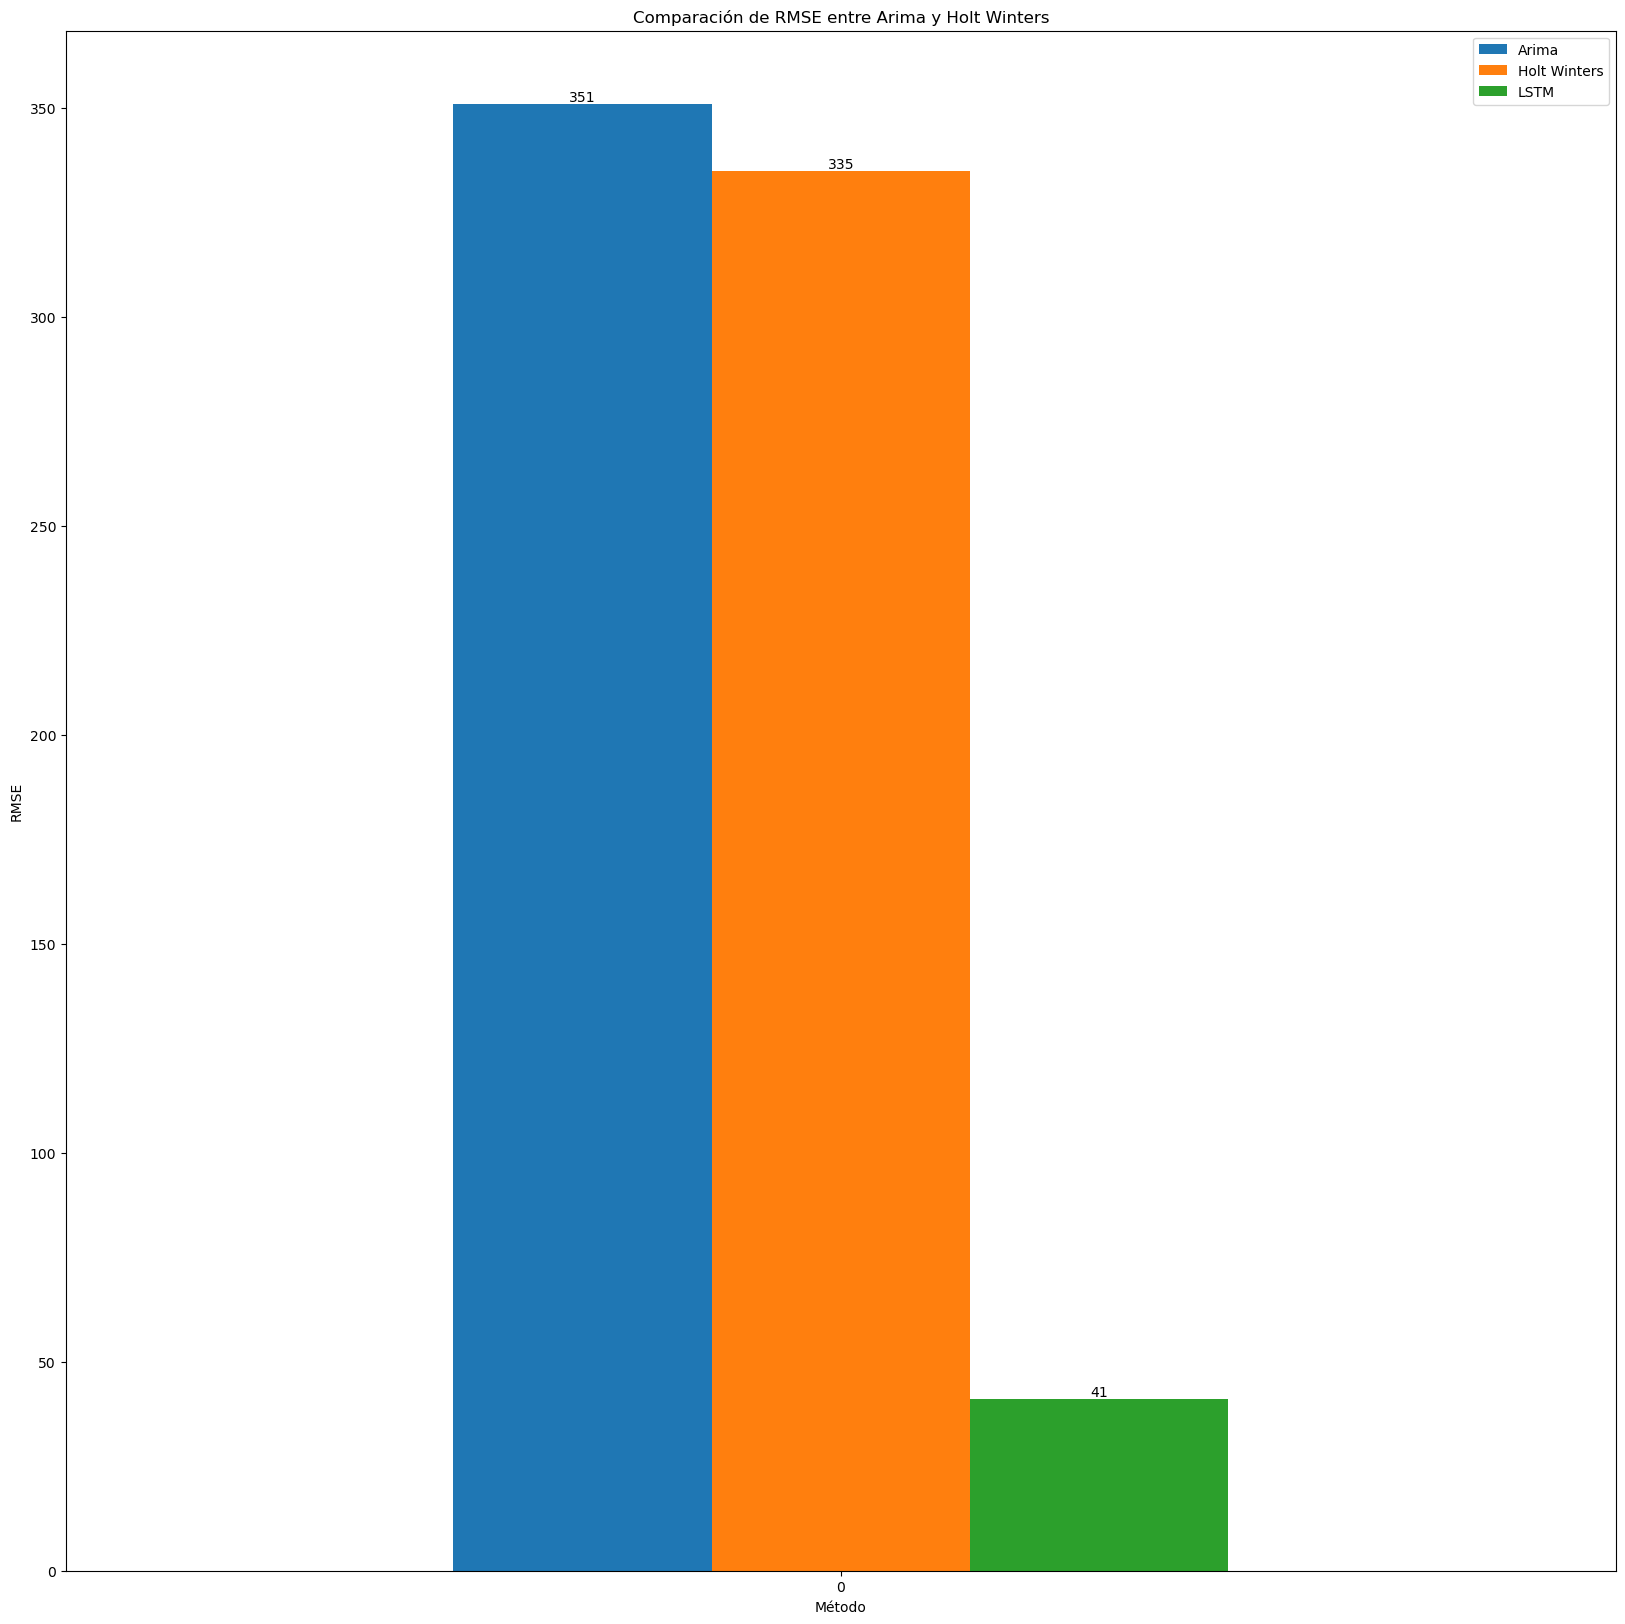

In [67]:
import pandas as pd
import matplotlib.pyplot as plt

resultados = pd.DataFrame({
    'Arima': [round(351)],
    'Holt Winters': [round(335)],
    'LSTM': [round(40.8)]
})

# Crear el gráfico de barras
ax = resultados.plot(kind='bar')
plt.ylabel('RMSE')  # Etiqueta para el eje y
plt.xlabel('Método')  # Etiqueta para el eje x
plt.title('Comparación de RMSE entre Arima y Holt Winters')  # Título del gráfico
plt.xticks(rotation=0)  # Rotación de etiquetas del eje x

# Agregar etiquetas de datos en las barras
for i in ax.patches:
    ax.text(i.get_x() + i.get_width() / 2, i.get_height(), str(round(i.get_height(), 2)), ha='center', va='bottom')

plt.show()  # Mostrar el gráfico


In [68]:
df_final=df_resultado[['Fecha','Apparent_energy','Cliente_ID']]
df_grouped = df_final.groupby(['Cliente_ID', pd.Grouper(key='Fecha', freq='D')])['Apparent_energy'].sum().reset_index()
df_grouped
import datetime

def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)

# Suponiendo que 'Fecha' es una cadena de fecha en el formato 'YYYY-MM-DD'
# Si 'Fecha' ya es un objeto Timestamp, no necesitas esta conversión
df_grouped['Fecha'] = df_grouped['Fecha'].apply(lambda x: x.strftime('%Y-%m-%d') if isinstance(x, pd.Timestamp) else x)
df_grouped['Fecha'] = df_grouped['Fecha'].apply(str_to_datetime)
df_grouped.index = df_grouped.pop('Fecha')

In [69]:
df_hist=df_grouped.copy().reset_index()
df_hist['clase']='History'
#df_hist.to_excel('/content/drive/MyDrive/Proyecto electrodunas/history.xlsx', index=False)

In [70]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Apparent_energy'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df
# Start day second time around: '2021-03-25'
#windowed_df = df_to_windowed_df(df_cli1.drop('Cliente_ID',axis=1),
#                                '2021-01-04',
#                                '2023-03-24',
#                                n=3)
#windowed_df

In [71]:
dataframe = df_grouped
client_ids = dataframe['Cliente_ID'].unique()

for client_id in client_ids:
    client_data = dataframe[dataframe['Cliente_ID'] == client_id]
    df_cli = client_data.drop('Cliente_ID', axis=1)
    windowed_df = df_to_windowed_df(df_cli,
                                     '2021-01-04',
                                     df_cli.index.max().strftime('%Y-%m-%d'),
                                     n=3)
    windowed_df['Cliente_ID'] = client_id
    if client_id == 1:
        consolidated_dataset = windowed_df.copy()
    else:
        consolidated_dataset = pd.concat([consolidated_dataset, windowed_df], axis=0, ignore_index=True)


In [72]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((473,), (473, 4, 1), (473,))

In [73]:
#Modelo definitivo sin tunning
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

target_data = consolidated_dataset.copy()

# Define la función para generar el diccionario de modelos, métricas y predicciones
def train_lstm_models_per_client(target_data):
    lstm_models_dict = {}

    unique_client_ids = target_data['Cliente_ID'].unique()

    for client_id in unique_client_ids:
        client_data = target_data[target_data['Cliente_ID'] == client_id]
        client_data = client_data.drop(columns=['Cliente_ID'])  # Elimina la columna Cliente_ID

        # Prepara los datos para entrenamiento
        dates, X, y = windowed_df_to_date_X_y(client_data)
        q_80 = int(len(dates) * .8)
        q_90 = int(len(dates) * .9)
        q_91 = int(len(dates))
        dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
        dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
        dates_test, X_test, y_test = dates[q_90:q_91], X[q_90:q_91], y[q_90:q_91]

        # Define el modelo LSTM
        model = Sequential([
            layers.Input((X_train.shape[1], X_train.shape[2])),
            layers.LSTM(64),
            layers.Dense(32, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(1)
        ])

        # Compila el modelo
        model.compile(loss='mse',
                      optimizer=Adam(learning_rate=0.001),
                      metrics=['mean_absolute_error'])

        # Entrena el modelo
        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, verbose=0)

        # Realiza predicciones en los datos de validación y en el siguiente mes después del conjunto de prueba
        val_predictions = model.predict(X_val)
        next_month_predictions = model.predict(X_test)

        # Evalúa el modelo en los datos de entrenamiento, validación y el siguiente mes
        train_mse = mean_squared_error(y_train, model.predict(X_train))
        val_mse = mean_squared_error(y_val, val_predictions)
        next_month_mse = mean_squared_error(y_test, next_month_predictions)

        # Encuentra la máxima fecha en X_test
        max_test_date = max(dates_test)

        # Genera las fechas para el próximo mes
        next_month_dates = pd.date_range(start=max_test_date + pd.Timedelta(days=1), periods=len(next_month_predictions), freq='D')

        # Crea un DataFrame con las predicciones para el próximo mes
        predictions_df = pd.DataFrame({'Fecha': next_month_dates, 'Apparent_energy': next_month_predictions.flatten()})
        predictions_df['Cliente_ID'] = client_id

        # Almacena el modelo, las métricas y las predicciones
        lstm_models_dict[client_id] = {
            'model': model,
            'train_mse': train_mse,
            'val_mse': val_mse,
            'test_mse':next_month_mse,
            'next_month_predictions_df': predictions_df
        }

    return lstm_models_dict

# Llama a la función para entrenar los modelos LSTM y obtener el diccionario resultante
lstm_models_dict = train_lstm_models_per_client(target_data)

for client_id, model_info in lstm_models_dict.items():
    print(f"Cliente ID: {client_id}, Train MSE: {model_info['train_mse']}, Val MSE: {model_info['val_mse']}")
# Concatena todos los DataFrames de predicciones en uno solo
all_predictions_df = pd.concat([model_info['next_month_predictions_df'] for model_info in lstm_models_dict.values()], ignore_index=True)

# Imprime el DataFrame con las predicciones para el próximo mes
all_predictions_df


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/s

Fecha  Apparent_energy  Cliente_ID
0    2023-04-02        41.631645           1
1    2023-04-03        41.787876           1
2    2023-04-04        40.786678           1
3    2023-04-05        37.980545           1
4    2023-04-06        25.904543           1
...         ...              ...         ...
1929 2022-06-04        21.717377          30
1930 2022-06-05        21.795233          30
1931 2022-06-06        20.569016          30
1932 2022-06-07        20.979416          30
1933 2022-06-08        20.689737          30

[1934 rows x 3 columns]

In [74]:
# Inicializa las sumas de los cuadrados de los errores
all_predictions_df["clase"]='Predict'
df_zscore = pd.concat([df_hist, all_predictions_df], ignore_index=True)
total_train_mse = 0
total_val_mse = 0
total_test_mse = 0

# Itera sobre cada cliente en el diccionario
for client_id, client_data in lstm_models_dict.items():
    # Suma los errores cuadrados para el conjunto de entrenamiento
    total_train_mse += client_data['train_mse']

    # Suma los errores cuadrados para el conjunto de validación
    total_val_mse += client_data['val_mse']

    # Suma los errores cuadrados para el conjunto de prueba
    total_test_mse += client_data['test_mse']

# Calcula el RMSE total para cada conjunto
total_train_rmse = np.sqrt(total_train_mse)
total_val_rmse = np.sqrt(total_val_mse)
total_test_rmse = np.sqrt(total_test_mse)

prom_train_rmse = np.sqrt(total_train_mse) / len(lstm_models_dict)
prom_val_rmse = np.sqrt(total_val_mse) / len(lstm_models_dict)
prom_test_rmse = np.sqrt(total_test_mse) / len(lstm_models_dict)

total_test_lstm=np.sqrt(total_test_mse)
print("RMSE total para conjunto de entrenamiento:", total_train_rmse)
print("RMSE total para conjunto de validación:", total_val_rmse)
print("RMSE total para conjunto de prueba:", total_test_rmse)
print("-----------------------------------------------------")
print("RMSE prom para conjunto de entrenamiento:", prom_train_rmse)
print("RMSE prom para conjunto de validación:", prom_val_rmse)
print("RMSE prom para conjunto de prueba:", prom_test_rmse)


RMSE total para conjunto de entrenamiento: 38.340316485047424
RMSE total para conjunto de validación: 27.25055978795
RMSE total para conjunto de prueba: 41.28140370371386
-----------------------------------------------------
RMSE prom para conjunto de entrenamiento: 1.2780105495015808
RMSE prom para conjunto de validación: 0.9083519929316667
RMSE prom para conjunto de prueba: 1.3760467901237954


In [75]:
# Conociendo los clientes que presentan anomalías segun los thresholds 1.5, 3 y 4.5
# Función para calcular la desviación absoluta media (MAD)
#def mad(arr):
#   return np.abs(arr - np.median(arr)).mean()
def mad(arr):
    return (arr - np.median(arr)).abs().mean()
def detectar_anomalias(dataframe, outlier_limits):
    resultados = {limit: [] for limit in outlier_limits}  # Diccionario para almacenar los resultados por umbral
    clientes = dataframe['Cliente_ID'].unique()  # Obtener los clientes únicos

    for cliente_id in clientes:
        # Filtrar los datos por cliente y calcular la suma diaria de energía
        data_cliente = dataframe[dataframe['Cliente_ID'] == cliente_id]
        #data_diaria = data_cliente.resample('D', on='Fecha').sum()

        # Calcular la mediana y MAD
        median_val = np.median(data_cliente['Apparent_energy'])
        mad_val = mad(data_cliente['Apparent_energy'])

        # Chequear cada umbral
        for threshold in outlier_limits:
            # Calcular el límite inferior
            limite_inferior = median_val - threshold * mad_val

            # Identificar días donde el consumo está por debajo del límite inferior
            anomalias = data_cliente[data_cliente['Apparent_energy'] < limite_inferior]

            if not anomalias.empty:
                resultados[threshold].append(cliente_id)

    return resultados

# Límites de umbral para calcular
outlier_limits = [1.5, 3, 4.5]
resultados_anomalias = detectar_anomalias(df_zscore, outlier_limits)
resultados_anomalias

{1.5: [1, 2, 3, 5, 7, 8, 10, 11, 13, 14, 15, 20, 21, 22, 23, 24, 25, 27, 28],
 3: [2, 3, 5, 13, 14, 15, 22, 23, 25, 28],
 4.5: [5, 13, 15, 22, 23, 25]}

In [76]:
df_zscore.head()

Fecha  Cliente_ID  Apparent_energy    clase
0 2021-01-01           1        33.822878  History
1 2021-01-02           1        41.322765  History
2 2021-01-03           1        39.722672  History
3 2021-01-04           1        41.409175  History
4 2021-01-05           1        37.709285  History

In [77]:
# Generando un dataframe con los datos anómalos de z-score
# Calcular el Z-score para la energía aparente diaria para cada cliente
df_zscore['z_score'] = df_zscore.groupby('Cliente_ID')['Apparent_energy'].transform(lambda x: zscore(x, ddof=1))

# Establecer umbrales de Z-score para detectar anomalías inferiores
thresholds = [1.5, 3, 4.5]

# Crear columnas para cada umbral, marcando con 1 las anomalías y 0 lo contrario
for threshold in thresholds:
    column_name = f'anomalia_{threshold}_ZS'
    df_zscore[column_name] = (df_zscore['z_score'] < -threshold).astype(int)
df_zscore

Fecha  Cliente_ID  Apparent_energy    clase   z_score  \
0     2021-01-01           1        33.822878  History -0.467215   
1     2021-01-02           1        41.322765  History -0.256385   
2     2021-01-03           1        39.722672  History -0.301366   
3     2021-01-04           1        41.409175  History -0.253956   
4     2021-01-05           1        37.709285  History -0.357964   
...          ...         ...              ...      ...       ...   
21256 2022-06-04          30        21.717377  Predict -0.448177   
21257 2022-06-05          30        21.795233  Predict -0.445293   
21258 2022-06-06          30        20.569016  Predict -0.490708   
21259 2022-06-07          30        20.979416  Predict -0.475508   
21260 2022-06-08          30        20.689737  Predict -0.486237   

       anomalia_1.5_ZS  anomalia_3_ZS  anomalia_4.5_ZS  
0                    0              0                0  
1                    0              0                0  
2                    0              0                0  
3                    0              0                0  
4                    0              0                0  
...                ...            ...              ...  
21256                0              0                0  
21257                0              0                0  
21258                0              0                0  
21259                0              0                0  
21260                0              0                0  

[21261 rows x 8 columns]

In [78]:
# Clasificando a los clientes en consumo alto, medio o bajo según su promedio del último año

# Calculando el promedio de consumo por cliente
consumo_promedio = df_zscore.groupby('Cliente_ID')['Apparent_energy'].mean()

#Definición de los umbrales usando percentiles
percentiles = df_zscore['Apparent_energy'].quantile([0.333, 0.667]).to_list()

# Función para clasificar el consumo
def clasificar_consumo(x):
    if x <= percentiles[0]:
        return 'Bajo'
    elif x <= percentiles[1]:
        return 'Medio'
    else:
        return 'Alto'

clasificacion = consumo_promedio.apply(clasificar_consumo)
print(f'Se clasifica como consumo bajo a aquellos clientes con una energía aparente promedio menor a {round(percentiles [0],3)}')
print(f'Se clasifica como consumo medio a aquellos clientes con una energía aparente entre {round(percentiles [0],3)} y {round(percentiles [1],3)}')
print(f'Se clasifica como consumo alto a aquellos clientes con una energía aparente promedio mayor a {round(percentiles [1],3)}')

Se clasifica como consumo bajo a aquellos clientes con una energía aparente promedio menor a 17.091
Se clasifica como consumo medio a aquellos clientes con una energía aparente entre 17.091 y 45.976
Se clasifica como consumo alto a aquellos clientes con una energía aparente promedio mayor a 45.976


In [79]:
# Realizando un merge (unión) de los DataFrames en la columna 'Cliente_ID'
descriptivas = pd.merge(pd.merge(df_zscore, clasificacion, on='Cliente_ID', how='outer'),
                     df_sector, on='Cliente_ID', how='outer')

descriptivas.rename(columns={'Apparent_energy_x': 'Apparent_energy'}, inplace=True)
descriptivas.rename(columns={'Apparent_energy_y': 'Clasificacion_consumo'}, inplace=True)
descriptivas.head()

#agregar a tabla de clientes únicos

Fecha  Cliente_ID  Apparent_energy    clase   z_score  anomalia_1.5_ZS  \
0 2021-01-01           1        33.822878  History -0.467215                0   
1 2021-01-02           1        41.322765  History -0.256385                0   
2 2021-01-03           1        39.722672  History -0.301366                0   
3 2021-01-04           1        41.409175  History -0.253956                0   
4 2021-01-05           1        37.709285  History -0.357964                0   

   anomalia_3_ZS  anomalia_4.5_ZS Clasificacion_consumo  \
0              0                0                  Alto   
1              0                0                  Alto   
2              0                0                  Alto   
3              0                0                  Alto   
4              0                0                  Alto   

                                    Sector_Economico  
0  Elaboración de cacao y chocolate y de producto...  
1  Elaboración de cacao y chocolate y de producto...  
2  Elaboración de cacao y chocolate y de producto...  
3  Elaboración de cacao y chocolate y de producto...  
4  Elaboración de cacao y chocolate y de producto...

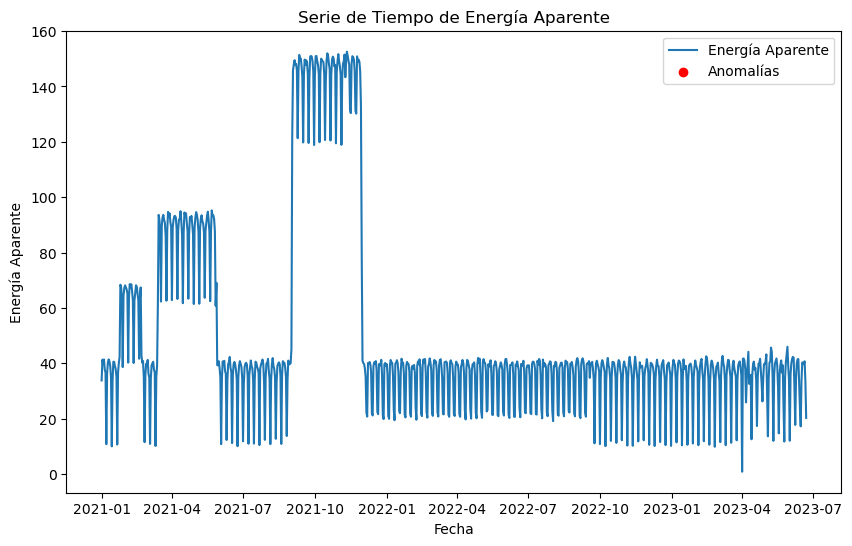

In [80]:
descriptivas['Fecha'] = pd.to_datetime(descriptivas['Fecha'])
cli1=descriptivas[descriptivas['Cliente_ID']==1]
# Filtrar las anomalías con valor diferente de 0
df_anomalias = cli1[cli1['anomalia_1.5_ZS'] != 0]

# Crear el gráfico de serie de tiempo
plt.figure(figsize=(10, 6))
plt.plot(cli1['Fecha'], cli1['Apparent_energy'], label='Energía Aparente')
plt.scatter(df_anomalias['Fecha'], df_anomalias['Apparent_energy'], color='red', label='Anomalías')
plt.xlabel('Fecha')
plt.ylabel('Energía Aparente')
plt.title('Serie de Tiempo de Energía Aparente')
plt.legend()
plt.show()

In [81]:
descriptivas[descriptivas['anomalia_1.5_ZS'] != 0]['Cliente_ID'].unique()
descriptivas
#data = descriptivas[descriptivas['Cliente_ID'] == cliente_id][['Fecha', 'Apparent_energy']].set_index('Fecha')

Fecha  Cliente_ID  Apparent_energy    clase   z_score  \
0     2021-01-01           1        33.822878  History -0.467215   
1     2021-01-02           1        41.322765  History -0.256385   
2     2021-01-03           1        39.722672  History -0.301366   
3     2021-01-04           1        41.409175  History -0.253956   
4     2021-01-05           1        37.709285  History -0.357964   
...          ...         ...              ...      ...       ...   
21256 2022-06-04          30        21.717377  Predict -0.448177   
21257 2022-06-05          30        21.795233  Predict -0.445293   
21258 2022-06-06          30        20.569016  Predict -0.490708   
21259 2022-06-07          30        20.979416  Predict -0.475508   
21260 2022-06-08          30        20.689737  Predict -0.486237   

       anomalia_1.5_ZS  anomalia_3_ZS  anomalia_4.5_ZS Clasificacion_consumo  \
0                    0              0                0                  Alto   
1                    0              0                0                  Alto   
2                    0              0                0                  Alto   
3                    0              0                0                  Alto   
4                    0              0                0                  Alto   
...                ...            ...              ...                   ...   
21256                0              0                0                 Medio   
21257                0              0                0                 Medio   
21258                0              0                0                 Medio   
21259                0              0                0                 Medio   
21260                0              0                0                 Medio   

                                        Sector_Economico  
0      Elaboración de cacao y chocolate y de producto...  
1      Elaboración de cacao y chocolate y de producto...  
2      Elaboración de cacao y chocolate y de producto...  
3      Elaboración de cacao y chocolate y de producto...  
4      Elaboración de cacao y chocolate y de producto...  
...                                                  ...  
21256  Venta al por mayor de metales y minerales meta...  
21257  Venta al por mayor de metales y minerales meta...  
21258  Venta al por mayor de metales y minerales meta...  
21259  Venta al por mayor de metales y minerales meta...  
21260  Venta al por mayor de metales y minerales meta...  

[21261 rows x 10 columns]

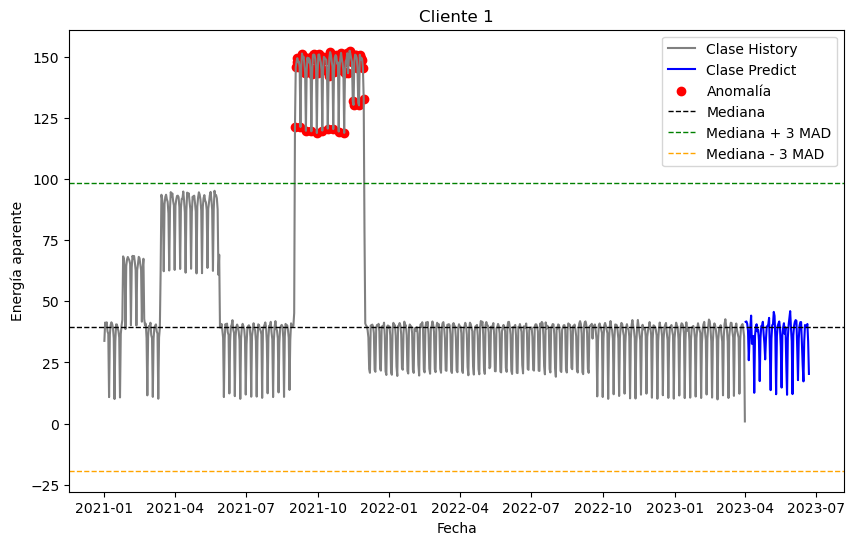

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore


threshold = 3  # Umbral de Z-score para considerar una anomalía

# Filtrar el DataFrame por el Cliente_ID = 1
cliente_id = 1
data = descriptivas[descriptivas['Cliente_ID'] == cliente_id][['Fecha', 'Apparent_energy', 'clase']].set_index('Fecha')
#data = data.resample('D').sum()  # Agrupar los datos por día y sumar

# Calcular Z-score para la columna 'Apparent_energy'
data['z_score'] = zscore(data['Apparent_energy'])

# Calcular la mediana y MAD
median_val = np.median(data['Apparent_energy'])
mad_val = mad(data['Apparent_energy'])

# Identificar anomalías
data['anom'] = data['Apparent_energy'].apply(lambda x: x < median_val - (threshold * mad_val) or x > median_val + (threshold * mad_val))

# Filtrar los datos anómalos para la gráfica
anomalous_data = data[data['anom']]

# Preparar la figura para el subplot
fig, ax = plt.subplots(figsize=(10, 6))

# Definir un mapa de colores para las clases
color_map = {
    'History': 'gray',
    'Predict': 'blue',
    'Clase3': 'purple',
    # Añadir más clases y colores si es necesario
}

# Graficar resultados con colores por clase
for clase in data['clase'].unique():
    clase_data = data[data['clase'] == clase]
    ax.plot(clase_data.index, clase_data['Apparent_energy'], label=f'Clase {clase}', color=color_map.get(clase, color_map[clase]))

# Graficar los puntos de anomalía
ax.scatter(anomalous_data.index, anomalous_data['Apparent_energy'], c='red', label='Anomalía', marker='o')

# Graficar líneas de mediana y MAD con umbral
ax.axhline(median_val, color='black', linestyle='--', linewidth=1, label='Mediana')
ax.axhline(median_val + mad_val * threshold, color='green', linestyle='--', linewidth=1, label=f'Mediana + {threshold} MAD')
ax.axhline(median_val - mad_val * threshold, color='orange', linestyle='--', linewidth=1, label=f'Mediana - {threshold} MAD')

# Configurar el subplot
ax.set_title(f'Cliente {cliente_id}')
ax.set_ylabel('Energía aparente')
ax.set_xlabel('Fecha')
ax.legend()

plt.show()


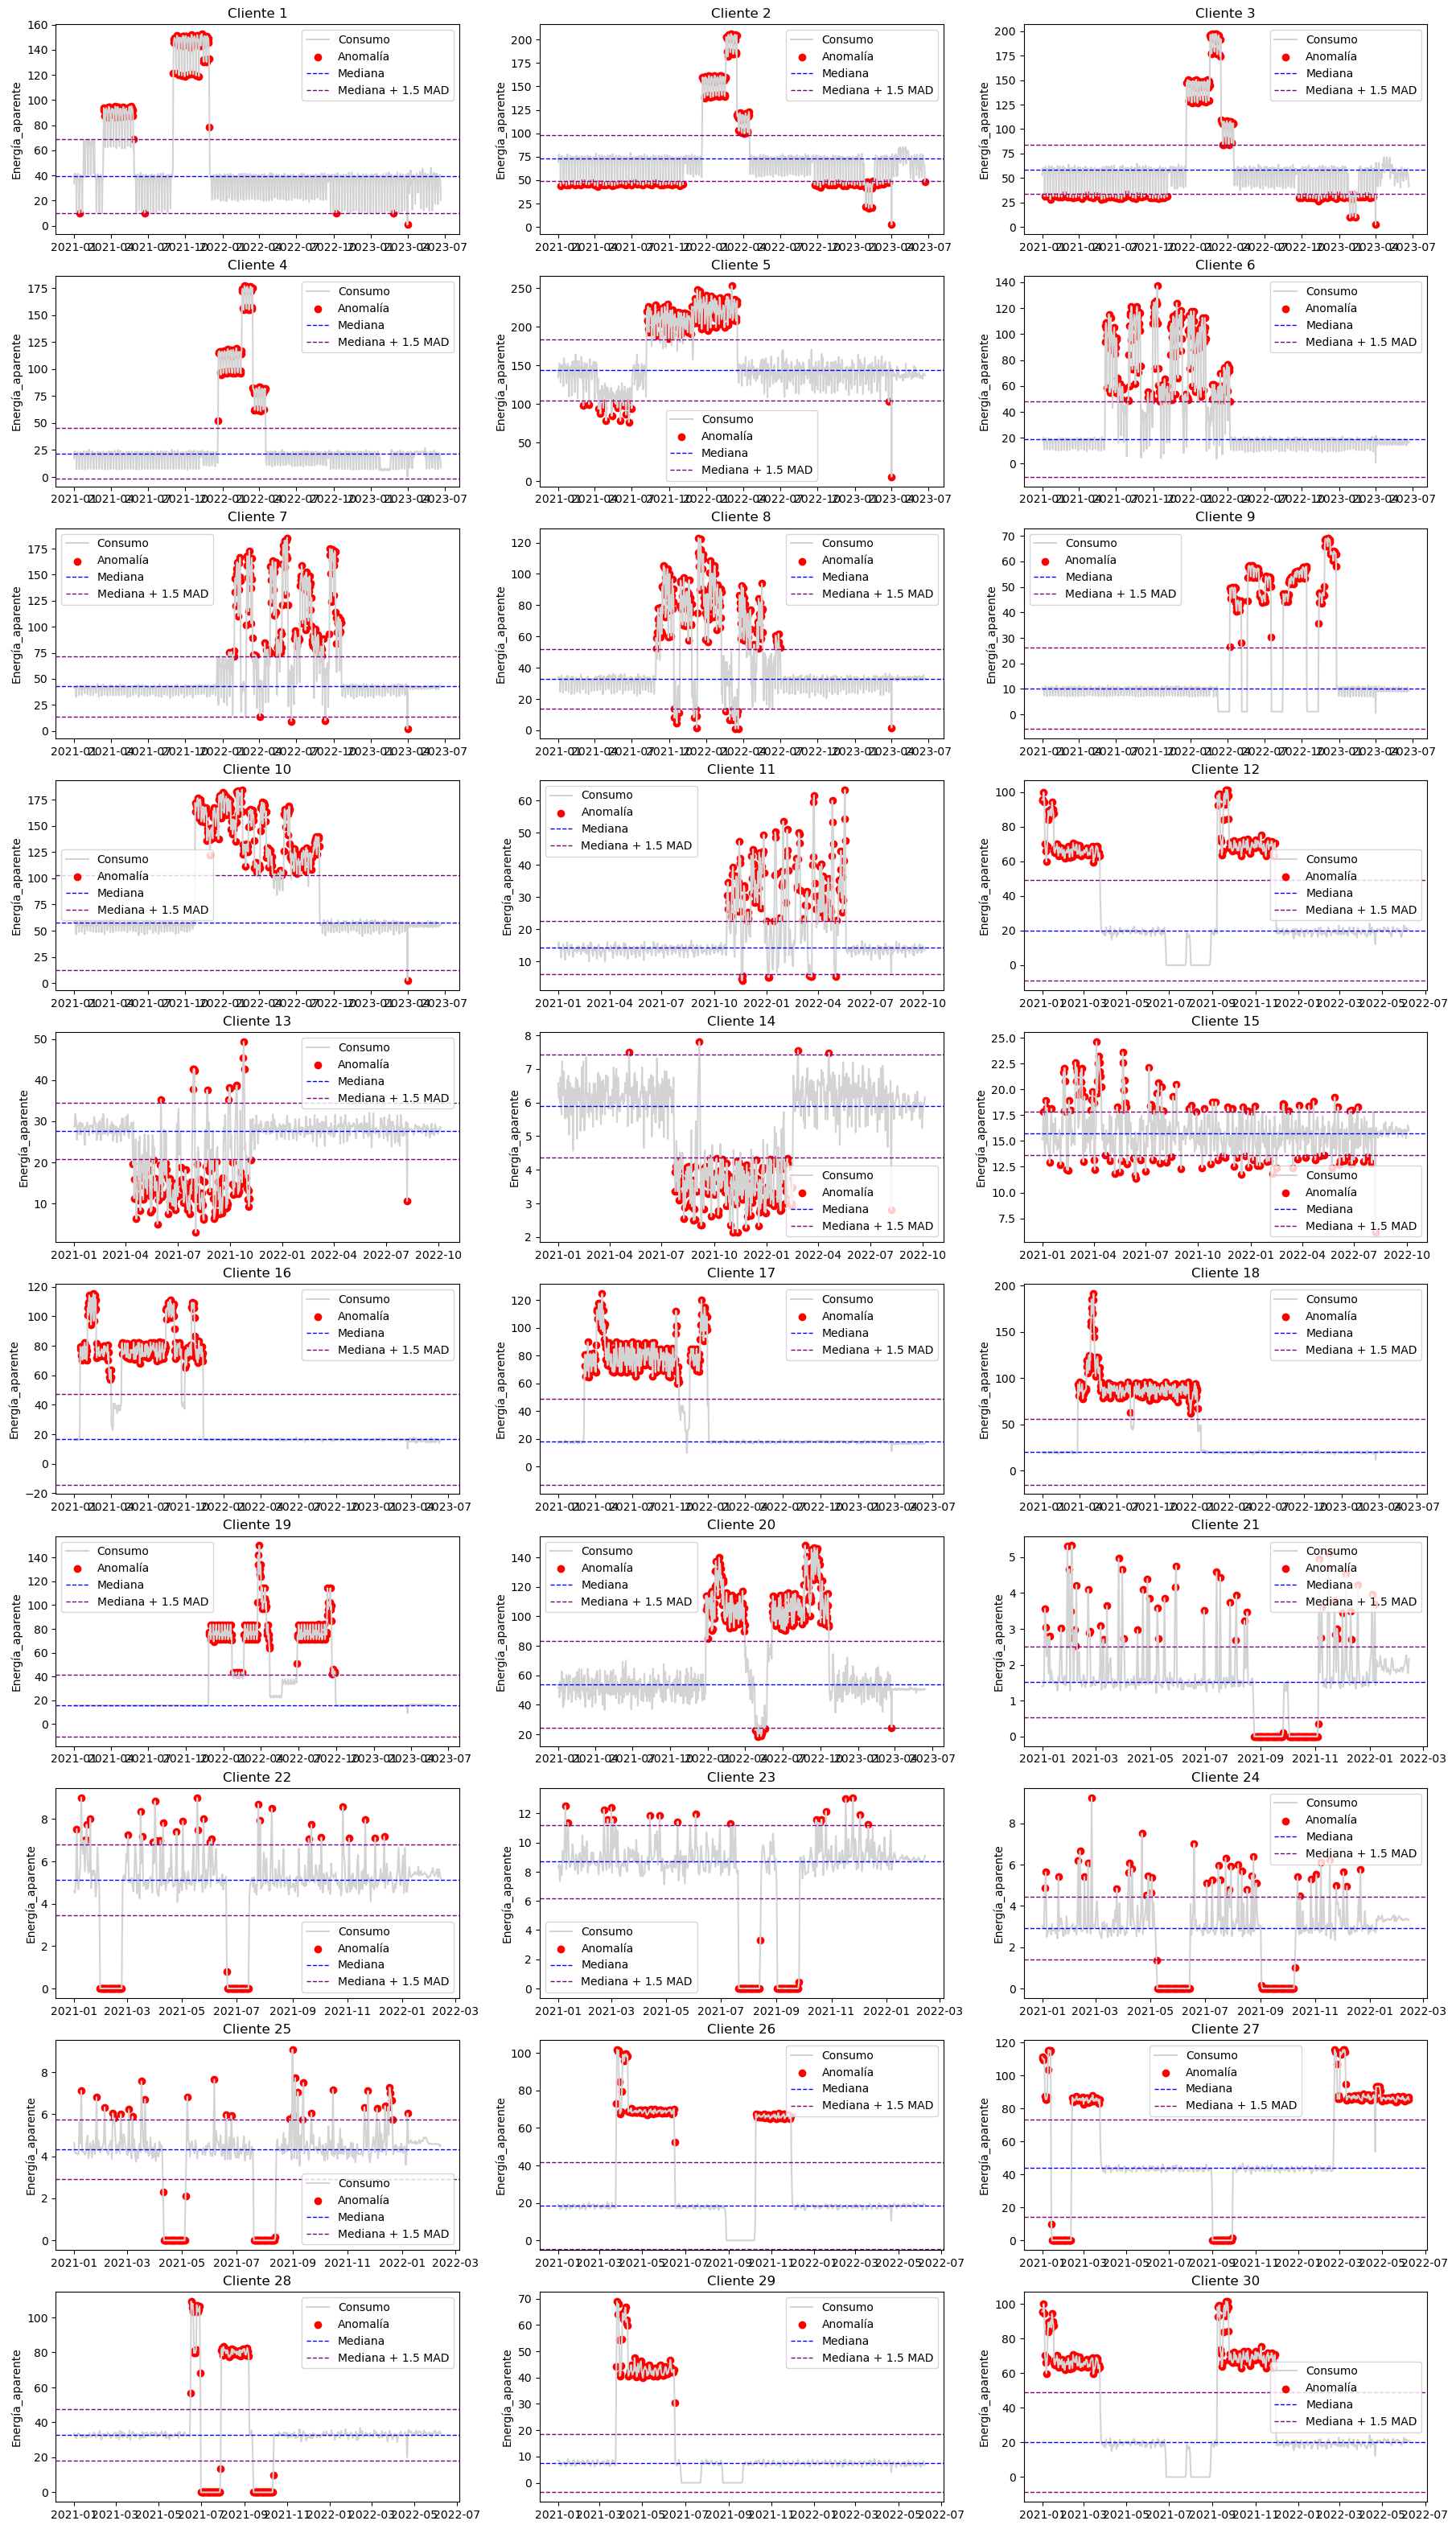

In [83]:
threshold = 1.5  # Umbral de Z-score para considerar una anomalía

# Preparar la figura para los subplots
n_cols = 3  # Número de columnas por fila
clientes = sorted(descriptivas['Cliente_ID'].unique())
n_rows = (len(clientes) + n_cols - 1) // n_cols  # Calcular el número de filas necesario
fig, axes = plt.subplots(n_rows, n_cols, figsize=(22, 4 * n_rows), squeeze=False)  # Ajustar tamaño de cada subplot

# Iterar sobre cada cliente y crear los subplots correspondientes
for idx, cliente_id in enumerate(clientes):
    ax = axes[idx // n_cols, idx % n_cols]  # Determinar el subplot actual

    # Filtrar el DataFrame por el Cliente_ID actual
    data = descriptivas[descriptivas['Cliente_ID'] == cliente_id][['Fecha', 'Apparent_energy']].set_index('Fecha')
    data = data.resample('D').sum()  # Agrupar los datos por día y sumar

    # Calcular Z-score para la columna 'Apparent_energy'
    data['z_score'] = zscore(data['Apparent_energy'])

    # Calcular la mediana y MAD
    median_val = np.median(data['Apparent_energy'])
    mad_val = mad(data['Apparent_energy'])

    # Identificar anomalías
    data['anom'] = data['Apparent_energy'].apply(lambda x: x < median_val - (threshold * mad_val) or x > median_val + (threshold * mad_val))

    # Filtrar los datos anómalos para la gráfica
    anomalous_data = data[data['anom']]

    # Graficar resultados
    ax.plot(data.index, data['Apparent_energy'], label='Consumo', color='lightgray')
    ax.scatter(anomalous_data.index, anomalous_data['Apparent_energy'], c='red', label='Anomalía', marker='o')

    # Graficar líneas de mediana y MAD con umbral
    ax.axhline(median_val, color='blue', linestyle='--', linewidth=1, label='Mediana')
    ax.axhline(median_val + mad_val * threshold, color='purple', linestyle='--', linewidth=1, label=f'Mediana + {threshold} MAD')
    ax.axhline(median_val - mad_val * threshold, color='purple', linestyle='--', linewidth=1)

    # Configurar el subplot
    ax.set_title(f'Cliente {cliente_id}')
    ax.set_ylabel('Energía_aparente')
    ax.legend()

